In [1]:
# model and env
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import gymnasium as gym
from collections import deque
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
class FootballEnv(gym.Env):
    def __init__(self, grid_rows=121, grid_cols=51):
        super(FootballEnv, self).__init__()
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols

        self.action_space = gym.spaces.Discrete(10)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(7,), dtype=np.float32)
        self.layout = np.zeros((grid_rows, grid_cols), dtype=str)
        self.layout[:, :] = "."
        self.layout[self.grid_rows//2, self.grid_cols//2] = "C"
        self.layout[self.grid_rows//2-8 : self.grid_rows//2+9, -6:-1] = "D"
        self.layout[self.grid_rows//2-8 : self.grid_rows//2+9, 0:5] = "d"
        self.layout[:, self.grid_cols//2] = "M"
        self.layout[:, -1] = "O"
        self.layout[:, 0] = "O"
        self.layout[0, :] = "O"
        self.layout[-1, :] = "O"
        self.layout[self.grid_rows//2-4 : self.grid_rows//2+5, -1] = "G"
        self.layout[self.grid_rows//2-4 : self.grid_rows//2+5, 0] = "g"
        self.ball_pos = (self.grid_rows//2, self.grid_cols//2)
        self.episode_steps = 0


    def _get_state(self,player,players):

        same_team = []
        other_team = []
        for play in players:
            if player.team == play.team:
                same_team.extend([play.position[0]/self.grid_rows -1 ,play.position[1]/self.grid_cols -1])
            else:
                other_team.extend([play.position[0]/self.grid_rows -1 ,play.position[1]/self.grid_cols -1])
        other_team = [-1*x for x in other_team]
        # print(same_team,other_team)
        return np.array([
            *same_team,
            *other_team,
            float(player.has_ball),
            self.grid_rows // 2 / (self.grid_rows - 1),
            (self.grid_cols - 1) / (self.grid_cols - 1)
        ], dtype=np.float32)


    def reset(self, players, seed=None, options=None):
        super().reset(seed=seed)

        occupied_positions = set()
        for player in players:
            while True:
                if player.team == 0:
                    player_row = random.randint(self.grid_rows // 2 - 3, self.grid_rows // 2 + 3)
                    player_col = random.randint(1, self.grid_cols // 4)
                elif player.role == "GK":
                    if player.team == 0:
                        player_row = self.grid_rows // 2
                        player_col = 1
                    else: 
                        player_row = self.grid_rows // 2
                        player_col = self.grid_cols - 2
                else:
                    player_row = random.randint(self.grid_rows // 2 - 3, self.grid_rows // 2 + 3)
                    player_col = random.randint(3 * self.grid_cols // 4, self.grid_cols - 2)

                if (player_row, player_col) not in occupied_positions:
                    occupied_positions.add((player_row, player_col))
                    player.position = (player_row, player_col)
                    break

        while True:
            ball_row = random.randint(1, self.grid_rows - 2)  # Avoid boundary walls
            ball_col = random.randint(self.grid_cols // 4, 3 * self.grid_cols // 4)  # Avoid goalposts


            if (ball_row, ball_col) not in occupied_positions:
                self.ball_pos = (ball_row, ball_col)
                break
        self.episode_steps = 0
        return {}, {}

    def step_goalkeeper(self, action, player, players):
        self.episode_steps += 1
        reward = -0.001  # Small negative reward per step to encourage efficiency
        done = False

        # Move the ball towards the goalkeeper (left)
        ball_dx = 0
        ball_dy = -1  # Move left
        new_ball_pos = (self.ball_pos[0] + ball_dx, self.ball_pos[1] + ball_dy)

        # Ensure the ball stays in bounds
        if 0 <= new_ball_pos[1] < self.grid_cols:
            self.ball_pos = new_ball_pos

        # Handle goalkeeper movement
        if action < 8:  # Movement actions in 8 directions
            dx, dy = [(0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1)][action]
            new_pos = (player.position[0] + dx, player.position[1] + dy)
            
            # Check if the new position is within the D box
            if player.team == 0:  # Left-side goalkeeper
                d_box_min_col, d_box_max_col = 0, 5
                d_box_min_row, d_box_max_row = self.grid_rows // 2 - 4, self.grid_rows // 2 + 5
            else:  # Right-side goalkeeper
                d_box_min_col, d_box_max_col = self.grid_cols - 6, self.grid_cols - 1
                d_box_min_row, d_box_max_row = self.grid_rows // 2 - 4, self.grid_rows // 2 + 5

            is_inside_d_box = (d_box_min_row <= new_pos[0] <= d_box_max_row) and (d_box_min_col <= new_pos[1] <= d_box_max_col)

            if is_inside_d_box:
                player.prev_position = player.position
                player.position = new_pos
                if player.has_ball:
                    self.ball_pos = new_pos
                    
                # Calculate distance to ball before and after movement
                old_dist_to_ball = np.linalg.norm(np.array(player.prev_position) - np.array(self.ball_pos))
                new_dist_to_ball = np.linalg.norm(np.array(player.position) - np.array(self.ball_pos))
                
                # Reward for moving closer to the ball
                if new_dist_to_ball < old_dist_to_ball:
                    reward += 0.1 * (old_dist_to_ball - new_dist_to_ball)
                else:
                    reward -= 0.05  # Small penalty for moving away from ball
            else:
                reward += player.ball_lost  # Penalty for moving out of the D box
                done = True  # End episode if the goalkeeper moves out of the D box

        # Check if the goalkeeper can catch the ball
        if action == 8:  # Block/catch action
            dist_to_ball = np.linalg.norm(np.array(player.position) - np.array(self.ball_pos))
            
            if dist_to_ball <= 2:  # Within blocking range
                player.has_ball = True
                self.ball_pos = player.position  # Ball is now with the GK
                reward += player.block_reward + player.ball_held
                done = True  # Episode ends when GK successfully blocks
            else:
                # Penalty for trying to block when ball is too far
                reward -= 1.0
                
        # Check if the ball is in the goal
        if self.layout[self.ball_pos[0], self.ball_pos[1]] == 'G':
            reward += player.goal_conceded  # Penalty for conceding a goal
            done = True  # End the episode if the ball enters the goal

        truncated = self.episode_steps >= 3000
        return self._get_state(player, players), reward, done, truncated, {} 
        
    def step(self, action,player,players):
        self.episode_steps += 1
        reward = player.step_penalty
        done = False

        if action < 8:  # Movement actions
            dx, dy = [(0, -1), (1, 0), (0, 1), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)][action]
            new_pos = (player.position[0] + dx, player.position[1] + dy)

            if 0 <= new_pos[0] < self.grid_rows and 0 <= new_pos[1] < self.grid_cols and self.layout[new_pos[0],new_pos[1]] != "O":
                player.prev_position = player.position
                player.position = new_pos
                if player.has_ball:
                    self.ball_pos = new_pos
            else:
                reward -= 20  # Massive penalty
                done = True  # End episode if the player goes out
                # return self._get_state(), reward, done, True, {}
                return self._get_state(player,players), reward, done, True, {}

        # elif action == 8 and player.has_ball:  # Long shot
        #     goal_y_center = self.grid_rows // 2
        #     # Better aim toward goal
        #     target_y = min(max(goal_y_center + random.randint(-2, 2), 0), self.grid_rows-1)
        #     new_ball_col = min(self.ball_pos[1] + 10, self.grid_cols - 1)
        #     self.ball_pos = (target_y, new_ball_col)
        #     self.has_ball = False

        # elif action == 9 and self.has_ball:  # Short pass
        #     new_ball_col = min(self.ball_pos[1] + 5, self.grid_cols - 1)
        #     self.ball_pos = (self.ball_pos[0], new_ball_col)
        #     self.has_ball = False

        # Check if player gets the ball
        player.prev_ball_statues = player.has_ball
        player.has_ball = player.position == self.ball_pos
        
        # Reward shaping
        if player.has_ball:
            reward += player.ball_possession_bonus

        if player.has_ball:
            reward += 0.001
        
        # Distance-based rewards
        dist_to_ball = np.sqrt((player.position[0] - self.ball_pos[0])**2 + 
                              (player.position[1] - self.ball_pos[1])**2)
        if dist_to_ball < 5 and not player.has_ball:
            reward += player.near_ball_bonus
        
        if player.has_ball:
            # Calculate distance to goal
            dist_to_goal = self.grid_cols - 1 - player.position[1]
            if dist_to_goal < 10:
                reward += player.near_goal_bonus * (1 - dist_to_goal/10.0)
        
        # Goal reward
        if self.layout[self.ball_pos[0], self.ball_pos[1]] == 'G':
            reward += player.goal_reward
            done = True

        truncated = self.episode_steps >= 3000
        return self._get_state(player,players), reward, done, truncated, {}

    def render(self,players):
        grid = np.full((self.grid_rows, self.grid_cols), '-')
        
        # Draw field elements
        for i in range(self.grid_rows):
            for j in range(self.grid_cols):
                if self.layout[i,j] == 'O':
                    grid[i,j] = '#'
                elif self.layout[i,j] == 'G':
                    grid[i,j] = '|'
                elif self.layout[i,j] == 'M':
                    grid[i,j] = '.'

        grid[self.ball_pos[0], self.ball_pos[1]] = 'B'
        
        # Draw player and ball
        for player in players:
            if player.team == 0:
                grid[player.position[0], player.position[1]] = 'P'
            else:
                grid[player.position[0], player.position[1]] = 'Q'

        
        
        # Print the grid
        print('-' * (self.grid_cols + 2))
        for row in grid:
            print('|' + ''.join(row) + '|')
        print('-' * (self.grid_cols + 2))


class Player():
    def __init__(self,role,team,env):
        self.role = role
        self.team = team
        self.position = [random.randint(env.grid_rows//2-3, env.grid_rows//2+3),random.randint(1, env.grid_cols//4)]
        self.prev_position = []
        self.prev_ball_statues = False
        self.has_ball = False
        self.goal_reward = 52
        self.step_penalty = -0.001
        self.ball_possession_bonus = 0.008
        self.near_ball_bonus = 0.00001
        self.near_goal_bonus = 0.00002
        #Goalkeeper specific rewards   
        self.block_reward = 30 
        self.pass_reward = 1 
        self.ball_lost = -5
        self.ball_held = 5
        self.goal_conceded = -50

class DQN(nn.Module):
    def __init__(self, input_dim, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_size)
        
        # Initialize weights with better defaults
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0003
        self.memory = deque(maxlen=100000)
        self.batch_size = 256
        self.target_update_freq = 5  # Update target network every N episodes
        
        # Action-specific exploration rates to encourage movement
        self.action_epsilon = np.ones(action_size) * 0.1
        self.action_epsilon[8] = 0.05  # Lower epsilon for the block action
        
        self.device = device
        self.model = DQN(state_size, action_size).to(self.device)
        self.target_model = DQN(state_size, action_size).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        self.rewards_history = []
        self.episode_count = 0


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, evaluate=False):
        if not evaluate:
            # Use action-specific exploration rates
            if np.random.rand() <= self.epsilon:
                # Choose random action but bias toward movement when exploring
                if np.random.rand() < 0.8:  # 80% chance to choose movement when exploring
                    return random.randrange(8)  # Only choose from movement actions
                else:
                    return random.randrange(self.action_size)
        
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
            
            # Add small noise to q-values to break ties randomly
            if not evaluate:
                q_values = q_values + torch.randn_like(q_values) * 0.01
                
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0
            
        minibatch = random.sample(self.memory, self.batch_size)
    
        states = torch.FloatTensor(np.array([experience[0] for experience in minibatch])).to(self.device)
        actions = torch.LongTensor([experience[1] for experience in minibatch]).to(self.device)
        rewards = torch.FloatTensor([experience[2] for experience in minibatch]).to(self.device)
        next_states = torch.FloatTensor(np.array([experience[3] for experience in minibatch])).to(self.device)
        dones = torch.FloatTensor([experience[4] for experience in minibatch]).to(self.device)
    
        curr_q_values = self.model(states).gather(1, actions.unsqueeze(1))
    
        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1)[0]
    
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
    
        loss = F.mse_loss(curr_q_values.squeeze(), target_q_values)
    
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)  
        self.optimizer.step()
    
        return loss.item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay             


In [4]:
def train_goalkeeper_agent(env, episodes, max_steps):
    # Create a goalkeeper for one team
    players = [Player('GK', 0, env)]
    
    # Verify state size before creating agent
    sample_state = env._get_state(players[0], players)
    print(f"State size: {len(sample_state)}")
    
    # Create a DQN agent for the goalkeeper
    agent = DQNAgent(len(sample_state), 9)  # 9 possible actions (8 movements + block)
    
    for episode in range(episodes):
        # Reset the environment
        env.reset(players)
        
        # Start the ball at the middle of the field
        ball_start_col = env.grid_cols // 2
        ball_start_row = env.grid_rows // 2
        env.ball_pos = (ball_start_row, ball_start_col)
        
        total_reward = 0
        done = False
        truncated = False
        
        for step in range(max_steps):
            if done or truncated:
                break
            
            # Move the ball towards the goalkeeper
            # env.ball_pos = (env.ball_pos[0], env.ball_pos[1] - 1)  # Move ball left
            
            # Get the goalkeeper's state
            state = env._get_state(players[0], players)
            
            # Choose action
            action = agent.act(state)
            
            
            # Step the goalkeeper
            next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
            
            # Remember the experience
            agent.remember(state, action, reward, next_state, done or truncated)
            
            # Replay (learn from experiences)
            if len(agent.memory) >= agent.batch_size:
                agent.replay()
            
            total_reward += reward
            
        # Decay exploration, update target network
        agent.episode_count += 1
        if agent.episode_count % agent.target_update_freq == 0:
            agent.update_target_model()
        agent.decay_epsilon()
        
        # Track rewards
        agent.rewards_history.append(total_reward)
        
        print(f"Episode {episode+1}: Total Reward = {total_reward}, Epsilon = {agent.epsilon:.3f}")
    
    return agent

In [5]:
def evaluate_goalkeeper_agent(agent, env, episodes=1, max_steps=1000, render=True):
    # Create a goalkeeper
    players = [Player('GK', 0, env)]
    
    episode_rewards = []
    
    for episode in range(episodes):
        # Reset the environment
        env.reset(players)
        
        # Start the ball at the middle of the field
        ball_start_col = env.grid_cols // 2
        ball_start_row = env.grid_rows // 2
        env.ball_pos = (ball_start_row, ball_start_col)
        
        total_reward = 0
        done = False
        truncated = False
        
        for step in range(max_steps):
            if done or truncated:
                env.render(players)
                break
            
            # Render the environment
            if render:
                env.render(players)
                time.sleep(0.1)  # Add a small delay for visualization
            
            # Get the goalkeeper's state
            state = env._get_state(players[0], players)
            
            # Choose action (no exploration during evaluation)
            action = agent.act(state, evaluate=True)
            print(action)
            
            # Step the goalkeeper (ball will move automatically in this function)
            next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
            
            total_reward += reward
            
            # Print ball position for debugging
            #print(f"Step {step}: Ball Position = {env.ball_pos}, Goalkeeper Position = {players[0].position}")
        
        episode_rewards.append(total_reward)
        
        print(f"Evaluation Episode {episode+1}: Total Reward = {total_reward}, Action Taken = {action}")
    
    # Calculate and print the average reward
    avg_reward = np.mean(episode_rewards)
    print(f"Average Reward across {episodes} episodes: {avg_reward}")
    
    return avg_reward

In [6]:
# Set reproducible seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create environment
env = FootballEnv()

# Train goalkeeper
print("Training goalkeeper agent...")
trained_goalkeeper_agent = train_goalkeeper_agent(env, episodes=1000, max_steps=500)



Training goalkeeper agent...
State size: 5
Episode 1: Total Reward = -5.001, Epsilon = 0.995
Episode 2: Total Reward = -5.001, Epsilon = 0.990
Episode 3: Total Reward = -5.001, Epsilon = 0.985
Episode 4: Total Reward = -5.863100151572486, Epsilon = 0.980
Episode 5: Total Reward = -5.959850332925859, Epsilon = 0.975
Episode 6: Total Reward = -5.032095623208358, Epsilon = 0.970
Episode 7: Total Reward = -5.001, Epsilon = 0.966
Episode 8: Total Reward = -5.0520000000000005, Epsilon = 0.961
Episode 9: Total Reward = -4.517332466898857, Epsilon = 0.956
Episode 10: Total Reward = -5.237125561727983, Epsilon = 0.951
Episode 11: Total Reward = -5.001, Epsilon = 0.946
Episode 12: Total Reward = -6.733940273221798, Epsilon = 0.942
Episode 13: Total Reward = -5.001, Epsilon = 0.937
Episode 14: Total Reward = -5.001, Epsilon = 0.932
Episode 15: Total Reward = -5.001, Epsilon = 0.928
Episode 16: Total Reward = -5.001, Epsilon = 0.923
Episode 17: Total Reward = -5.001, Epsilon = 0.918
Episode 18: To

In [9]:
# Evaluate a single episode with detailed rendering
print("\nDetailed evaluation of a single episode:")
evaluate_goalkeeper_agent(trained_goalkeeper_agent, env, episodes=1, max_steps=50, render=True)


Detailed evaluation of a single episode:
-----------------------------------------------------
|###################################################|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.------------------------#|
|#------------------------.-------------

0.8381533606170496

cpu
Training goalkeeper agent...
State size: 7
Episode 10: Total Reward = -4.8077, Epsilon = 0.951
Episode 20: Total Reward = -5.0000, Epsilon = 0.905
Episode 30: Total Reward = -5.0000, Epsilon = 0.860
Episode 40: Total Reward = -5.6081, Epsilon = 0.818
Episode 50: Total Reward = -4.9998, Epsilon = 0.778
Episode 60: Total Reward = -4.9913, Epsilon = 0.740
Episode 70: Total Reward = -4.8898, Epsilon = 0.704
Episode 80: Total Reward = -3.7208, Epsilon = 0.670
Episode 90: Total Reward = -5.0000, Epsilon = 0.637
Episode 100: Total Reward = -5.0000, Epsilon = 0.606
Episode 110: Total Reward = -5.0000, Epsilon = 0.576
Episode 120: Total Reward = -5.0000, Epsilon = 0.548
Episode 130: Total Reward = -5.0000, Epsilon = 0.521
Episode 140: Total Reward = -5.0000, Epsilon = 0.496
Episode 150: Total Reward = -4.9670, Epsilon = 0.471
Episode 160: Total Reward = -5.0000, Epsilon = 0.448
Episode 170: Total Reward = -5.0510, Epsilon = 0.427
Episode 180: Total Reward = -5.0000, Epsilon = 0.406
Episode 

-4.896660155589839

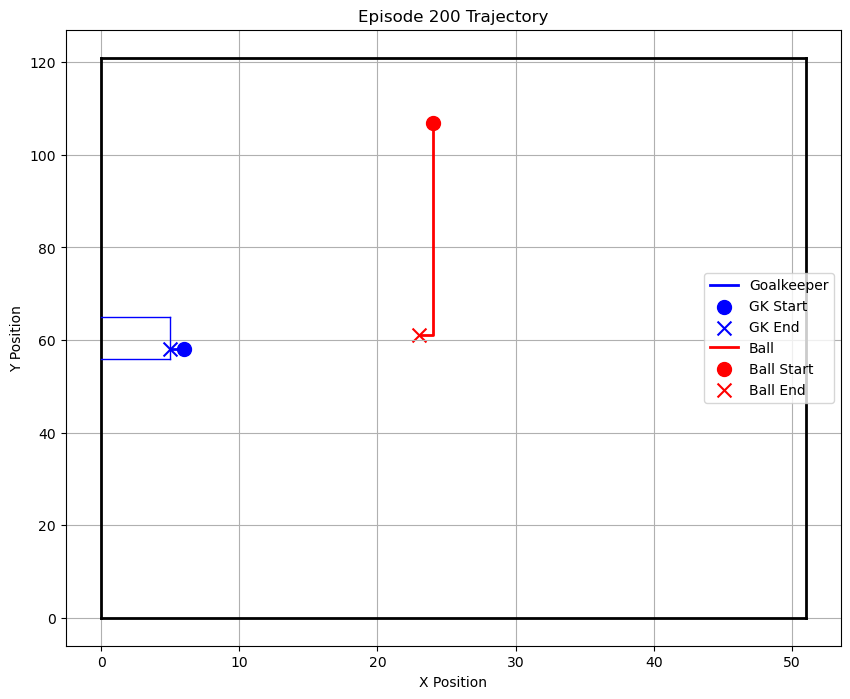

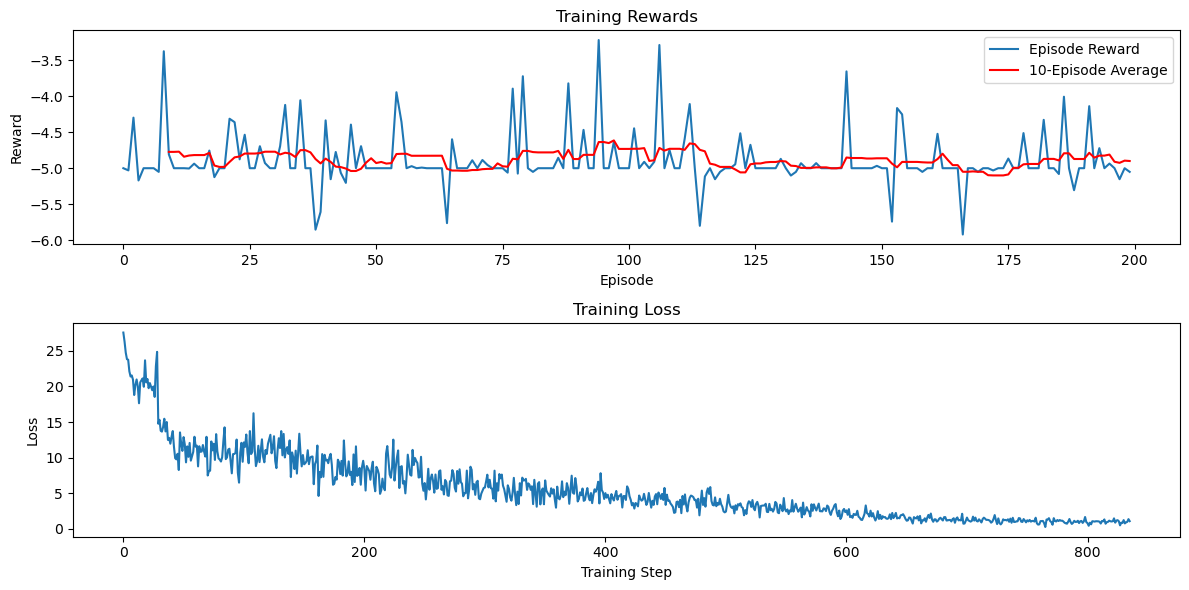

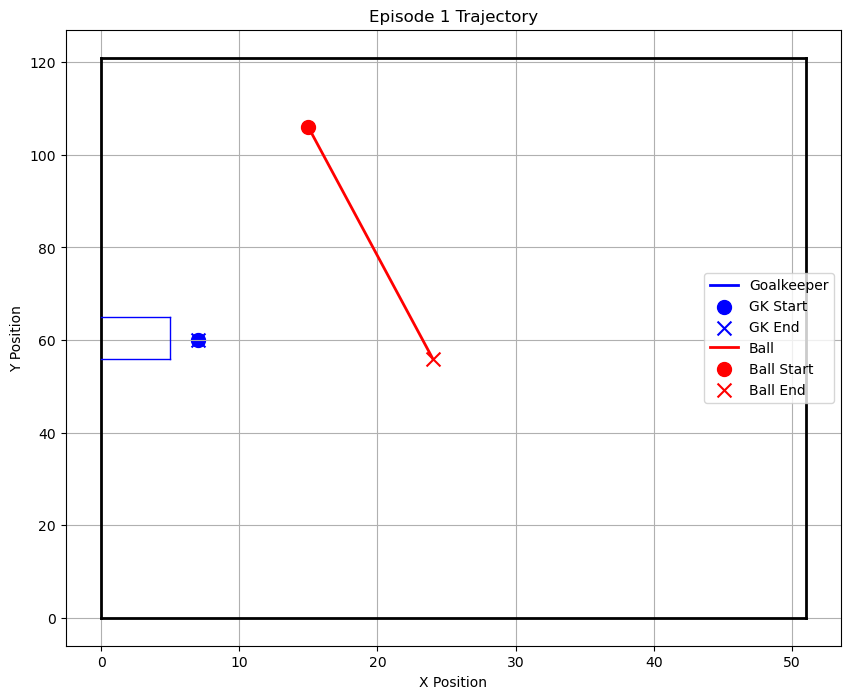

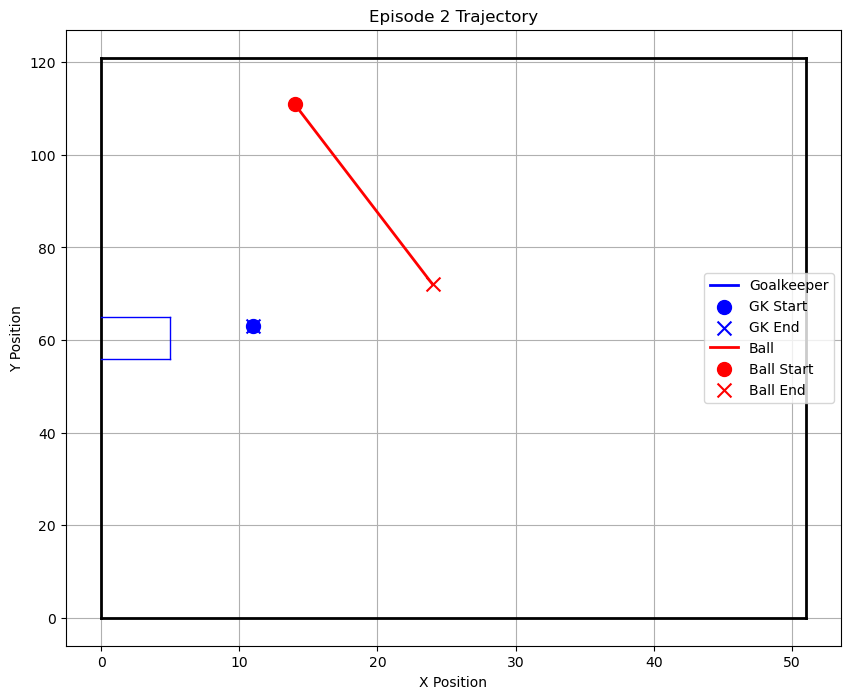

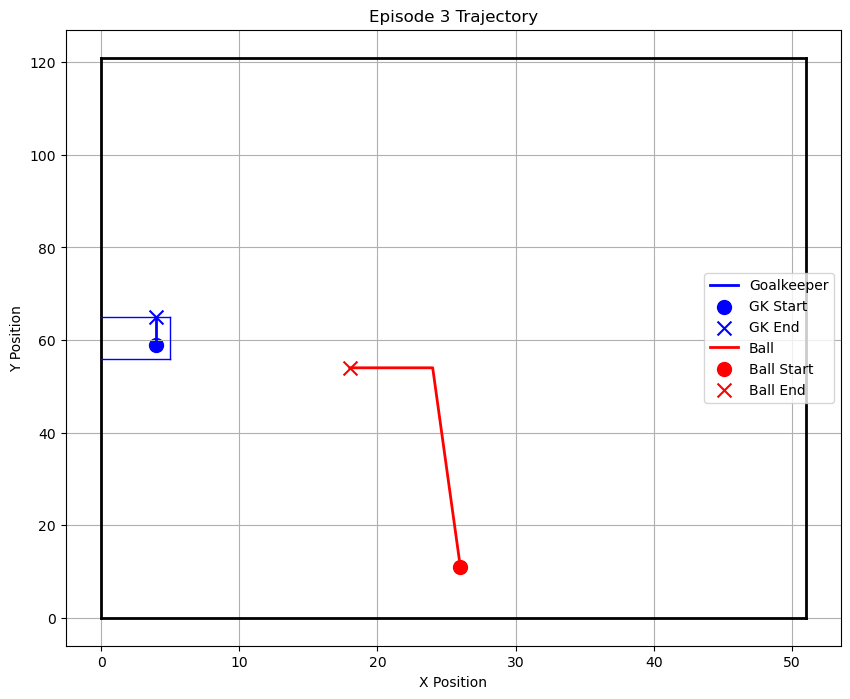

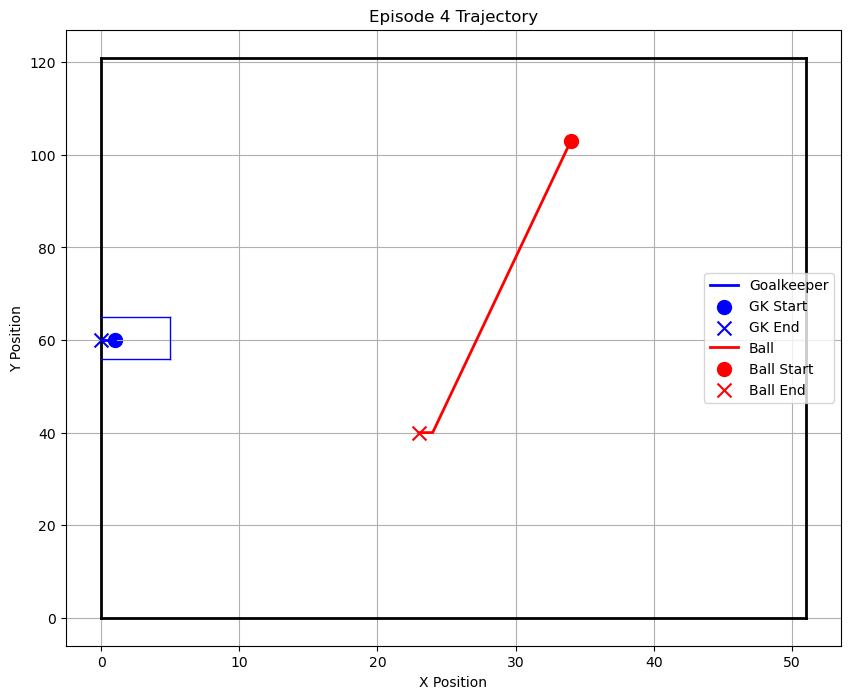

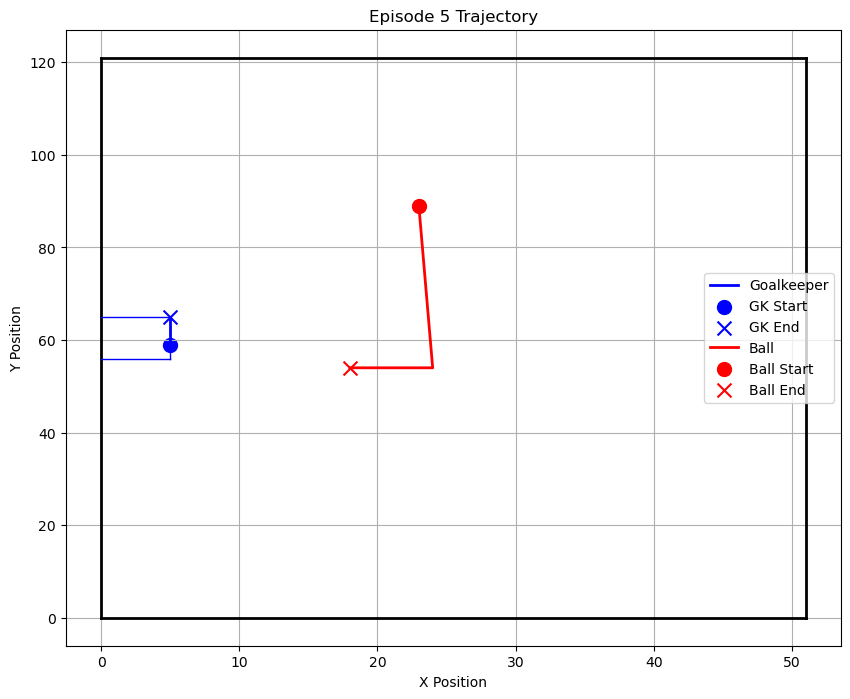

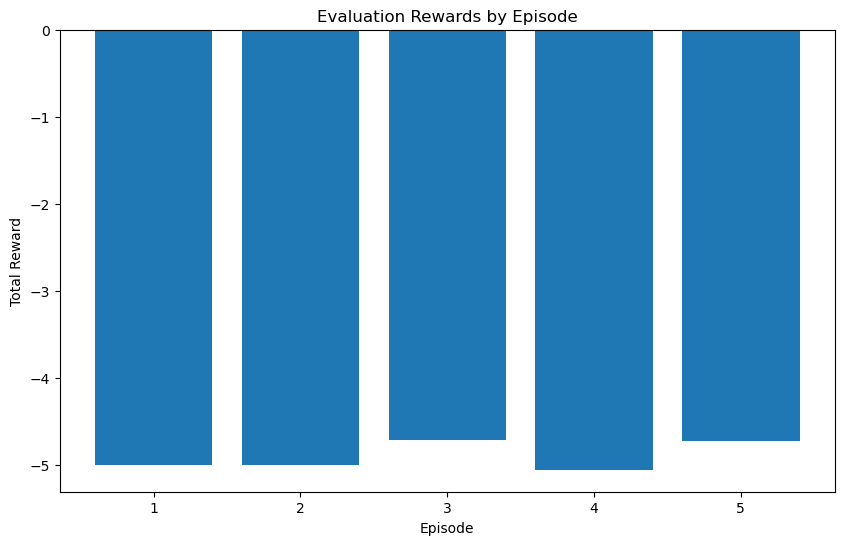

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import gymnasium as gym
from collections import deque
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class FootballEnv(gym.Env):
    def __init__(self, grid_rows=121, grid_cols=51):
        super(FootballEnv, self).__init__()
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols

        self.action_space = gym.spaces.Discrete(10)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(7,), dtype=np.float32)
        self.layout = np.zeros((grid_rows, grid_cols), dtype=str)
        self.layout[:, :] = "."
        self.layout[self.grid_rows//2, self.grid_cols//2] = "C"
        self.layout[self.grid_rows//2-8 : self.grid_rows//2+9, -6:-1] = "D"
        self.layout[self.grid_rows//2-8 : self.grid_rows//2+9, 0:5] = "d"
        self.layout[:, self.grid_cols//2] = "M"
        self.layout[:, -1] = "O"
        self.layout[:, 0] = "O"
        self.layout[0, :] = "O"
        self.layout[-1, :] = "O"
        self.layout[self.grid_rows//2-4 : self.grid_rows//2+5, -1] = "G"
        self.layout[self.grid_rows//2-4 : self.grid_rows//2+5, 0] = "g"
        self.ball_pos = (self.grid_rows//2, self.grid_cols//2)
        self.episode_steps = 0
        
        # Store history for visualization
        self.trajectory = []

    def _get_state(self, player, players):
        # Enhanced state representation
        # 1. Relative position of ball to goalkeeper (x, y)
        rel_pos_x = (self.ball_pos[0] - player.position[0]) / self.grid_rows
        rel_pos_y = (self.ball_pos[1] - player.position[1]) / self.grid_cols
        
        # 2. Distance to ball (normalized)
        dist_to_ball = np.linalg.norm(np.array(player.position) - np.array(self.ball_pos))
        norm_dist = min(1.0, dist_to_ball / max(self.grid_rows, self.grid_cols))
        
        # 3. Position in the field (normalized)
        norm_pos_x = player.position[0] / self.grid_rows
        norm_pos_y = player.position[1] / self.grid_cols
        
        same_team = []
        other_team = []
        for play in players:
            if player.team == play.team and play != player:
                same_team.extend([play.position[0]/self.grid_rows, play.position[1]/self.grid_cols])
            elif player.team != play.team:
                other_team.extend([play.position[0]/self.grid_rows, play.position[1]/self.grid_cols])
        
        # Ensure we have consistent state size
        while len(same_team) < 2:
            same_team.extend([-1, -1])
        while len(other_team) < 2:
            other_team.extend([-1, -1])
        
        return np.array([
            rel_pos_x,      # Relative X position of ball
            rel_pos_y,      # Relative Y position of ball
            norm_dist,      # Normalized distance to ball
            norm_pos_x,     # Normalized GK X position
            norm_pos_y,     # Normalized GK Y position
            float(player.has_ball),  # Whether GK has the ball
            dist_to_ball    # Actual distance to ball (for reward calculation)
        ], dtype=np.float32)

    def reset(self, players, seed=None, options=None):
        super().reset(seed=seed)

        occupied_positions = set()
        for player in players:
            while True:
                if player.team == 0:
                    player_row = random.randint(self.grid_rows // 2 - 3, self.grid_rows // 2 + 3)
                    player_col = random.randint(1, self.grid_cols // 4)
                elif player.role == "GK":
                    if player.team == 0:
                        player_row = self.grid_rows // 2
                        player_col = 1
                    else: 
                        player_row = self.grid_rows // 2
                        player_col = self.grid_cols - 2
                else:
                    player_row = random.randint(self.grid_rows // 2 - 3, self.grid_rows // 2 + 3)
                    player_col = random.randint(3 * self.grid_cols // 4, self.grid_cols - 2)

                if (player_row, player_col) not in occupied_positions:
                    occupied_positions.add((player_row, player_col))
                    player.position = (player_row, player_col)
                    break

        while True:
            ball_row = random.randint(1, self.grid_rows - 2)  # Avoid boundary walls
            ball_col = random.randint(self.grid_cols // 4, 3 * self.grid_cols // 4)  # Avoid goalposts

            if (ball_row, ball_col) not in occupied_positions:
                self.ball_pos = (ball_row, ball_col)
                break
        
        self.episode_steps = 0
        self.trajectory = []  # Reset trajectory for new episode
        
        # Add initial positions to trajectory
        for player in players:
            self.trajectory.append({
                'player_pos': player.position,
                'ball_pos': self.ball_pos,
                'has_ball': player.has_ball
            })
            
        return self._get_state(players[0], players), {}

    def step_goalkeeper(self, action, player, players):
        self.episode_steps += 1
        reward = -0.001  # Small penalty for each step to encourage efficiency
        done = False  # Episode ends only on success or failure

        # Record position before movement
        old_position = player.position
        old_dist_to_ball = np.linalg.norm(np.array(old_position) - np.array(self.ball_pos))

        # Move the ball towards the goalkeeper (left)
        ball_dx = 0
        ball_dy = -1  # Move left
        new_ball_pos = (self.ball_pos[0] + ball_dx, self.ball_pos[1] + ball_dy)

        # Ensure the ball stays in bounds
        if 0 < new_ball_pos[1] < self.grid_cols - 1:
            self.ball_pos = new_ball_pos

        # Check if the ball is in the goal
        if self.layout[self.ball_pos[0], self.ball_pos[1]] == 'G':
            reward = player.goal_conceded  # Penalty for conceding a goal
            done = True  # End the episode if the ball enters the goal

        # Handle goalkeeper movement (8 directions)
        if action < 8:  # Movement actions in 8 directions
            # Movement vectors for all 8 directions
            dx, dy = [(0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1)][action]
            new_pos = (player.position[0] + dx, player.position[1] + dy)
            
            # Check if the new position is within the D box
            if player.team == 0:  # Left-side goalkeeper
                d_box_min_col, d_box_max_col = 0, 5
                d_box_min_row, d_box_max_row = self.grid_rows // 2 - 4, self.grid_rows // 2 + 5
            else:  # Right-side goalkeeper
                d_box_min_col, d_box_max_col = self.grid_cols - 6, self.grid_cols - 1
                d_box_min_row, d_box_max_row = self.grid_rows // 2 - 4, self.grid_rows // 2 + 5

            is_inside_d_box = (d_box_min_row <= new_pos[0] <= d_box_max_row) and (d_box_min_col <= new_pos[1] <= d_box_max_col)

            if is_inside_d_box:
                player.prev_position = player.position
                player.position = new_pos
                if player.has_ball:
                    self.ball_pos = new_pos
                
                # Calculate new distance to ball
                new_dist_to_ball = np.linalg.norm(np.array(player.position) - np.array(self.ball_pos))
                
                # Reward based on movement relative to ball
                if new_dist_to_ball < old_dist_to_ball:
                    reward += 0.1 * (old_dist_to_ball - new_dist_to_ball)  # Reward for moving closer to ball
                else:
                    reward -= 0.05  # Small penalty for moving away from ball
            else:
                reward = player.ball_lost  # Penalty for moving out of the D box
                done = True  # End episode if the goalkeeper moves out of the D box

        # Check if the goalkeeper catches the ball
        if action == 8:  # Block/catch action
            dist_to_ball = np.linalg.norm(np.array(player.position) - np.array(self.ball_pos))
            
            if dist_to_ball <= 2:  # Close enough to block
                player.has_ball = True
                self.ball_pos = player.position  # Ball is now with the GK
                reward = player.block_reward + player.ball_held  # Large reward for successful block
                done = True  # End episode when GK successfully blocks
            else:
                reward -= 1.0  # Penalty for trying to block when ball is too far
        
        # Record the new position for visualization
        self.trajectory.append({
            'player_pos': player.position,
            'ball_pos': self.ball_pos,
            'has_ball': player.has_ball
        })
        
        truncated = self.episode_steps >= 100  # Limit episode length
        return self._get_state(player, players), reward, done, truncated, {}

    def render(self, players):
        grid = np.full((self.grid_rows, self.grid_cols), '-')
        
        # Draw field elements
        for i in range(self.grid_rows):
            for j in range(self.grid_cols):
                if self.layout[i,j] == 'O':
                    grid[i,j] = '#'
                elif self.layout[i,j] == 'G':
                    grid[i,j] = '|'
                elif self.layout[i,j] == 'M':
                    grid[i,j] = '.'

        grid[self.ball_pos[0], self.ball_pos[1]] = 'B'
        
        # Draw player and ball
        for player in players:
            if player.team == 0:
                grid[player.position[0], player.position[1]] = 'P'
            else:
                grid[player.position[0], player.position[1]] = 'Q'
        
        # Print the grid
        print('-' * (self.grid_cols + 2))
        for row in grid:
            print('|' + ''.join(row) + '|')
        print('-' * (self.grid_cols + 2))

    def plot_trajectory(self, episode_num):
        """Plot the trajectory of the goalkeeper and ball for visualization"""
        plt.figure(figsize=(10, 8))
        
        # Extract positions
        goalkeeper_positions = [t['player_pos'] for t in self.trajectory]
        ball_positions = [t['ball_pos'] for t in self.trajectory]
        has_ball = [t['has_ball'] for t in self.trajectory]
        
        # Plot field boundaries
        plt.plot([0, 0], [0, self.grid_rows], 'k-', linewidth=2)  # Left boundary
        plt.plot([self.grid_cols, self.grid_cols], [0, self.grid_rows], 'k-', linewidth=2)  # Right boundary
        plt.plot([0, self.grid_cols], [0, 0], 'k-', linewidth=2)  # Bottom boundary
        plt.plot([0, self.grid_cols], [self.grid_rows, self.grid_rows], 'k-', linewidth=2)  # Top boundary
        
        # Plot penalty box
        d_box_min_row, d_box_max_row = self.grid_rows // 2 - 4, self.grid_rows // 2 + 5
        plt.plot([0, 5], [d_box_min_row, d_box_min_row], 'b-', linewidth=1)  # Top of D box
        plt.plot([0, 5], [d_box_max_row, d_box_max_row], 'b-', linewidth=1)  # Bottom of D box
        plt.plot([5, 5], [d_box_min_row, d_box_max_row], 'b-', linewidth=1)  # Right side of D box
        
        # Plot trajectories
        gk_x = [pos[1] for pos in goalkeeper_positions]
        gk_y = [pos[0] for pos in goalkeeper_positions]
        ball_x = [pos[1] for pos in ball_positions]
        ball_y = [pos[0] for pos in ball_positions]
        
        # Plot goalkeeper trajectory
        plt.plot(gk_x, gk_y, 'b-', linewidth=2, label='Goalkeeper')
        plt.scatter(gk_x[0], gk_y[0], color='blue', s=100, marker='o', label='GK Start')
        plt.scatter(gk_x[-1], gk_y[-1], color='blue', s=100, marker='x', label='GK End')
        
        # Plot ball trajectory
        plt.plot(ball_x, ball_y, 'r-', linewidth=2, label='Ball')
        plt.scatter(ball_x[0], ball_y[0], color='red', s=100, marker='o', label='Ball Start')
        plt.scatter(ball_x[-1], ball_y[-1], color='red', s=100, marker='x', label='Ball End')
        
        # Mark where the goalkeeper caught the ball (if applicable)
        if any(has_ball):
            catch_idx = has_ball.index(True)
            plt.scatter(gk_x[catch_idx], gk_y[catch_idx], color='green', s=200, marker='*', label='Ball Caught')
        
        plt.title(f'Episode {episode_num} Trajectory')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.legend()
        plt.grid(True)
        
        return plt.gcf()  # Return the figure for saving


class Player():
    def __init__(self, role, team, env):
        self.role = role
        self.team = team
        self.position = [random.randint(env.grid_rows//2-3, env.grid_rows//2+3),random.randint(1, env.grid_cols//4)]
        self.prev_position = []
        self.prev_ball_statues = False
        self.has_ball = False
        self.goal_reward = 52
        self.step_penalty = -0.001
        self.ball_possession_bonus = 0.008
        self.near_ball_bonus = 0.00001
        self.near_goal_bonus = 0.00002
        # Goalkeeper specific rewards   
        self.block_reward = 30 
        self.pass_reward = 1 
        self.ball_lost = -5
        self.ball_held = 5
        self.goal_conceded = -50


class DQN(nn.Module):
    def __init__(self, input_dim, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_size)
        
        # Initialize weights with better defaults
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0003
        self.memory = deque(maxlen=100000)
        self.batch_size = 64  # Reduced batch size for faster training
        self.target_update_freq = 10  # Update target network every N episodes
        
        # Action-specific exploration rates to encourage movement
        self.action_epsilon = np.ones(action_size) * 0.1
        self.action_epsilon[8] = 0.05  # Lower epsilon for the block action
        
        self.device = device
        self.model = DQN(state_size, action_size).to(self.device)
        self.target_model = DQN(state_size, action_size).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        self.rewards_history = []
        self.episode_count = 0
        self.loss_history = []  # Track loss for plotting

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, evaluate=False):
        if not evaluate and np.random.rand() <= self.epsilon:
            # Bias exploration toward movement actions
            if np.random.rand() < 0.8:  # 80% chance to choose movement when exploring
                return random.randrange(8)  # Only choose from movement actions
            else:
                return random.randrange(self.action_size)
        
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
            
            # Add small noise to q-values to break ties randomly
            if not evaluate:
                q_values = q_values + torch.randn_like(q_values) * 0.01
                
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0
            
        minibatch = random.sample(self.memory, self.batch_size)
    
        states = torch.FloatTensor(np.array([experience[0] for experience in minibatch])).to(self.device)
        actions = torch.LongTensor([experience[1] for experience in minibatch]).to(self.device)
        rewards = torch.FloatTensor([experience[2] for experience in minibatch]).to(self.device)
        next_states = torch.FloatTensor(np.array([experience[3] for experience in minibatch])).to(self.device)
        dones = torch.FloatTensor([experience[4] for experience in minibatch]).to(self.device)
    
        curr_q_values = self.model(states).gather(1, actions.unsqueeze(1))
    
        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1)[0]
    
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
    
        loss = F.mse_loss(curr_q_values.squeeze(), target_q_values)
    
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)  
        self.optimizer.step()
    
        return loss.item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def train_goalkeeper_agent(env, episodes, max_steps):
    # Create a goalkeeper for one team
    players = [Player('GK', 0, env)]
    
    # Verify state size before creating agent
    sample_state = env._get_state(players[0], players)
    print(f"State size: {len(sample_state)}")
    
    # Create a DQN agent for the goalkeeper
    agent = DQNAgent(len(sample_state), 9)  # 9 possible actions (8 movements + block)
    
    all_rewards = []  # Track rewards for plotting
    avg_rewards = []   # Track average rewards
    
    for episode in range(episodes):
        # Reset the environment
        env.reset(players)
        
        # Start the ball at a random position in the field
        ball_start_col = env.grid_cols // 2
        ball_start_row = random.randint(env.grid_rows // 4, 3 * env.grid_rows // 4)
        env.ball_pos = (ball_start_row, ball_start_col)
        
        total_reward = 0
        done = False
        truncated = False
        loss = 0
        
        for step in range(max_steps):
            if done or truncated:
                break
            
            # Get the goalkeeper's state
            state = env._get_state(players[0], players)
            
            # Choose action
            action = agent.act(state)
            
            # Step the goalkeeper
            next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
            
            # Remember the experience
            agent.remember(state, action, reward, next_state, done or truncated)
            
            # Replay (learn from experiences)
            if len(agent.memory) >= agent.batch_size:
                loss = agent.replay()
                agent.loss_history.append(loss)
            
            total_reward += reward
            
        # Decay exploration, update target network
        agent.episode_count += 1
        if agent.episode_count % agent.target_update_freq == 0:
            agent.update_target_model()
        agent.decay_epsilon()
        
        # Track rewards
        agent.rewards_history.append(total_reward)
        all_rewards.append(total_reward)
        
        # Calculate average reward over last 10 episodes
        if episode >= 9:
            avg_reward = sum(all_rewards[-10:]) / 10
            avg_rewards.append(avg_reward)
            
        # Print progress
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}: Total Reward = {total_reward:.4f}, Epsilon = {agent.epsilon:.3f}")
        
        # Save a visualization of the last episode trajectory
        if episode == episodes - 1:
            fig = env.plot_trajectory(episode+1)
            plt.savefig('final_trajectory.png')
    
    # Plot training progress
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(all_rewards)
    plt.plot(range(9, episodes), avg_rewards, 'r-')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend(['Episode Reward', '10-Episode Average'])
    
    plt.subplot(2, 1, 2)
    plt.plot(agent.loss_history)
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    
    plt.tight_layout()
    plt.savefig('training_progress.png')
    
    return agent

def evaluate_goalkeeper_agent(agent, env, episodes=5, max_steps=100, render=True):
    # Create a goalkeeper
    players = [Player('GK', 0, env)]
    
    episode_rewards = []
    
    for episode in range(episodes):
        # Reset the environment
        env.reset(players)
        
        # Start the ball at a random position
        ball_start_col = env.grid_cols // 2
        ball_start_row = random.randint(env.grid_rows // 4, 3 * env.grid_rows // 4)
        env.ball_pos = (ball_start_row, ball_start_col)
        
        total_reward = 0
        done = False
        truncated = False
        
        for step in range(max_steps):
            if done or truncated:
                if render:
                    env.render(players)
                break
            
            # Render the environment
            if render:
                env.render(players)
                time.sleep(0.2)  # Slow down rendering for better visualization
            
            # Get the goalkeeper's state
            state = env._get_state(players[0], players)
            
            # Choose action (no exploration during evaluation)
            action = agent.act(state, evaluate=True)
            print(f"Action chosen: {action}")
            
            # Step the goalkeeper
            next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
            
            total_reward += reward
        
        # Save trajectory plot
        fig = env.plot_trajectory(episode+1)
        plt.savefig(f'evaluation_episode_{episode+1}.png')
        
        episode_rewards.append(total_reward)
        
        print(f"Evaluation Episode {episode+1}: Total Reward = {total_reward}")
    
    # Calculate and print the average reward
    avg_reward = np.mean(episode_rewards)
    print(f"Average Reward across {episodes} episodes: {avg_reward}")
    
    # Plot reward distribution
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, episodes+1), episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Evaluation Rewards by Episode')
    plt.savefig('evaluation_rewards.png')
    
    return avg_reward

# Set reproducible seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create environment
env = FootballEnv()

# Train goalkeeper (with fewer episodes for faster training)
print("Training goalkeeper agent...")
trained_goalkeeper_agent = train_goalkeeper_agent(env, episodes=200, max_steps=100)

# Evaluate goalkeeper
print("\nEvaluating goalkeeper agent...")
evaluate_goalkeeper_agent(trained_goalkeeper_agent, env, episodes=5, max_steps=50, render=True)

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import gymnasium as gym
from collections import deque
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class FootballEnv(gym.Env):
    def __init__(self, grid_rows=121, grid_cols=51):
        super(FootballEnv, self).__init__()
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols

        self.action_space = gym.spaces.Discrete(10)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(7,), dtype=np.float32)
        self.layout = np.zeros((grid_rows, grid_cols), dtype=str)
        self.layout[:, :] = "."
        self.layout[self.grid_rows//2, self.grid_cols//2] = "C"
        self.layout[self.grid_rows//2-8 : self.grid_rows//2+9, -6:-1] = "D"
        self.layout[self.grid_rows//2-8 : self.grid_rows//2+9, 0:5] = "d"
        self.layout[:, self.grid_cols//2] = "M"
        self.layout[:, -1] = "O"
        self.layout[:, 0] = "O"
        self.layout[0, :] = "O"
        self.layout[-1, :] = "O"
        self.layout[self.grid_rows//2-4 : self.grid_rows//2+5, -1] = "G"
        self.layout[self.grid_rows//2-4 : self.grid_rows//2+5, 0] = "g"
        self.ball_pos = (self.grid_rows//2, self.grid_cols//2)
        self.episode_steps = 0
        
        # Store history for visualization
        self.trajectory = []

    def _get_state(self, player, players):
        # Enhanced state representation
        # 1. Relative position of ball to goalkeeper (x, y)
        rel_pos_x = (self.ball_pos[0] - player.position[0]) / self.grid_rows
        rel_pos_y = (self.ball_pos[1] - player.position[1]) / self.grid_cols
        
        # 2. Distance to ball (normalized)
        dist_to_ball = np.linalg.norm(np.array(player.position) - np.array(self.ball_pos))
        norm_dist = min(1.0, dist_to_ball / max(self.grid_rows, self.grid_cols))
        
        # 3. Position in the field (normalized)
        norm_pos_x = player.position[0] / self.grid_rows
        norm_pos_y = player.position[1] / self.grid_cols
        
        same_team = []
        other_team = []
        for play in players:
            if player.team == play.team and play != player:
                same_team.extend([play.position[0]/self.grid_rows, play.position[1]/self.grid_cols])
            elif player.team != play.team:
                other_team.extend([play.position[0]/self.grid_rows, play.position[1]/self.grid_cols])
        
        # Ensure we have consistent state size
        while len(same_team) < 2:
            same_team.extend([-1, -1])
        while len(other_team) < 2:
            other_team.extend([-1, -1])
        
        return np.array([
            rel_pos_x,      # Relative X position of ball
            rel_pos_y,      # Relative Y position of ball
            norm_dist,      # Normalized distance to ball
            norm_pos_x,     # Normalized GK X position
            norm_pos_y,     # Normalized GK Y position
            float(player.has_ball),  # Whether GK has the ball
            dist_to_ball    # Actual distance to ball (for reward calculation)
        ], dtype=np.float32)

    def reset(self, players, ball_spawn_radius=None, seed=None, options=None):
        super().reset(seed=seed)

        occupied_positions = set()
        for player in players:
            while True:
                if player.team == 0:
                    if player.role == "GK":
                        # Fixed goalkeeper position at left side of D-box
                        player_row = self.grid_rows // 2
                        player_col = 2  # Close to goal
                    else:
                        player_row = random.randint(self.grid_rows // 2 - 3, self.grid_rows // 2 + 3)
                        player_col = random.randint(1, self.grid_cols // 4)
                else: 
                    if player.role == "GK":
                        player_row = self.grid_rows // 2
                        player_col = self.grid_cols - 2
                    else:
                        player_row = random.randint(self.grid_rows // 2 - 3, self.grid_rows // 2 + 3)
                        player_col = random.randint(3 * self.grid_cols // 4, self.grid_cols - 2)

                if (player_row, player_col) not in occupied_positions:
                    occupied_positions.add((player_row, player_col))
                    player.position = (player_row, player_col)
                    break

        # Reset ball position based on curriculum radius
        if ball_spawn_radius is not None:
            # Get the goalkeeper position (assume it's the first player)
            gk_pos = players[0].position
            
            while True:
                # Generate random angle
                angle = random.uniform(0, 2 * np.pi)
                
                # Determine radius (or use fixed radius for curriculum)
                # Add random variation within the allowed radius
                radius = random.uniform(1, ball_spawn_radius)
                
                # Calculate ball position around the goalkeeper
                ball_row = int(gk_pos[0] + radius * np.sin(angle))
                ball_col = int(gk_pos[1] + radius * np.cos(angle))
                
                # Ensure it's within bounds and in appropriate range
                if (0 < ball_row < self.grid_rows - 1 and 
                    0 < ball_col < self.grid_cols - 1 and
                    (ball_row, ball_col) not in occupied_positions):
                    self.ball_pos = (ball_row, ball_col)
                    break
        else:
            # Default ball positioning (center field)
            while True:
                ball_row = random.randint(1, self.grid_rows - 2)
                ball_col = random.randint(self.grid_cols // 4, 3 * self.grid_cols // 4)
                
                if (ball_row, ball_col) not in occupied_positions:
                    self.ball_pos = (ball_row, ball_col)
                    break
        
        self.episode_steps = 0
        self.trajectory = []  # Reset trajectory for new episode
        
        # Add initial positions to trajectory
        for player in players:
            self.trajectory.append({
                'player_pos': player.position,
                'ball_pos': self.ball_pos,
                'has_ball': player.has_ball
            })
            
        return self._get_state(players[0], players), {}

    def step_goalkeeper(self, action, player, players):
        self.episode_steps += 1
        reward = -0.001  # Small penalty for each step to encourage efficiency
        done = False  # Episode ends only on success or failure

        # Record position before movement
        old_position = player.position
        old_dist_to_ball = np.linalg.norm(np.array(old_position) - np.array(self.ball_pos))

        # Move the ball towards the goalkeeper (left) - disabled for curriculum training
        # We're keeping the ball stationary in this version so the keeper can learn to go to it
        # ball_dx = 0
        # ball_dy = -1  # Move left
        # new_ball_pos = (self.ball_pos[0] + ball_dx, self.ball_pos[1] + ball_dy)
        # 
        # if 0 < new_ball_pos[1] < self.grid_cols - 1:
        #     self.ball_pos = new_ball_pos

        # Check if the ball is in the goal
        if self.layout[self.ball_pos[0], self.ball_pos[1]] == 'G':
            reward = player.goal_conceded  # Penalty for conceding a goal
            done = True  # End the episode if the ball enters the goal

        # Handle goalkeeper movement (8 directions)
        if action < 8:  # Movement actions in 8 directions
            # Movement vectors for all 8 directions
            dx, dy = [(0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1)][action]
            new_pos = (player.position[0] + dx, player.position[1] + dy)
            
            # Check if the new position is within the D box
            if player.team == 0:  # Left-side goalkeeper
                d_box_min_col, d_box_max_col = 0, 5
                d_box_min_row, d_box_max_row = self.grid_rows // 2 - 4, self.grid_rows // 2 + 5
            else:  # Right-side goalkeeper
                d_box_min_col, d_box_max_col = self.grid_cols - 6, self.grid_cols - 1
                d_box_min_row, d_box_max_row = self.grid_rows // 2 - 4, self.grid_rows // 2 + 5

            is_inside_d_box = (d_box_min_row <= new_pos[0] <= d_box_max_row) and (d_box_min_col <= new_pos[1] <= d_box_max_col)

            if is_inside_d_box:
                player.prev_position = player.position
                player.position = new_pos
                if player.has_ball:
                    self.ball_pos = new_pos
                
                # Calculate new distance to ball
                new_dist_to_ball = np.linalg.norm(np.array(player.position) - np.array(self.ball_pos))
                
                # Reward based on movement relative to ball
                if new_dist_to_ball < old_dist_to_ball:
                    reward += 0.2 * (old_dist_to_ball - new_dist_to_ball)  # Increased reward for moving closer to ball
                else:
                    reward -= 0.1  # Small penalty for moving away from ball
            else:
                reward = player.ball_lost  # Penalty for moving out of the D box
                done = True  # End episode if the goalkeeper moves out of the D box

        # Check if the goalkeeper catches the ball
        if action == 8:  # Block/catch action
            dist_to_ball = np.linalg.norm(np.array(player.position) - np.array(self.ball_pos))
            
            if dist_to_ball <= 2:  # Close enough to block
                player.has_ball = True
                self.ball_pos = player.position  # Ball is now with the GK
                reward = player.block_reward + player.ball_held  # Large reward for successful block
                done = True  # End episode when GK successfully blocks
            else:
                reward -= 1.0  # Penalty for trying to block when ball is too far
        
        # Record the new position for visualization
        self.trajectory.append({
            'player_pos': player.position,
            'ball_pos': self.ball_pos,
            'has_ball': player.has_ball
        })
        
        truncated = self.episode_steps >= 100  # Limit episode length
        return self._get_state(player, players), reward, done, truncated, {}

    def render(self, players):
        grid = np.full((self.grid_rows, self.grid_cols), '-')
        
        # Draw field elements
        for i in range(self.grid_rows):
            for j in range(self.grid_cols):
                if self.layout[i,j] == 'O':
                    grid[i,j] = '#'
                elif self.layout[i,j] == 'G':
                    grid[i,j] = '|'
                elif self.layout[i,j] == 'M':
                    grid[i,j] = '.'

        grid[self.ball_pos[0], self.ball_pos[1]] = 'B'
        
        # Draw player and ball
        for player in players:
            if player.team == 0:
                grid[player.position[0], player.position[1]] = 'P'
            else:
                grid[player.position[0], player.position[1]] = 'Q'
        
        # Print the grid
        print('-' * (self.grid_cols + 2))
        for row in grid:
            print('|' + ''.join(row) + '|')
        print('-' * (self.grid_cols + 2))

    def plot_trajectory(self, episode_num):
        """Plot the trajectory of the goalkeeper and ball for visualization"""
        plt.figure(figsize=(10, 8))
        
        # Extract positions
        goalkeeper_positions = [t['player_pos'] for t in self.trajectory]
        ball_positions = [t['ball_pos'] for t in self.trajectory]
        has_ball = [t['has_ball'] for t in self.trajectory]
        
        # Plot field boundaries
        plt.plot([0, 0], [0, self.grid_rows], 'k-', linewidth=2)  # Left boundary
        plt.plot([self.grid_cols, self.grid_cols], [0, self.grid_rows], 'k-', linewidth=2)  # Right boundary
        plt.plot([0, self.grid_cols], [0, 0], 'k-', linewidth=2)  # Bottom boundary
        plt.plot([0, self.grid_cols], [self.grid_rows, self.grid_rows], 'k-', linewidth=2)  # Top boundary
        
        # Plot penalty box
        d_box_min_row, d_box_max_row = self.grid_rows // 2 - 4, self.grid_rows // 2 + 5
        plt.plot([0, 5], [d_box_min_row, d_box_min_row], 'b-', linewidth=1)  # Top of D box
        plt.plot([0, 5], [d_box_max_row, d_box_max_row], 'b-', linewidth=1)  # Bottom of D box
        plt.plot([5, 5], [d_box_min_row, d_box_max_row], 'b-', linewidth=1)  # Right side of D box
        
        # Plot trajectories
        gk_x = [pos[1] for pos in goalkeeper_positions]
        gk_y = [pos[0] for pos in goalkeeper_positions]
        ball_x = [pos[1] for pos in ball_positions]
        ball_y = [pos[0] for pos in ball_positions]
        
        # Plot goalkeeper trajectory
        plt.plot(gk_x, gk_y, 'b-', linewidth=2, label='Goalkeeper')
        plt.scatter(gk_x[0], gk_y[0], color='blue', s=100, marker='o', label='GK Start')
        plt.scatter(gk_x[-1], gk_y[-1], color='blue', s=100, marker='x', label='GK End')
        
        # Plot ball trajectory
        plt.plot(ball_x, ball_y, 'r-', linewidth=2, label='Ball')
        plt.scatter(ball_x[0], ball_y[0], color='red', s=100, marker='o', label='Ball Start')
        plt.scatter(ball_x[-1], ball_y[-1], color='red', s=100, marker='x', label='Ball End')
        
        # Mark where the goalkeeper caught the ball (if applicable)
        if any(has_ball):
            catch_idx = has_ball.index(True)
            plt.scatter(gk_x[catch_idx], gk_y[catch_idx], color='green', s=200, marker='*', label='Ball Caught')
        
        plt.title(f'Episode {episode_num} Trajectory')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.legend()
        plt.grid(True)
        
        return plt.gcf()  # Return the figure for saving


class Player():
    def __init__(self, role, team, env):
        self.role = role
        self.team = team
        self.position = [random.randint(env.grid_rows//2-3, env.grid_rows//2+3),random.randint(1, env.grid_cols//4)]
        self.prev_position = []
        self.prev_ball_statues = False
        self.has_ball = False
        self.goal_reward = 52
        self.step_penalty = -0.001
        self.ball_possession_bonus = 0.008
        self.near_ball_bonus = 0.00001
        self.near_goal_bonus = 0.00002
        # Goalkeeper specific rewards   
        self.block_reward = 30 
        self.pass_reward = 1 
        self.ball_lost = -5
        self.ball_held = 5
        self.goal_conceded = -50


class DQN(nn.Module):
    def __init__(self, input_dim, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_size)
        
        # Initialize weights with better defaults
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005  # Slightly increased learning rate
        self.memory = deque(maxlen=10000)  # Reduced memory size
        self.batch_size = 64  # Reduced batch size for faster training
        self.target_update_freq = 10  # Update target network every N episodes
        
        # Action-specific exploration rates to encourage movement
        self.action_epsilon = np.ones(action_size) * 0.1
        self.action_epsilon[8] = 0.05  # Lower epsilon for the block action
        
        self.device = device
        self.model = DQN(state_size, action_size).to(self.device)
        self.target_model = DQN(state_size, action_size).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        self.rewards_history = []
        self.episode_count = 0
        self.loss_history = []  # Track loss for plotting
        
        # For curriculum training
        self.success_rate = deque(maxlen=20)  # Track recent success rate

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, evaluate=False):
        if not evaluate and np.random.rand() <= self.epsilon:
            # Bias exploration toward movement actions
            if np.random.rand() < 0.8:  # 80% chance to choose movement when exploring
                return random.randrange(8)  # Only choose from movement actions
            else:
                return random.randrange(self.action_size)
        
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
            
            # Add small noise to q-values to break ties randomly
            if not evaluate:
                q_values = q_values + torch.randn_like(q_values) * 0.01
                
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0
            
        minibatch = random.sample(self.memory, self.batch_size)
    
        states = torch.FloatTensor(np.array([experience[0] for experience in minibatch])).to(self.device)
        actions = torch.LongTensor([experience[1] for experience in minibatch]).to(self.device)
        rewards = torch.FloatTensor([experience[2] for experience in minibatch]).to(self.device)
        next_states = torch.FloatTensor(np.array([experience[3] for experience in minibatch])).to(self.device)
        dones = torch.FloatTensor([experience[4] for experience in minibatch]).to(self.device)
    
        curr_q_values = self.model(states).gather(1, actions.unsqueeze(1))
    
        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1)[0]
    
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
    
        loss = F.mse_loss(curr_q_values.squeeze(), target_q_values)
    
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)  
        self.optimizer.step()
    
        return loss.item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def curriculum_train_goalkeeper(env, episodes=500, stages=5, episodes_per_stage=100, max_steps=50):
    """
    Train goalkeeper using curriculum learning.
    
    Args:
        env: The football environment
        episodes: Total number of episodes for training
        stages: Number of curriculum stages
        episodes_per_stage: Episodes to train at each stage
        max_steps: Maximum steps per episode
    """
    # Create a goalkeeper
    players = [Player('GK', 0, env)]
    
    # Verify state size before creating agent
    sample_state = env._get_state(players[0], players)
    print(f"State size: {len(sample_state)}")
    
    # Create a DQN agent for the goalkeeper
    agent = DQNAgent(len(sample_state), 9)  # 9 possible actions (8 movements + block)
    
    all_rewards = []
    avg_rewards = []
    success_rate_history = []
    
    # Maximum spawn radius will be half the grid size
    max_radius = min(env.grid_rows, env.grid_cols) // 4
    current_stage = 1
    
    for episode in range(episodes):
        # Calculate current radius based on curriculum stage
        current_radius = (current_stage * max_radius) / stages
        
        # Reset the environment with current ball spawn radius
        env.reset(players, ball_spawn_radius=current_radius)
        
        total_reward = 0
        done = False
        truncated = False
        loss = 0
        success = False  # Track if episode was successful (ball caught)
        
        for step in range(max_steps):
            if done or truncated:
                break
            
            # Get the goalkeeper's state
            state = env._get_state(players[0], players)
            
            # Choose action
            action = agent.act(state)
            
            # Step the goalkeeper
            next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
            
            # Remember the experience
            agent.remember(state, action, reward, next_state, done or truncated)
            
            # Replay (learn from experiences)
            if len(agent.memory) >= agent.batch_size:
                loss = agent.replay()
                agent.loss_history.append(loss)
            
            total_reward += reward
            
            # Check if this was a successful catch
            if players[0].has_ball:
                success = True
        
        # Update success tracking
        agent.success_rate.append(1 if success else 0)
        current_success_rate = sum(agent.success_rate) / len(agent.success_rate) if agent.success_rate else 0
        success_rate_history.append(current_success_rate)
        
        # Decay exploration, update target network
        agent.episode_count += 1
        if agent.episode_count % agent.target_update_freq == 0:
            agent.update_target_model()
        agent.decay_epsilon()
        
        # Track rewards
        agent.rewards_history.append(total_reward)
        all_rewards.append(total_reward)
        
        # Calculate average reward over last 10 episodes
        if episode >= 9:
            avg_reward = sum(all_rewards[-10:]) / 10
            avg_rewards.append(avg_reward)
        
        # Check if we should advance to the next curriculum stage
        stage_episode = episode % episodes_per_stage
        if stage_episode == episodes_per_stage - 1:
            # Check success rate to decide if we advance
            recent_success_rate = sum(agent.success_rate) / len(agent.success_rate)
            
            print(f"Stage {current_stage}: Average success rate = {recent_success_rate:.2f}")
            
            # Only advance if success rate is good enough (at least 60%)
            if recent_success_rate >= 0.6 and current_stage < stages:
                current_stage += 1
                print(f"Advancing to stage {current_stage}, new radius = {(current_stage * max_radius) / stages:.1f}")
            
            # Save a visualization at the end of each stage
            fig = env.plot_trajectory(episode + 1)
            plt.savefig(f'stage_{current_stage}_episode_{episode + 1}.png')
            
        # Print progress
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}: Total Reward = {total_reward:.4f}, Success = {success}, " 
                  f"Radius = {current_radius:.1f}, Epsilon = {agent.epsilon:.3f}")
    
    # Plot training progress
    plt.figure(figsize=(12, 8))
    
    # Plot rewards
    plt.subplot(3, 1, 1)
    plt.plot(all_rewards)
    plt.plot(range(9, episodes), avg_rewards, 'r-')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend(['Episode Reward', '10-Episode Average'])
    
    # Plot loss
    plt.subplot(3, 1, 2)
    if agent.loss_history:
        plt.plot(agent.loss_history)
        plt.xlabel('Training Step')
        plt.ylabel('Loss')
        plt.title('Training Loss')
    
    # Plot success rate
    plt.subplot(3, 1, 3)
    plt.plot(success_rate_history)
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.title('Success Rate (Moving Average)')
    
    plt.tight_layout()
    plt.savefig('curriculum_training_progress.png')
    
    return agent


def evaluate_goalkeeper_agent(agent, env, episodes=5, max_steps=50, render=True):
    # Create a goalkeeper
    players = [Player('GK', 0, env)]
    
    episode_rewards = []
    successes = 0
    
    for episode in range(episodes):
        # Reset the environment - use a challenging radius for evaluation
        max_radius = min(env.grid_rows, env.grid_cols) // 4
        env.reset(players, ball_spawn_radius=max_radius)
        
        total_reward = 0
        done = False
        truncated = False
        
        for step in range(max_steps):
            if done or truncated:
                if render:
                    env.render(players)
                break
            
            # Render the environment
            if render:
                env.render(players)
                time.sleep(0.2)  # Slow down rendering for better visualization
            
            # Get the goalkeeper's state
            state = env._get_state(players[0], players)
            
            # Choose action (no exploration during evaluation)
            action = agent.act(state, evaluate=True)
            print(f"Action chosen: {action}")
            
            # Step the goalkeeper
            next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
            
            total_reward += reward
        
        # Check for success (ball caught)
        if players[0].has_ball:
            successes += 1
        
        # Save trajectory plot
        fig = env.plot_trajectory(episode + 1)
        plt.savefig(f'evaluation_episode_{episode + 1}.png')
        
        episode_rewards.append(total_reward)
        
        print(f"Evaluation Episode {episode+1}: Total Reward = {total_reward:.4f}, Success = {players[0].has_ball}")
    
    # Calculate and print the average reward and success rate
    avg_reward = np.mean(episode_rewards)
    success_rate = successes / episodes
    print(f"Average Reward across {episodes} episodes: {avg_reward:.4f}")
    print(f"Success Rate: {success_rate:.2f} ({successes}/{episodes})")
    
    # Plot reward distribution
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, episodes+1), episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title(f'Evaluation Rewards (Success Rate: {success_rate:.2f})')
    plt.savefig('evaluation_rewards.png')
    
    return avg_reward, success_rate

cpu


Starting curriculum training for goalkeeper agent...
State size: 7
Episode 10: Total Reward = -4.9040, Success = True, Radius = 1.5, Epsilon = 0.951
Episode 20: Total Reward = -5.6272, Success = True, Radius = 1.5, Epsilon = 0.905
Episode 30: Total Reward = 35.1990, Success = True, Radius = 1.5, Epsilon = 0.860
Episode 40: Total Reward = 35.1990, Success = True, Radius = 1.5, Epsilon = 0.818
Episode 50: Total Reward = 35.2818, Success = True, Radius = 1.5, Epsilon = 0.778
Episode 60: Total Reward = -6.5738, Success = True, Radius = 1.5, Epsilon = 0.740
Episode 70: Total Reward = -5.6090, Success = True, Radius = 1.5, Epsilon = 0.704
Episode 80: Total Reward = -5.6090, Success = True, Radius = 1.5, Epsilon = 0.670
Episode 90: Total Reward = 35.1808, Success = True, Radius = 1.5, Epsilon = 0.637
Stage 1: Average success rate = 1.00
Advancing to stage 2, new radius = 3.0
Episode 100: Total Reward = 35.1990, Success = True, Radius = 1.5, Epsilon = 0.606
Episode 110: Total Reward = 34.7768,

/tmp/ipykernel_13379/3540547750.py:261: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


Episode 2100: Total Reward = 35.4462, Success = True, Radius = 12.0, Epsilon = 0.050
Episode 2110: Total Reward = 35.4462, Success = True, Radius = 12.0, Epsilon = 0.050
Episode 2120: Total Reward = 35.0980, Success = True, Radius = 12.0, Epsilon = 0.050
Episode 2130: Total Reward = 35.0000, Success = True, Radius = 12.0, Epsilon = 0.050
Episode 2140: Total Reward = 37.1623, Success = True, Radius = 12.0, Epsilon = 0.050
Episode 2150: Total Reward = 36.6115, Success = True, Radius = 12.0, Epsilon = 0.050
Episode 2160: Total Reward = 36.1990, Success = True, Radius = 12.0, Epsilon = 0.050
Episode 2170: Total Reward = 35.1990, Success = True, Radius = 12.0, Epsilon = 0.050
Episode 2180: Total Reward = 36.6115, Success = True, Radius = 12.0, Epsilon = 0.050
Episode 2190: Total Reward = 36.6115, Success = True, Radius = 12.0, Epsilon = 0.050
Stage 8: Average success rate = 1.00
Episode 2200: Total Reward = 36.5222, Success = True, Radius = 12.0, Epsilon = 0.050
Episode 2210: Total Reward =

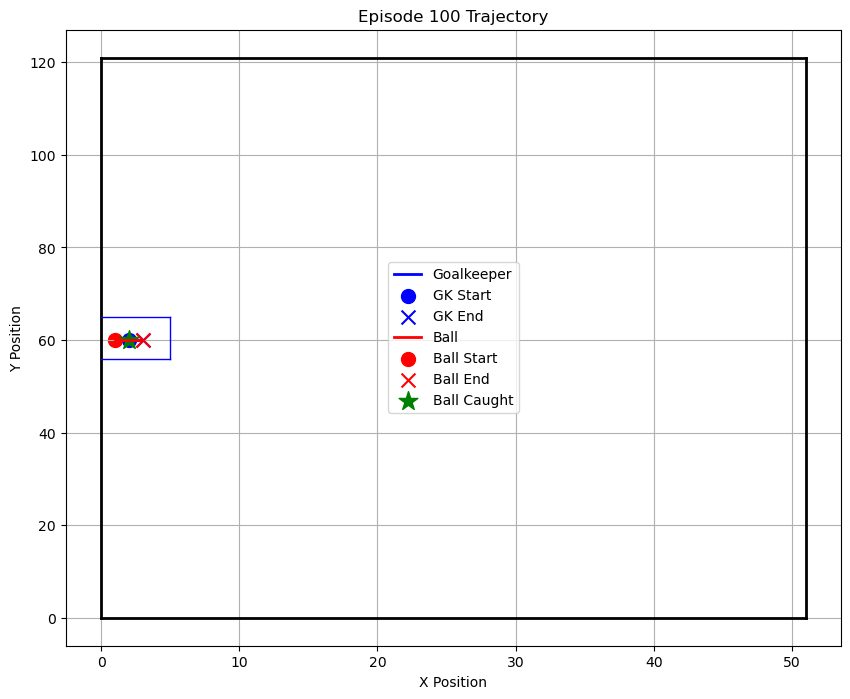

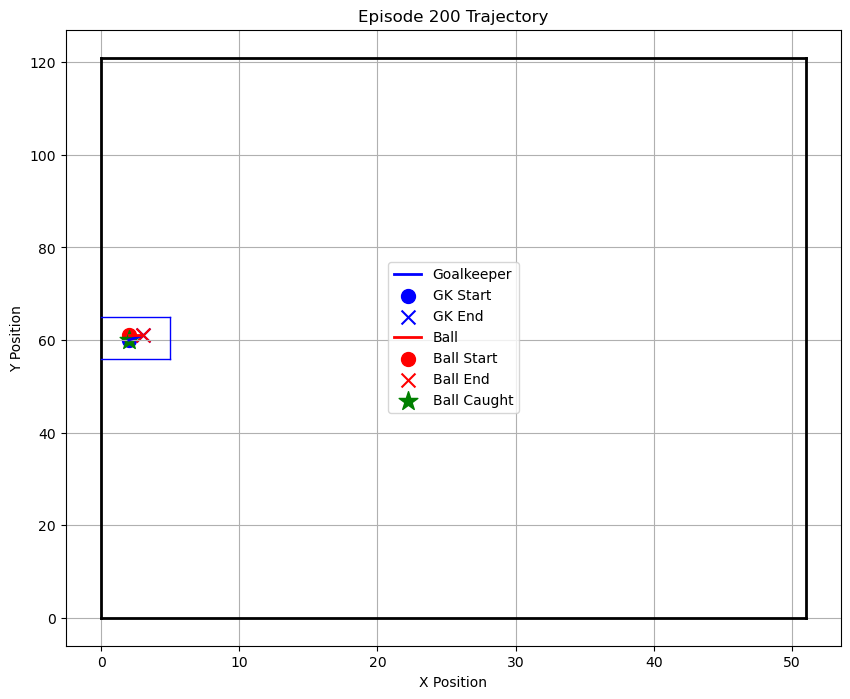

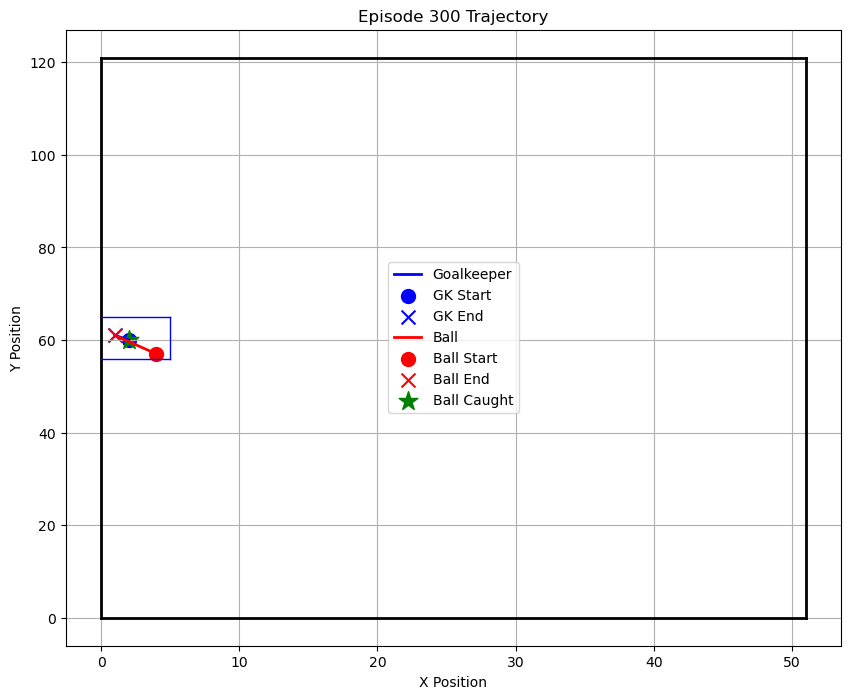

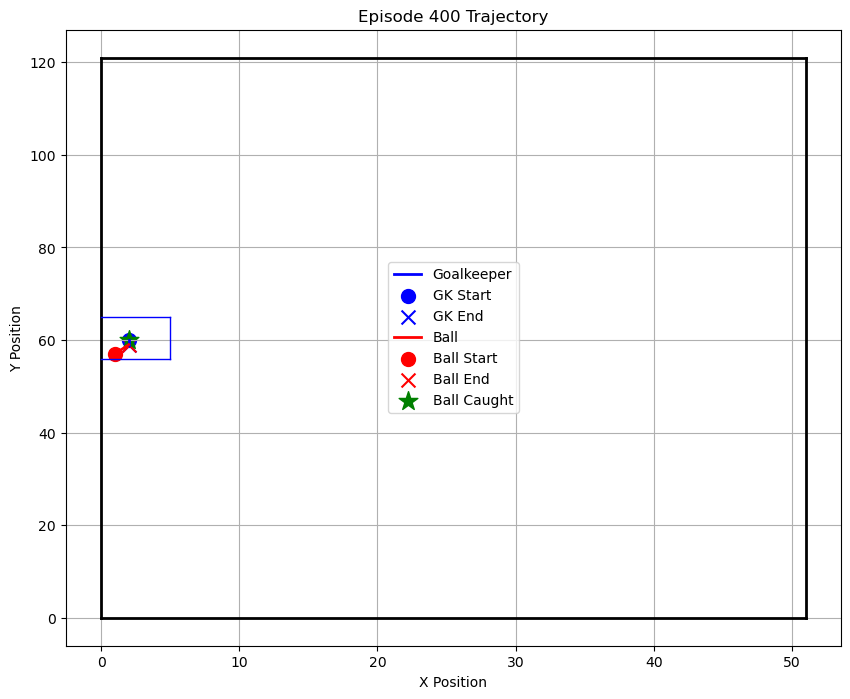

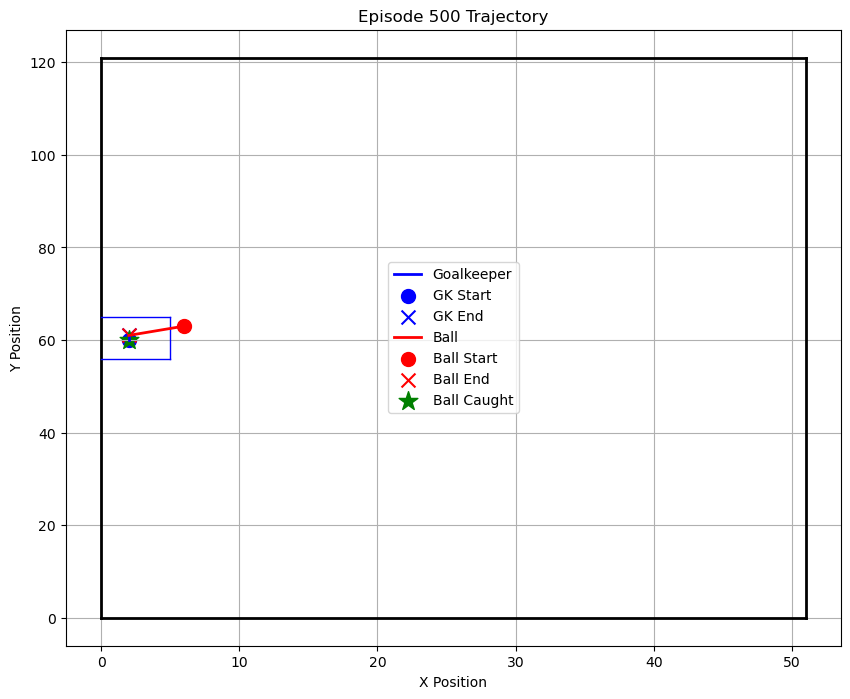

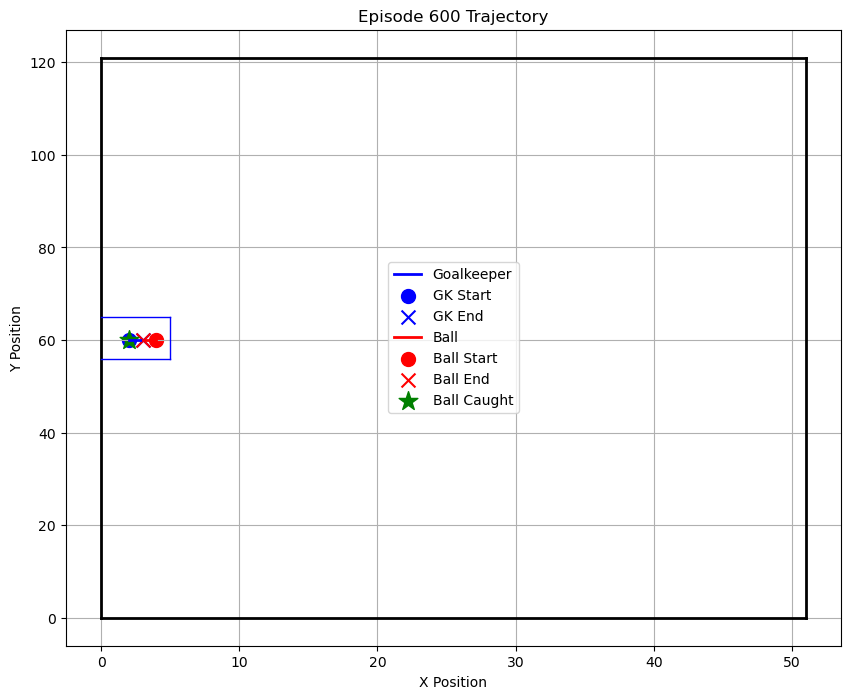

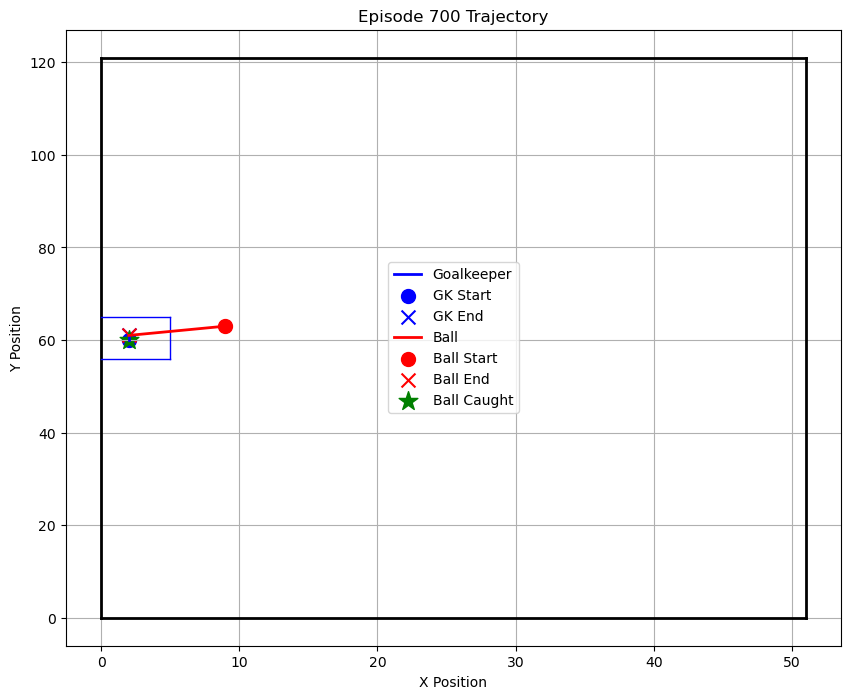

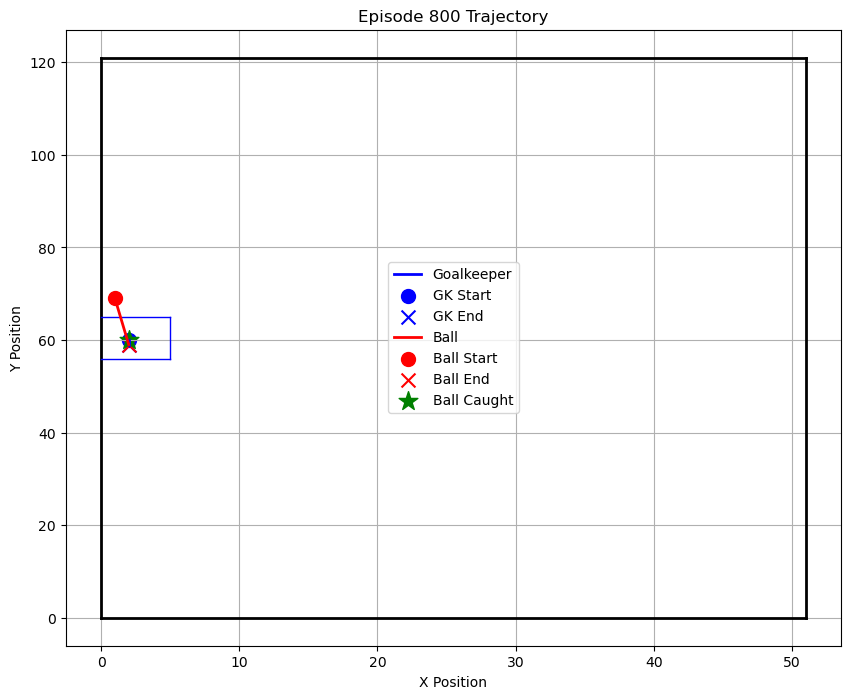

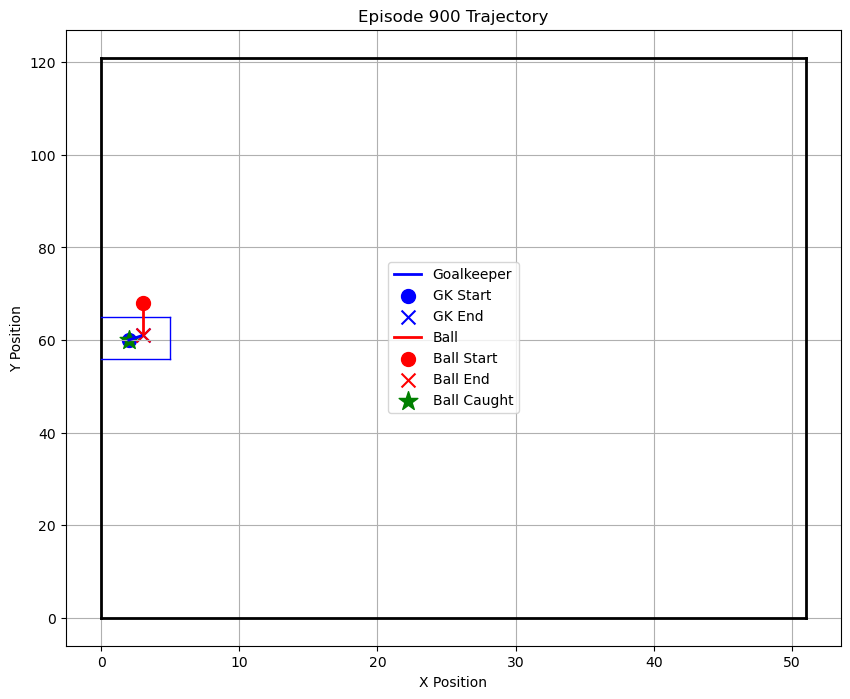

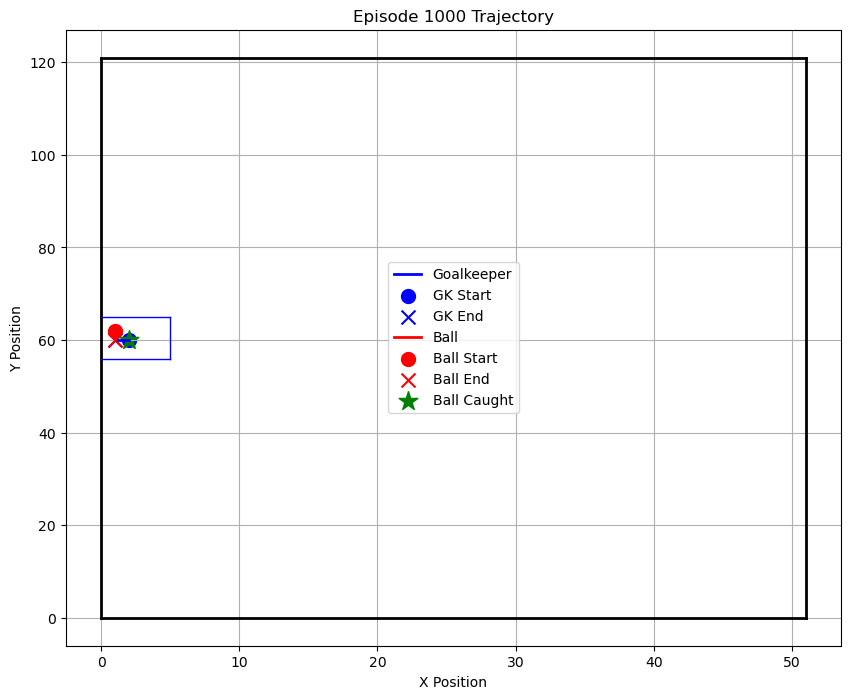

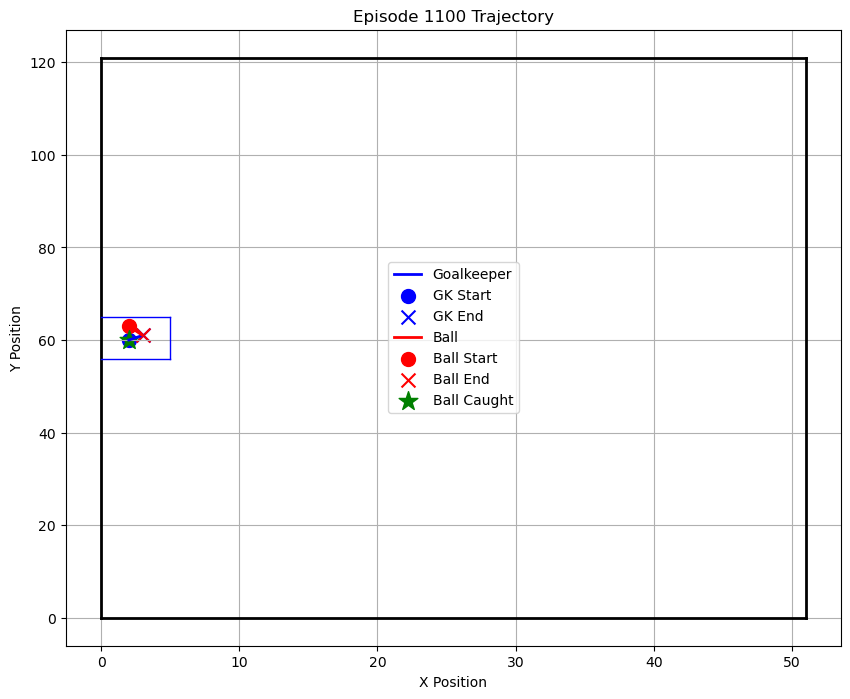

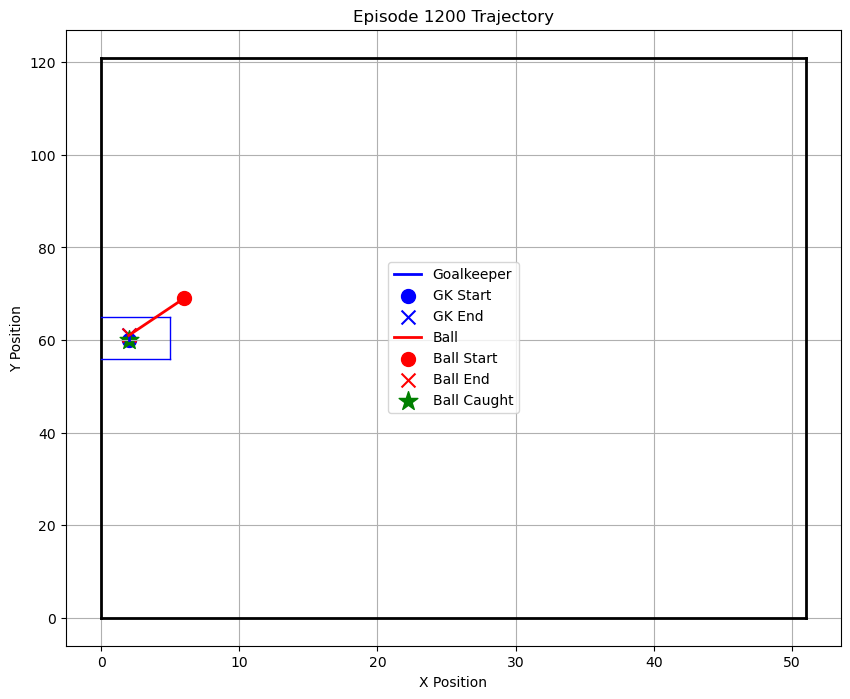

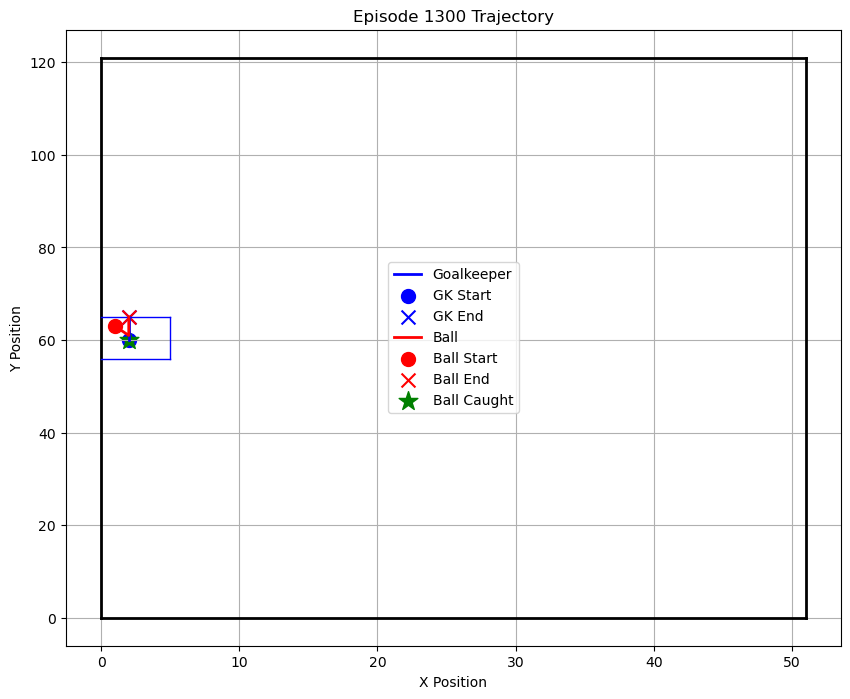

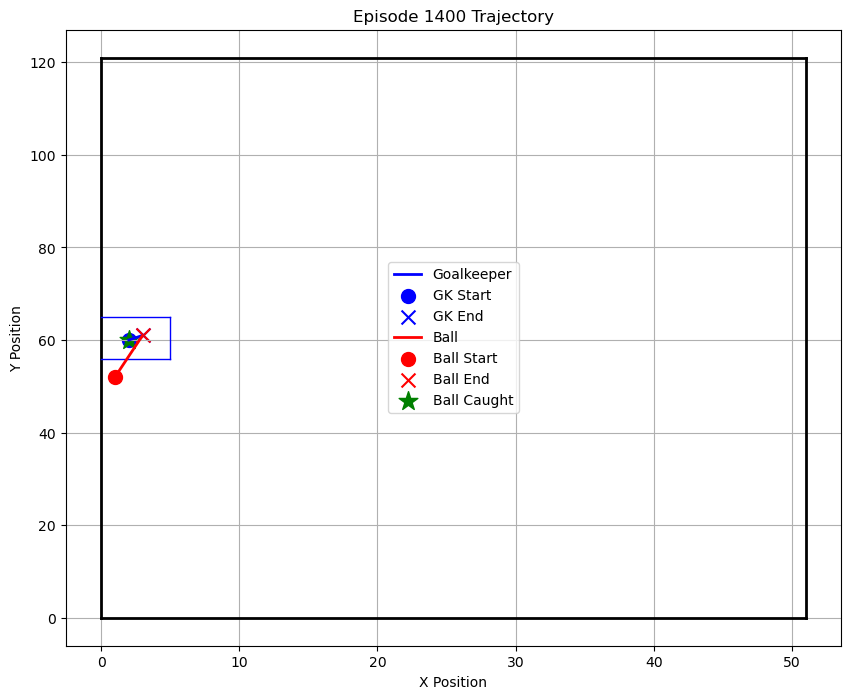

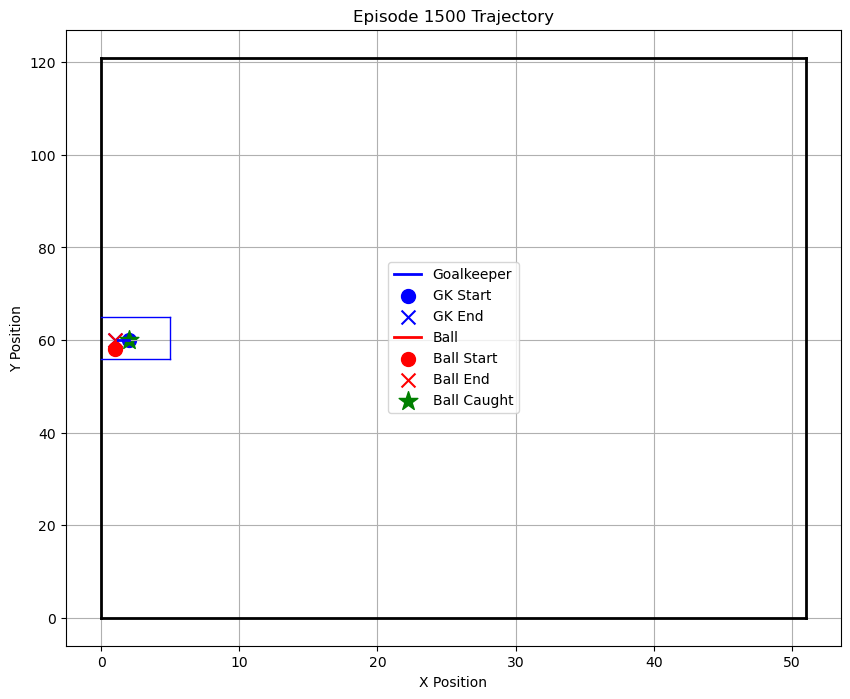

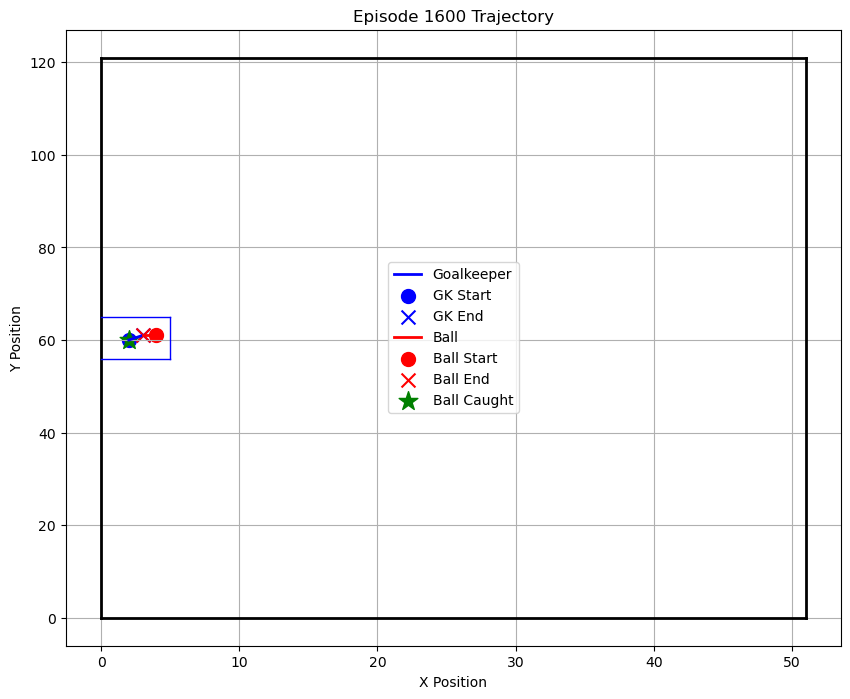

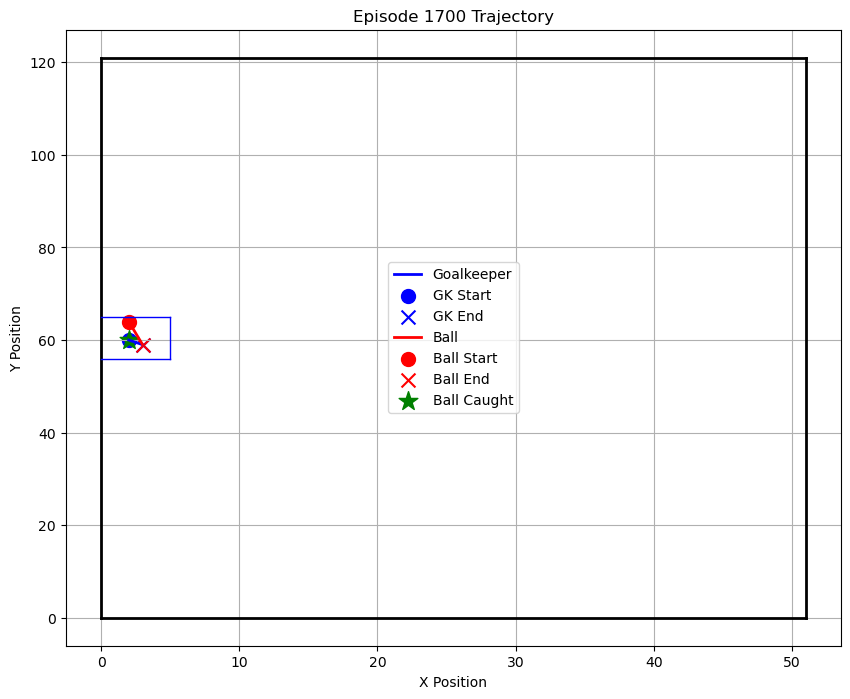

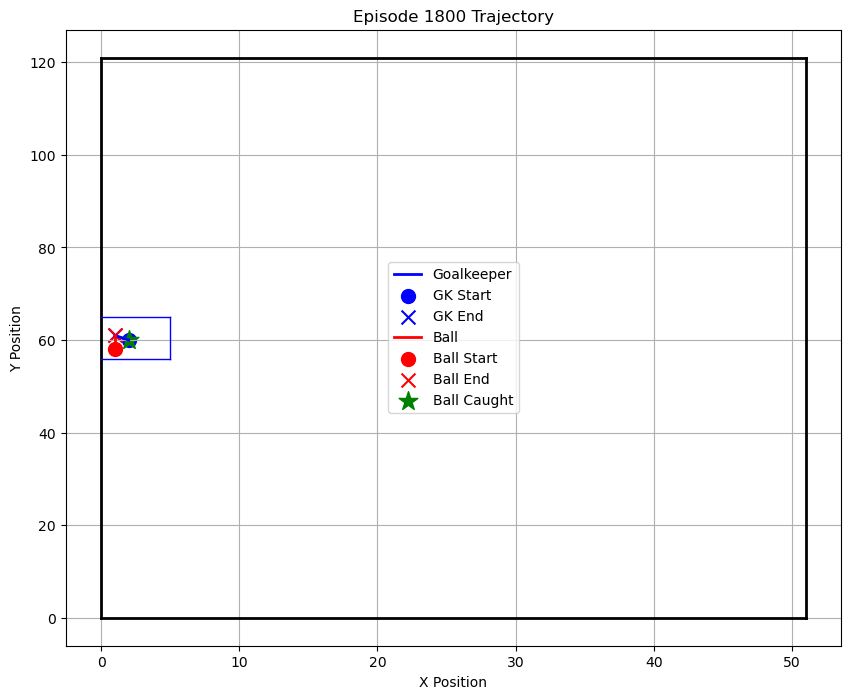

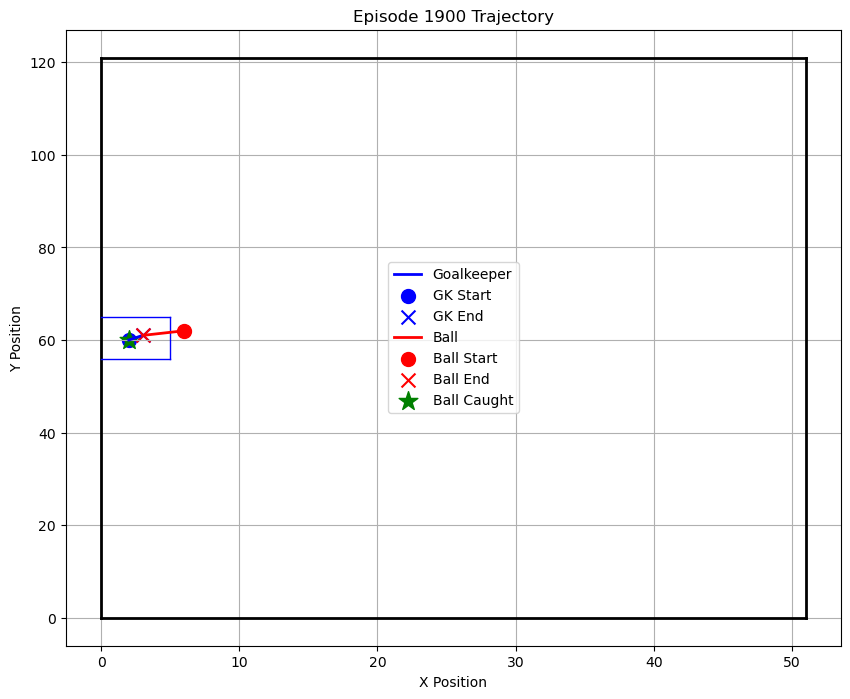

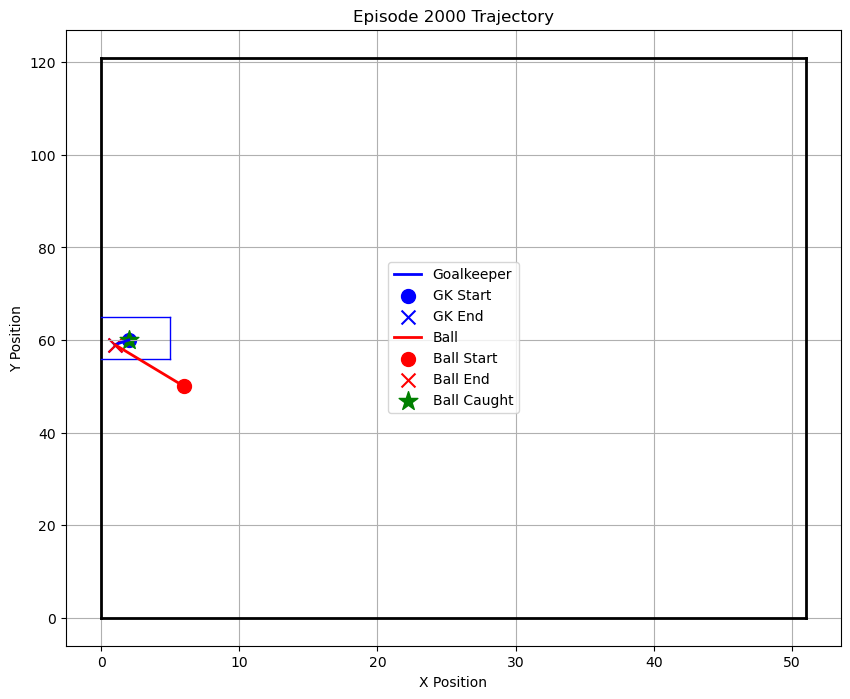

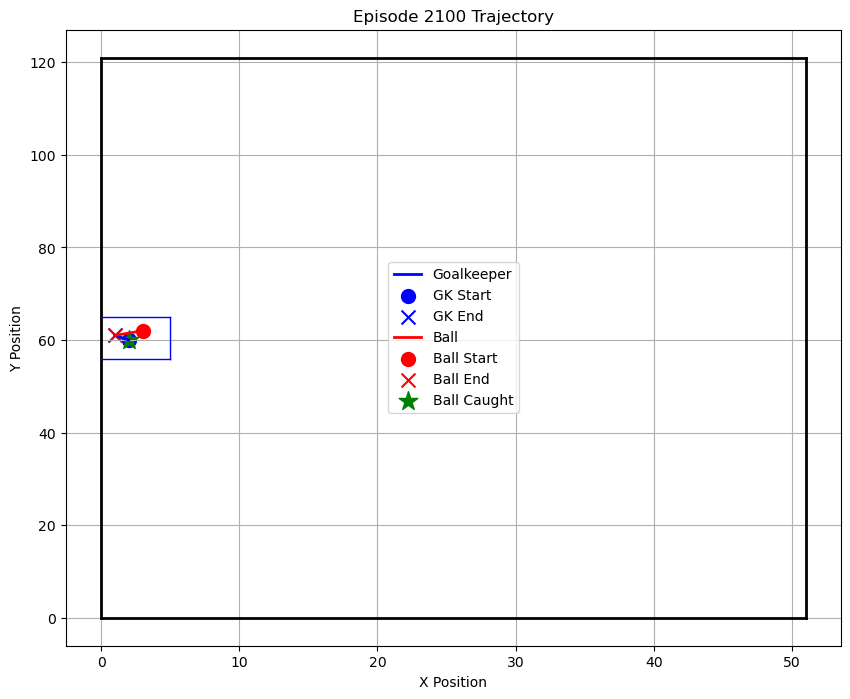

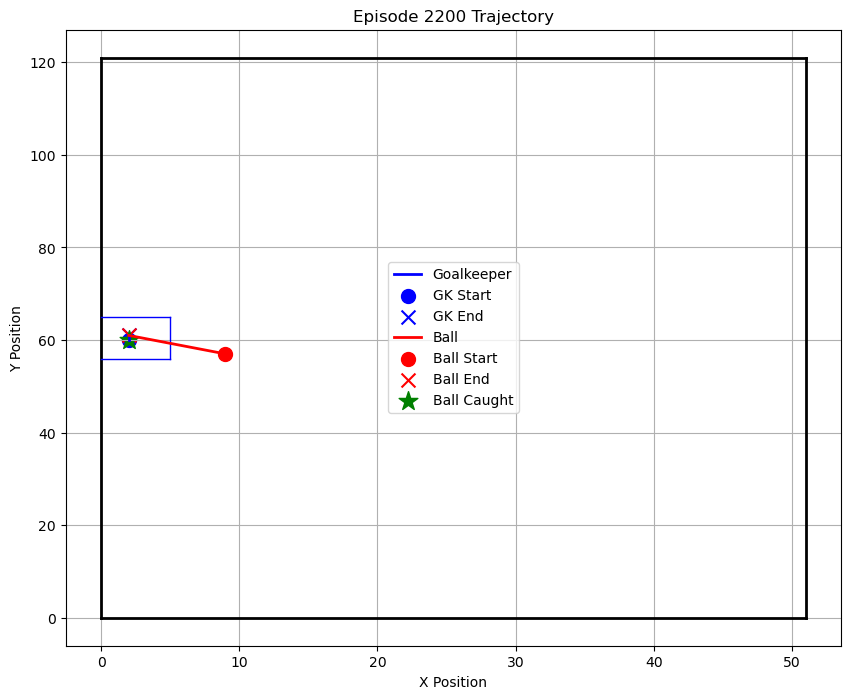

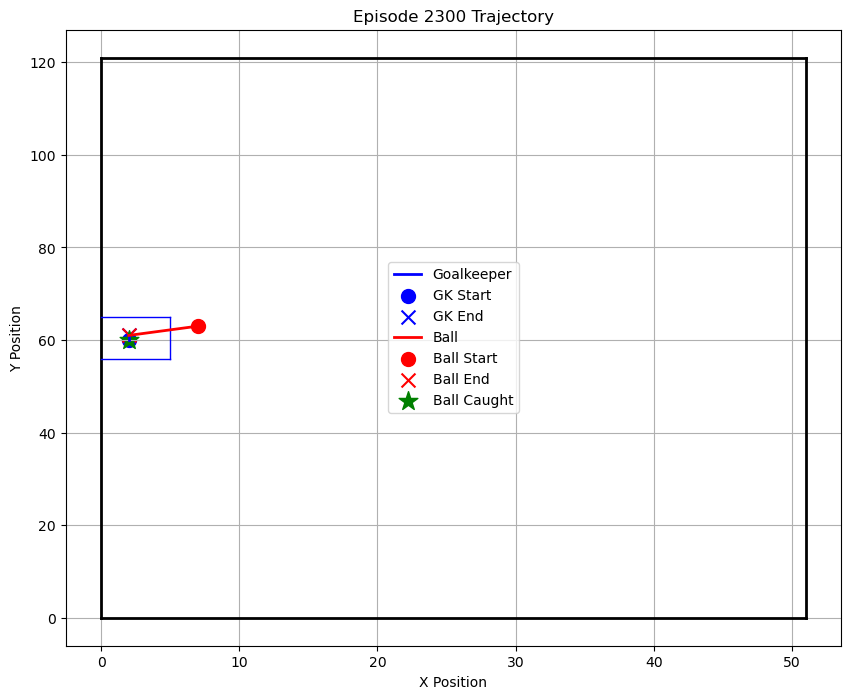

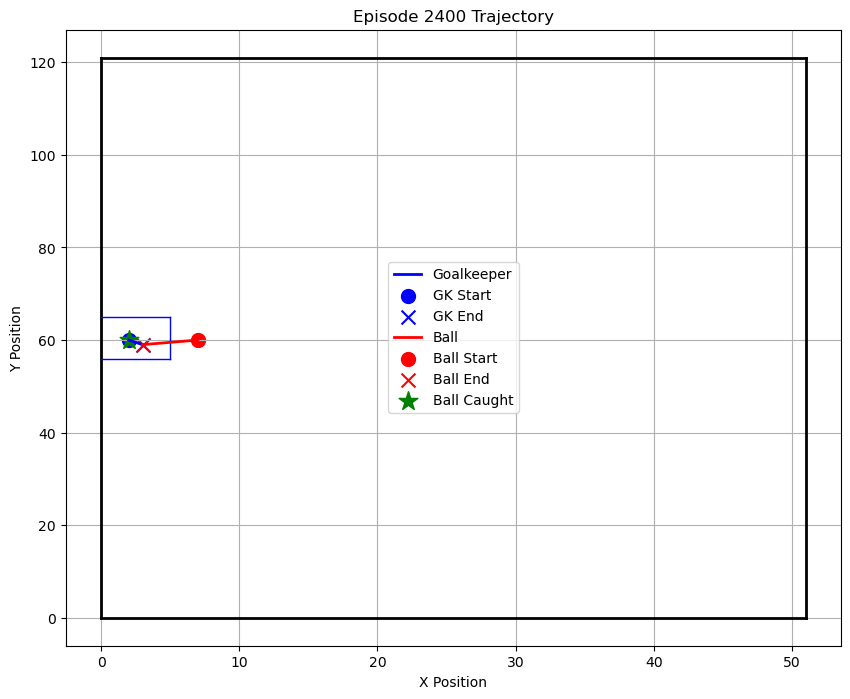

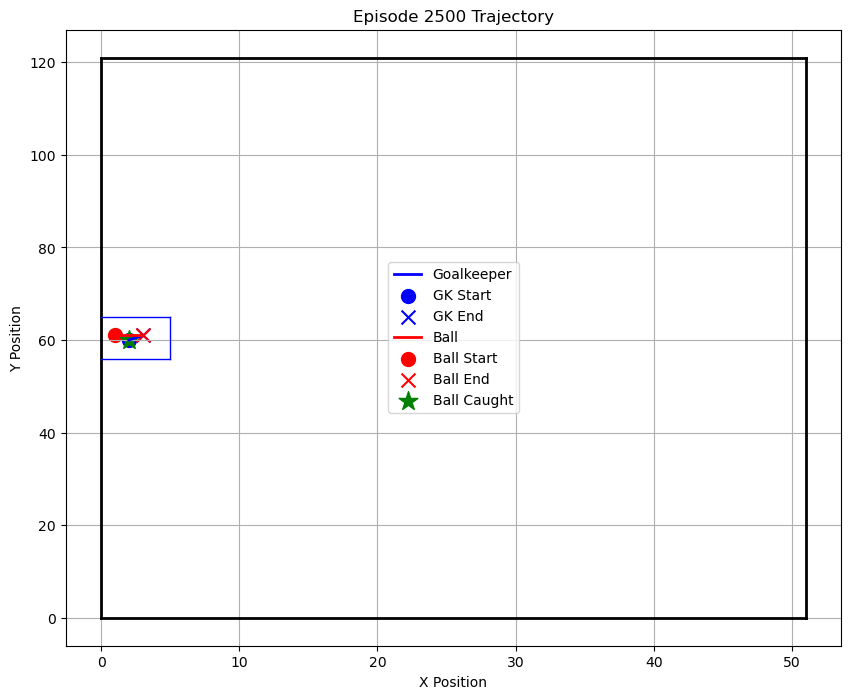

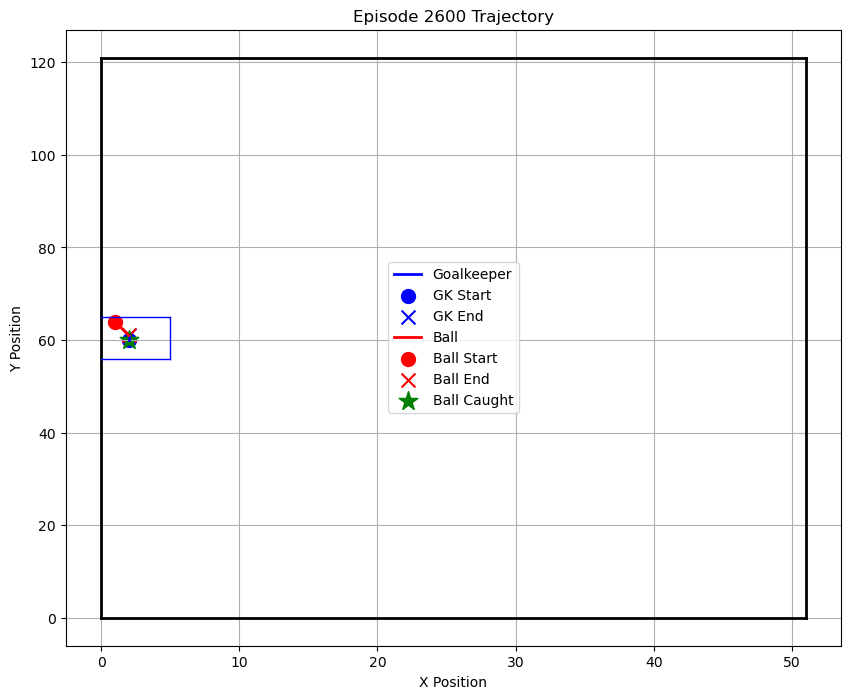

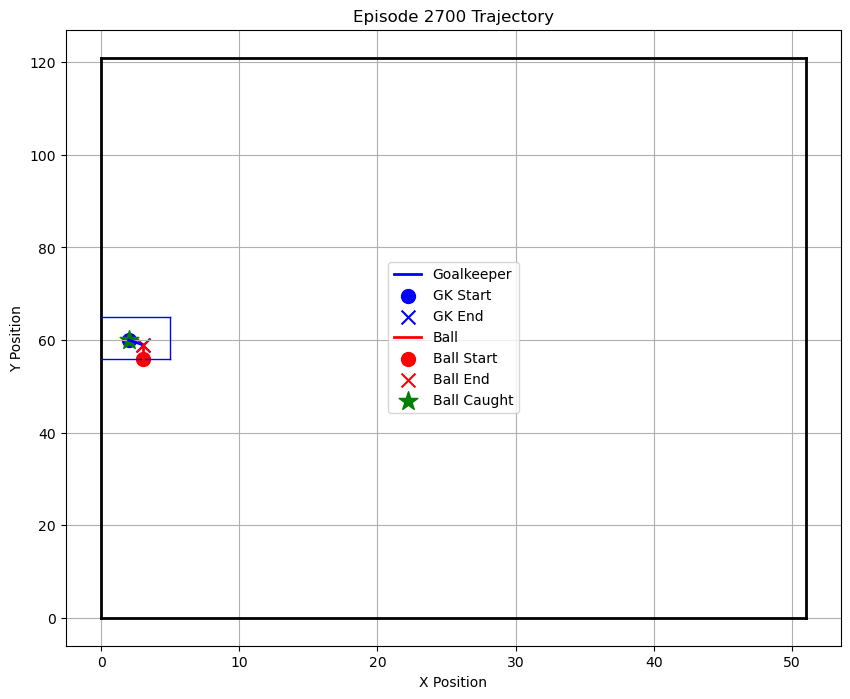

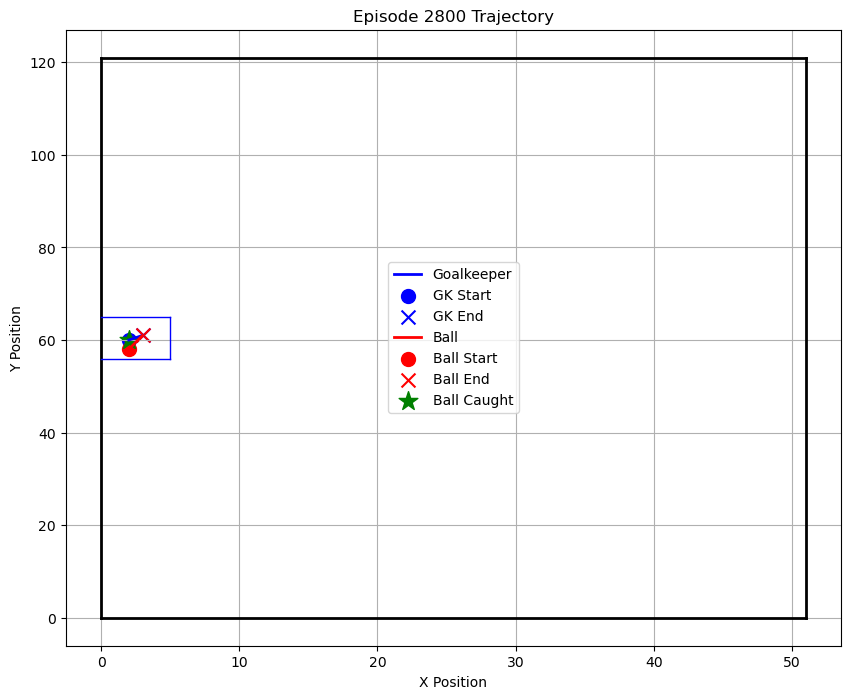

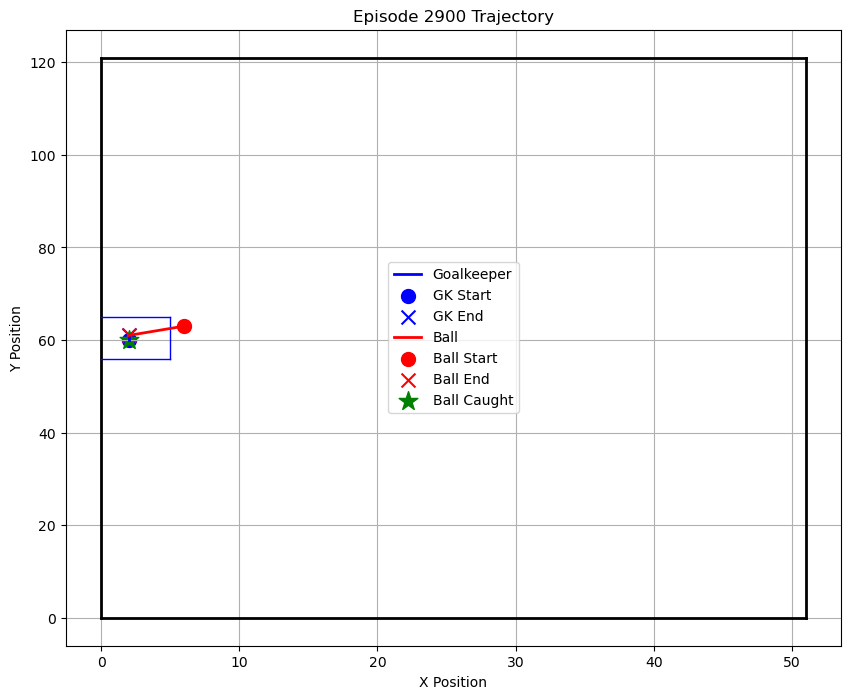

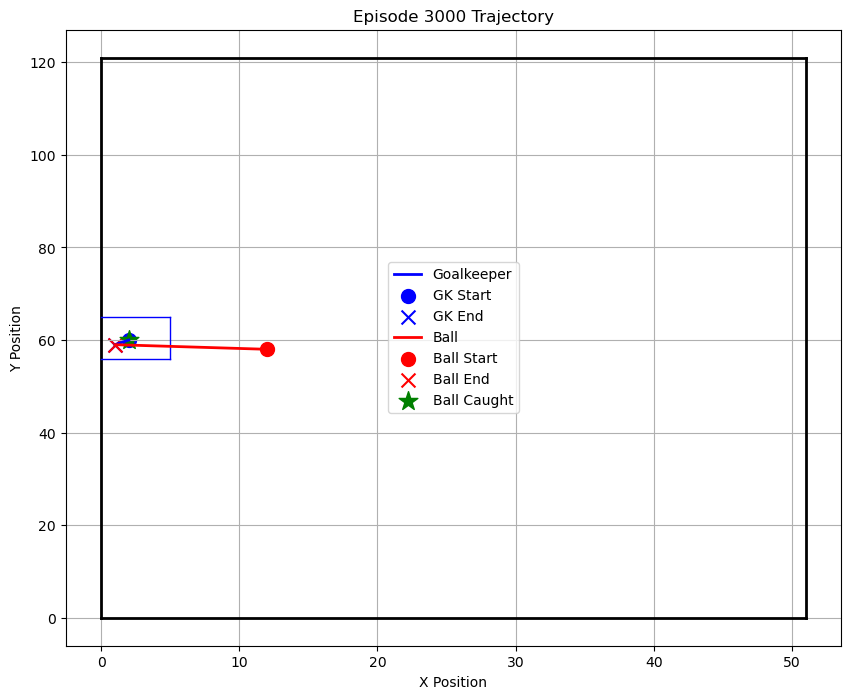

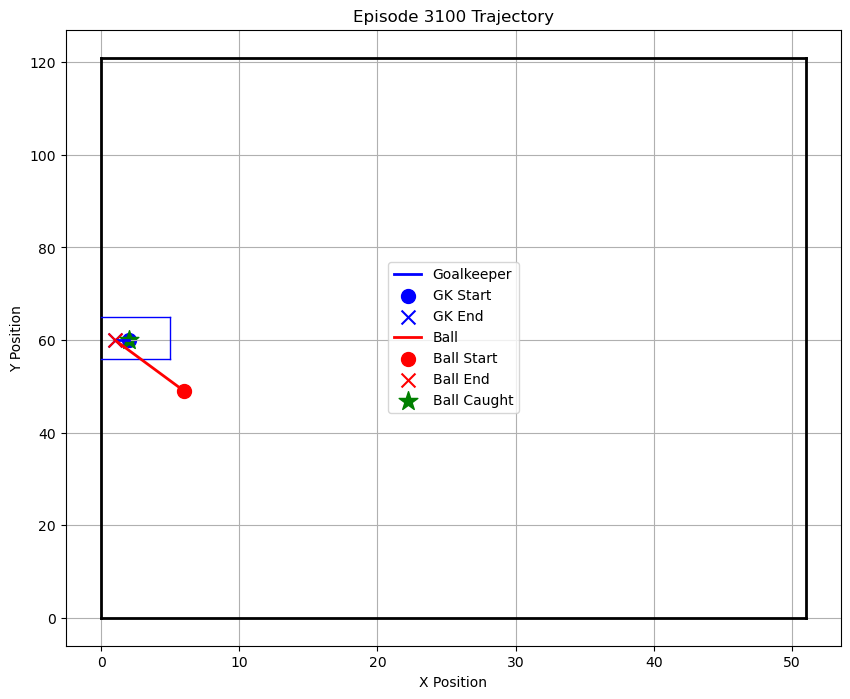

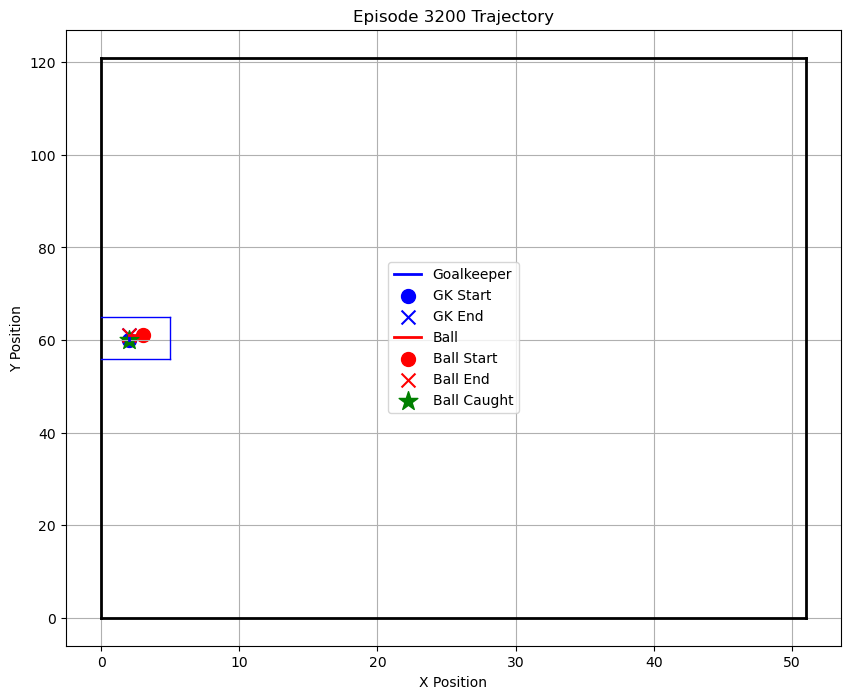

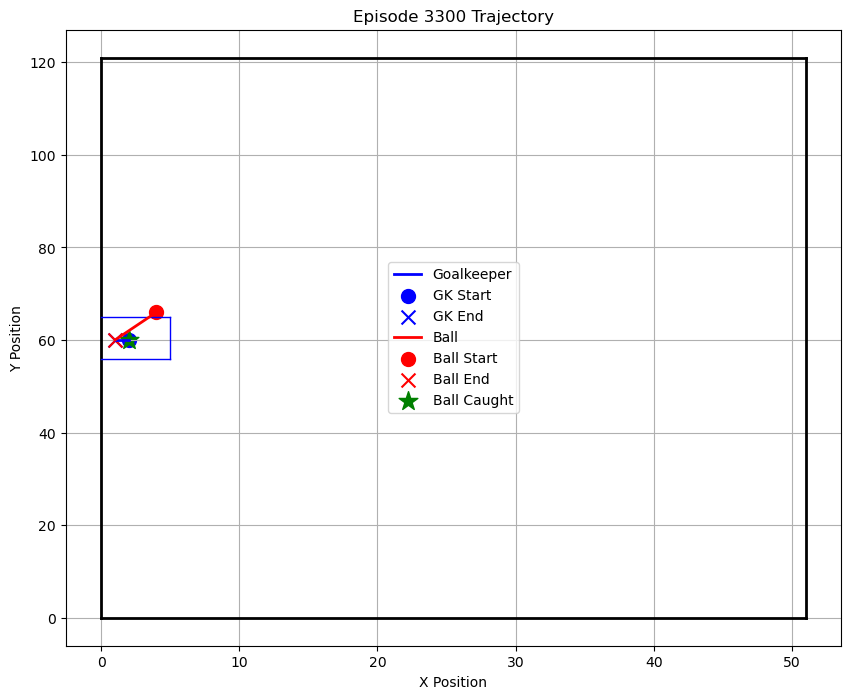

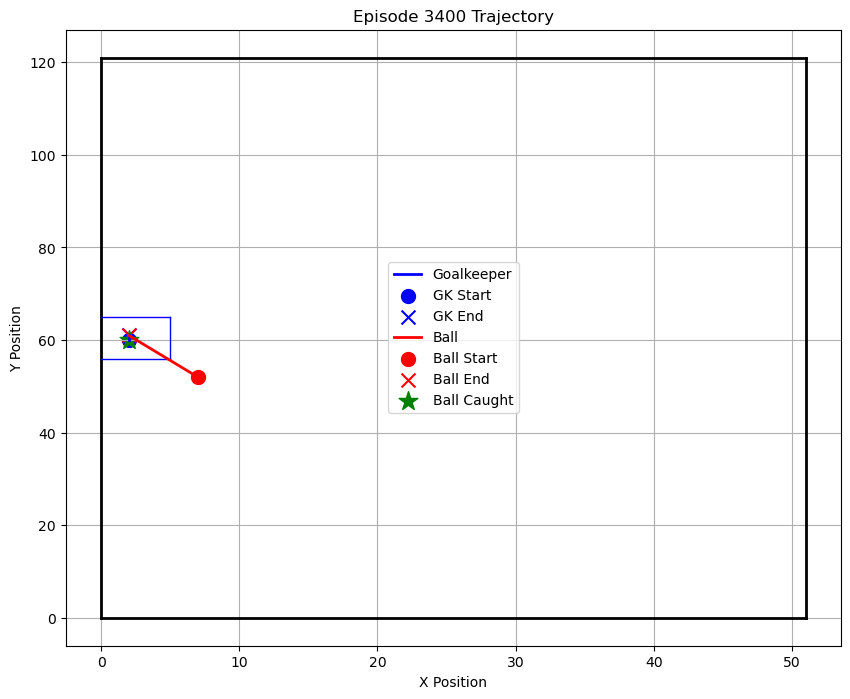

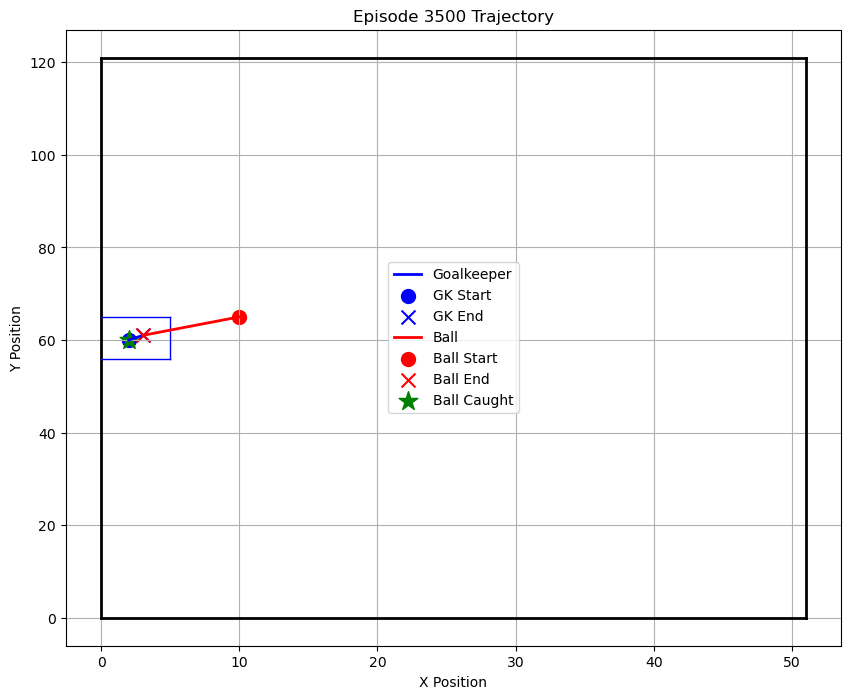

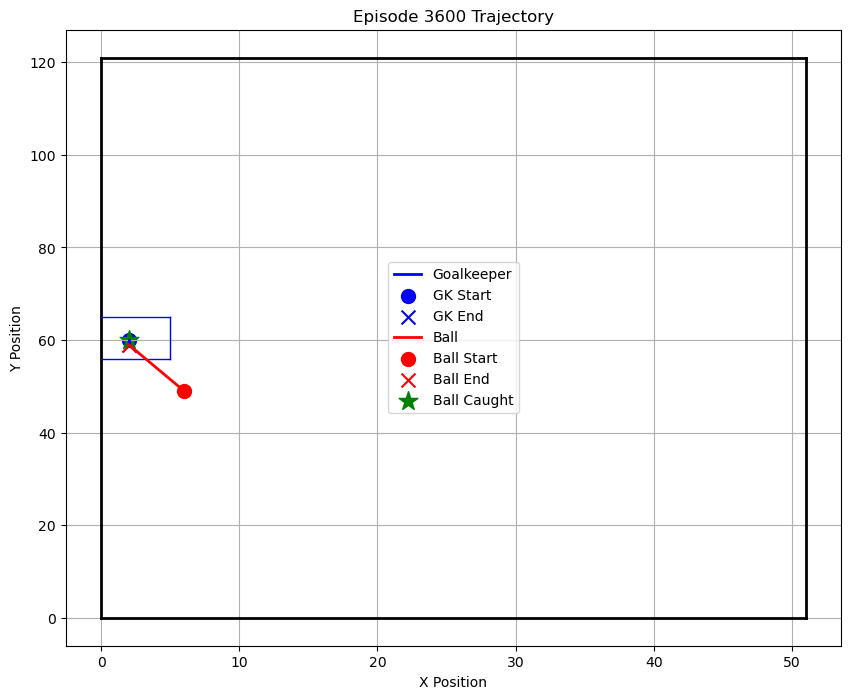

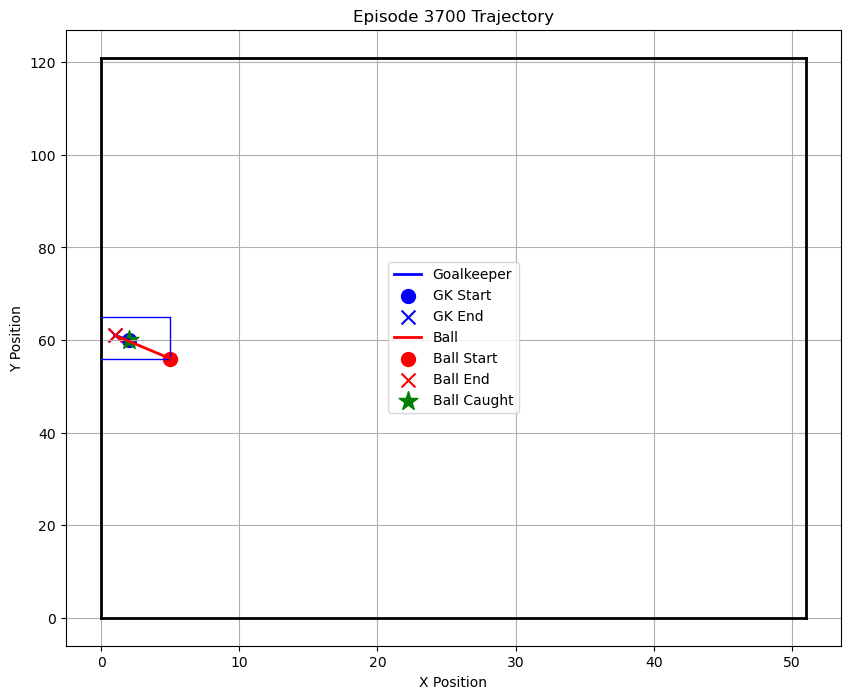

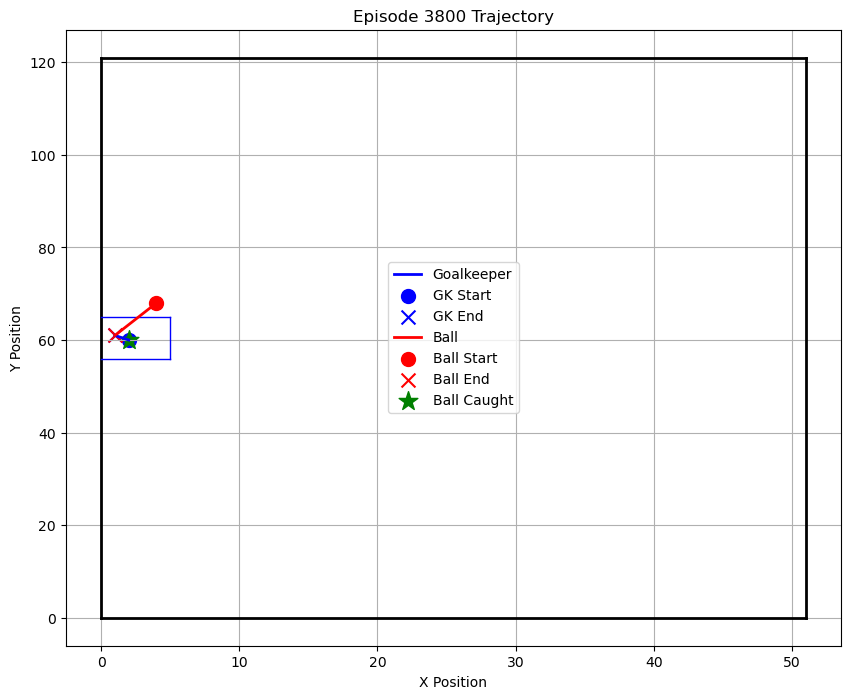

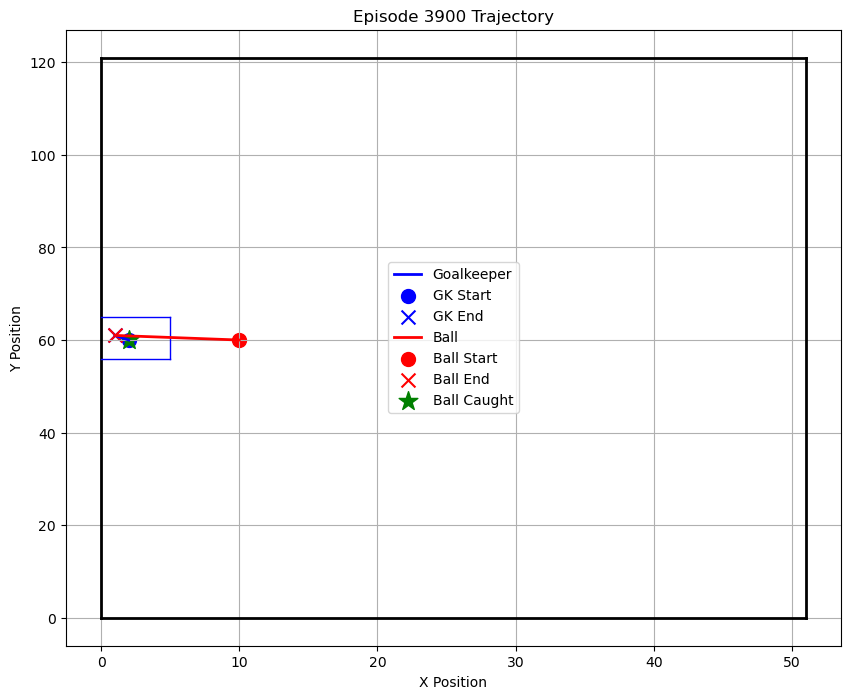

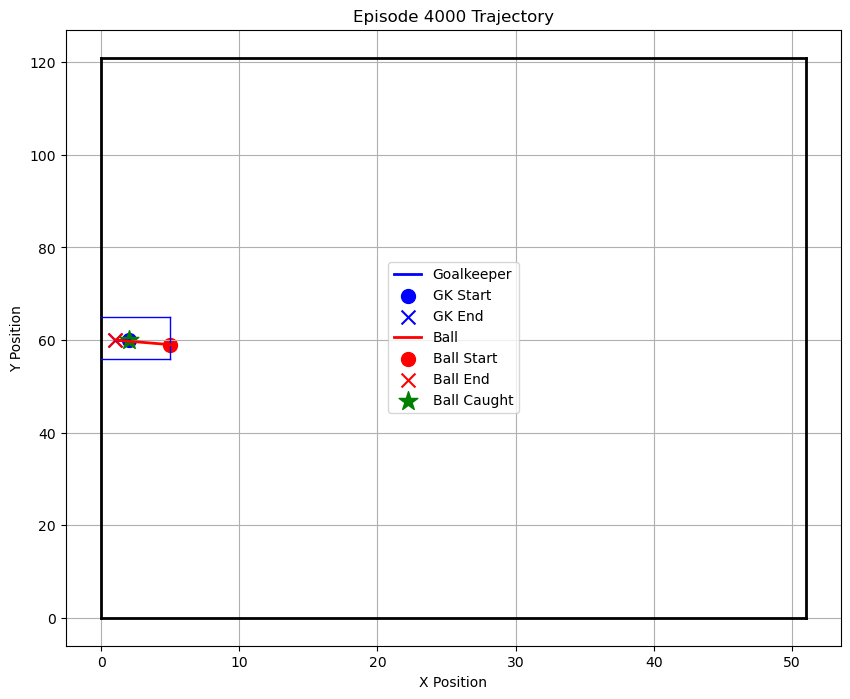

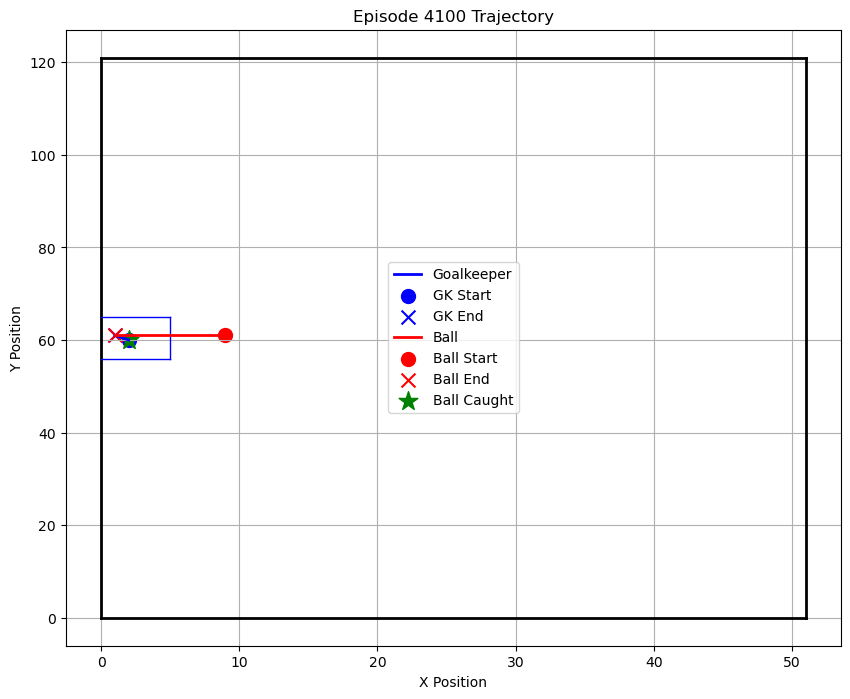

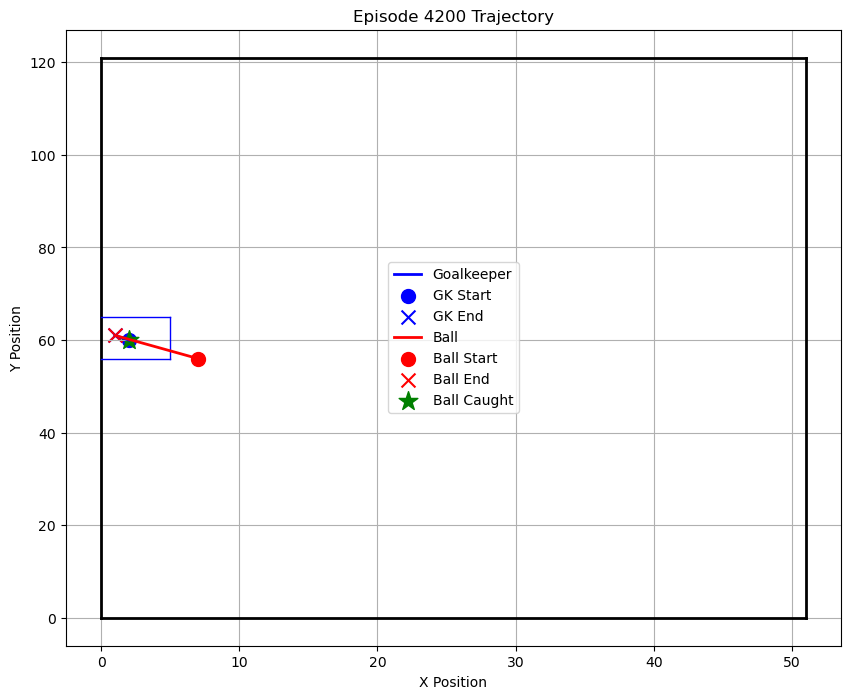

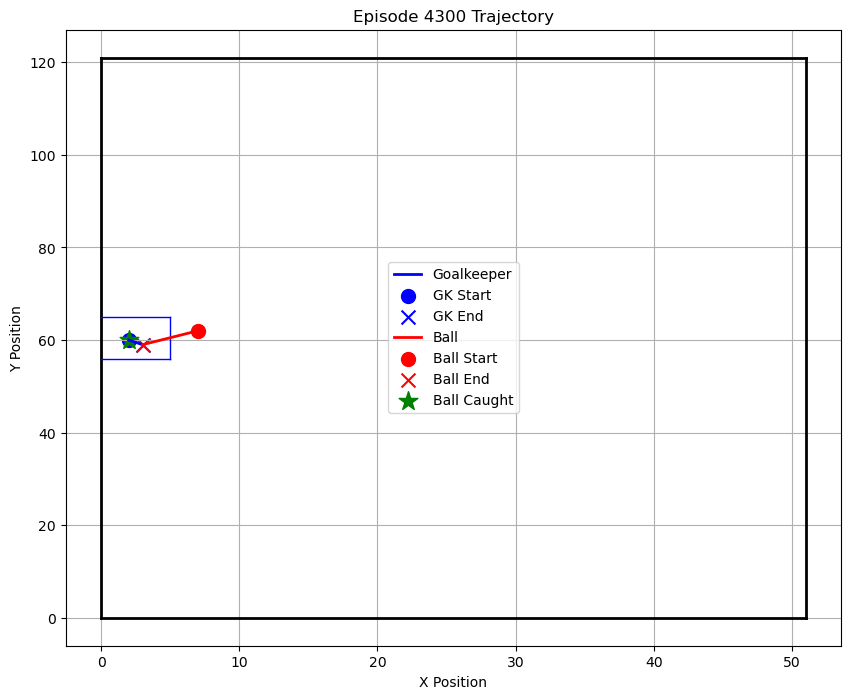

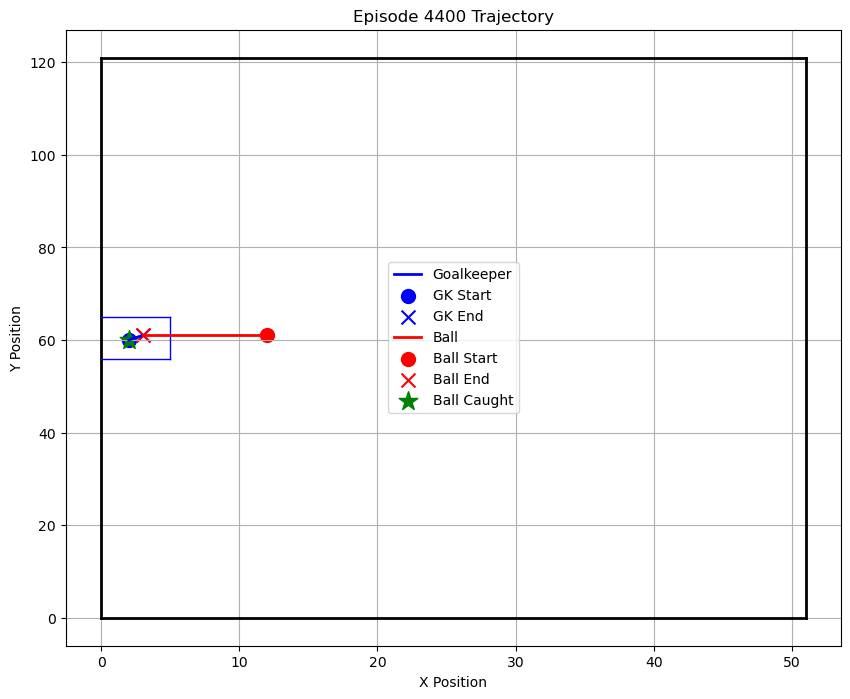

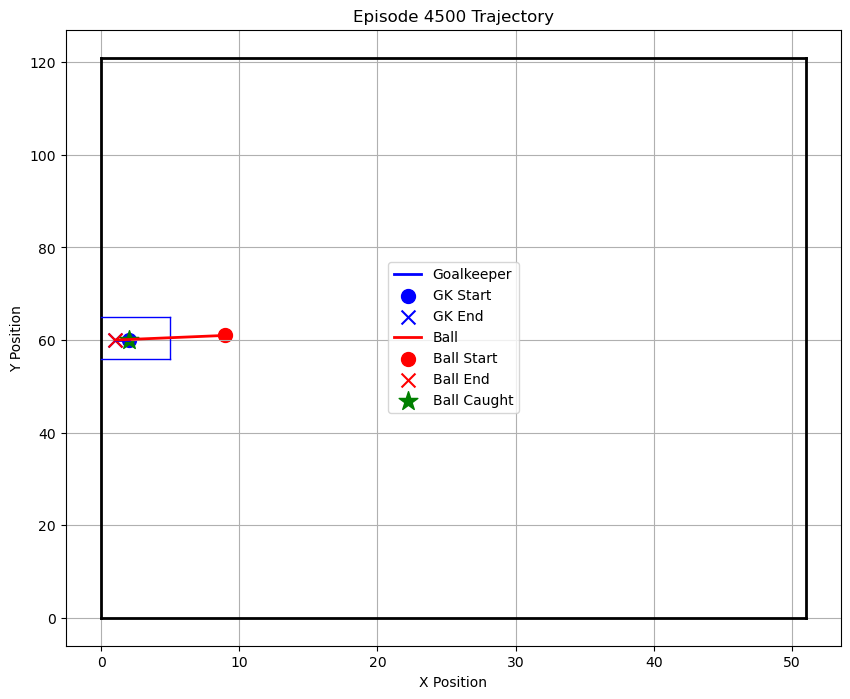

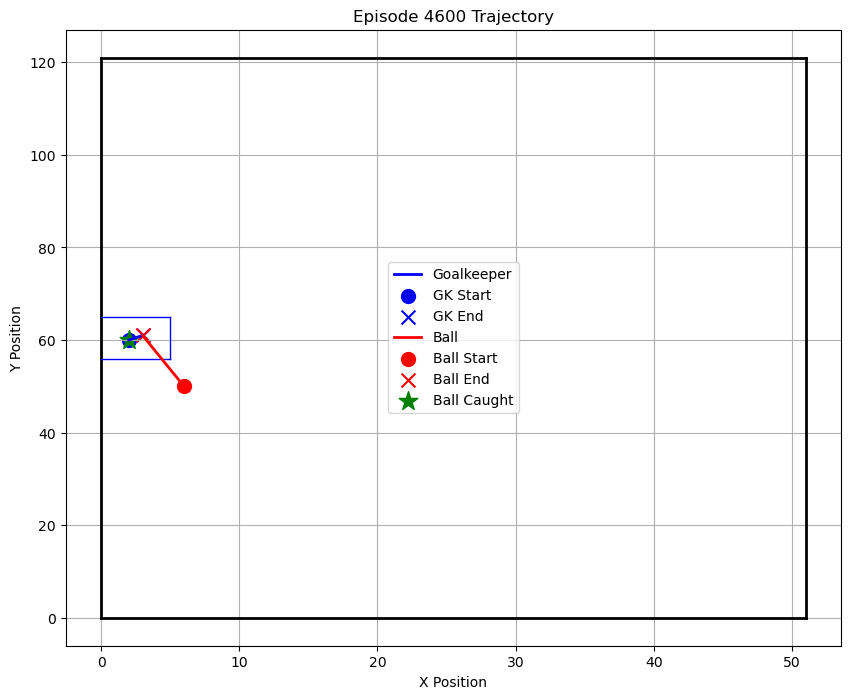

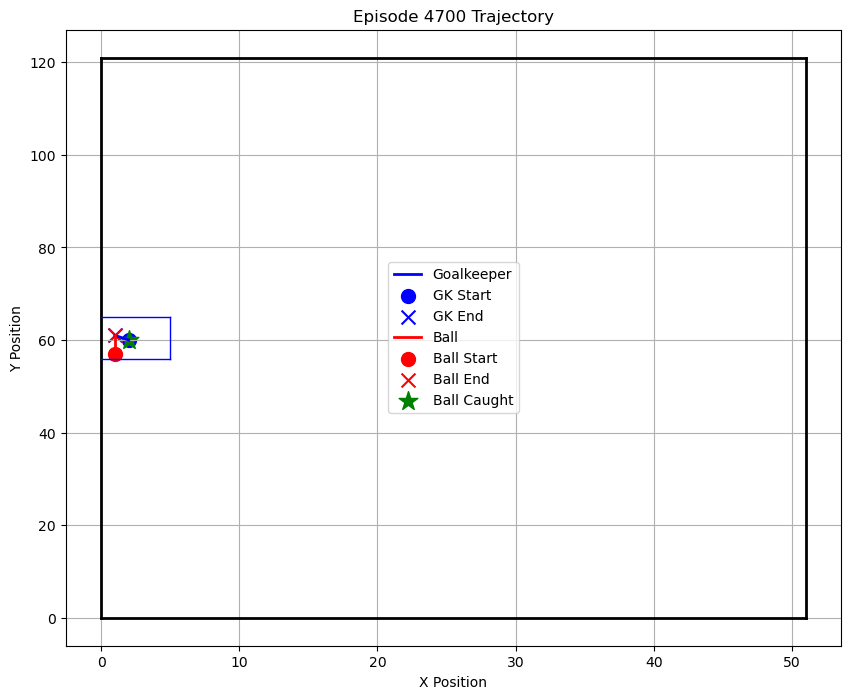

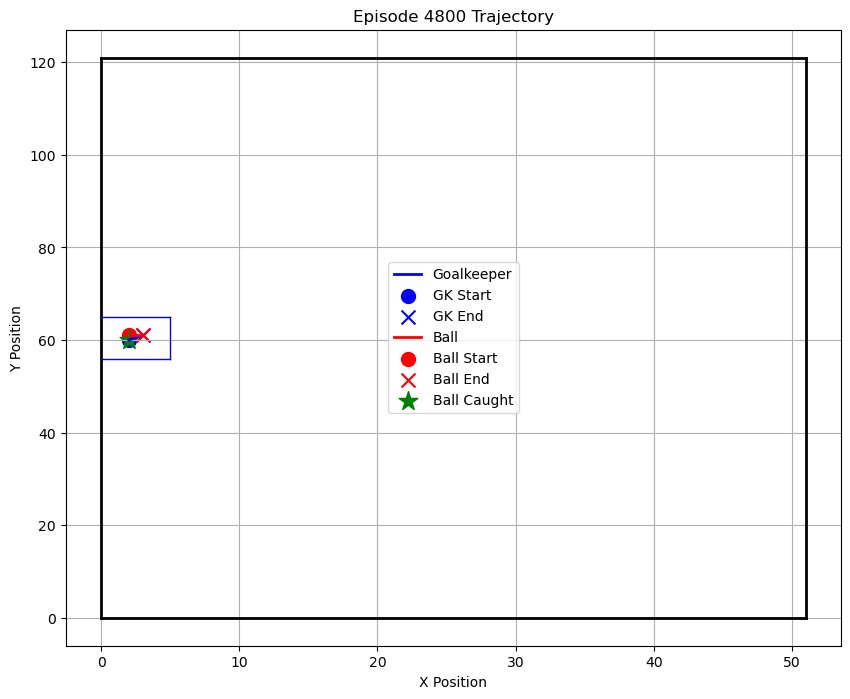

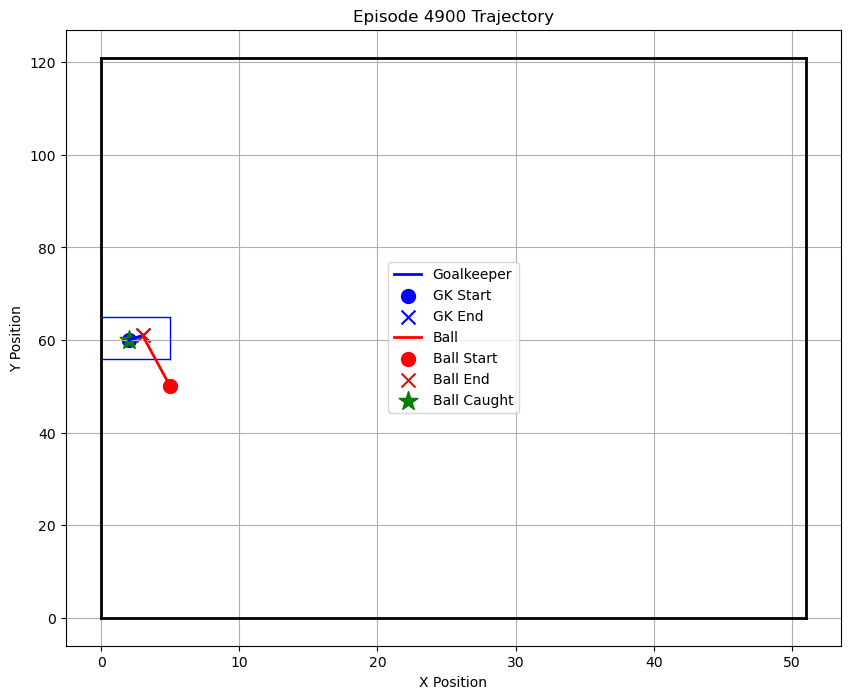

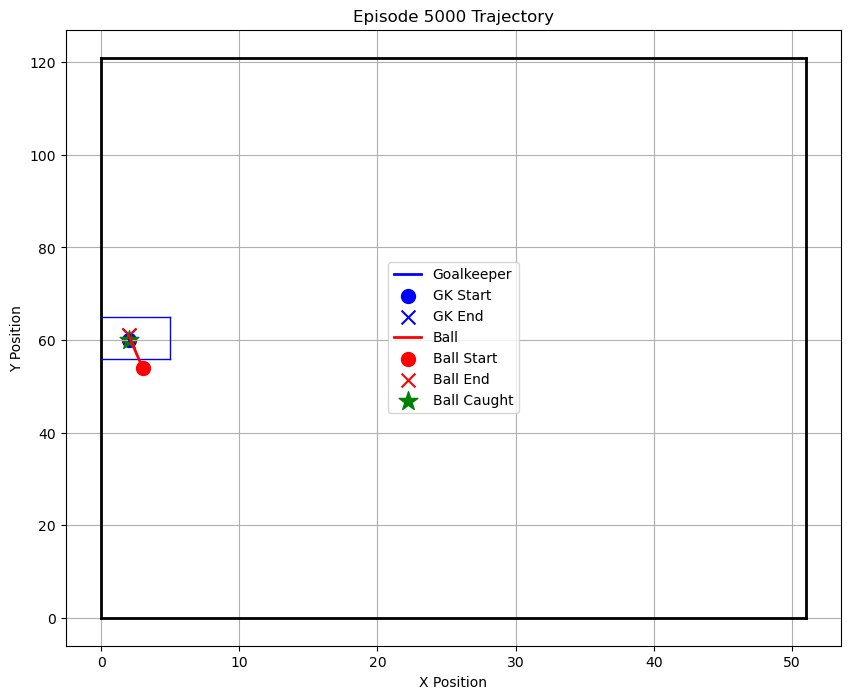

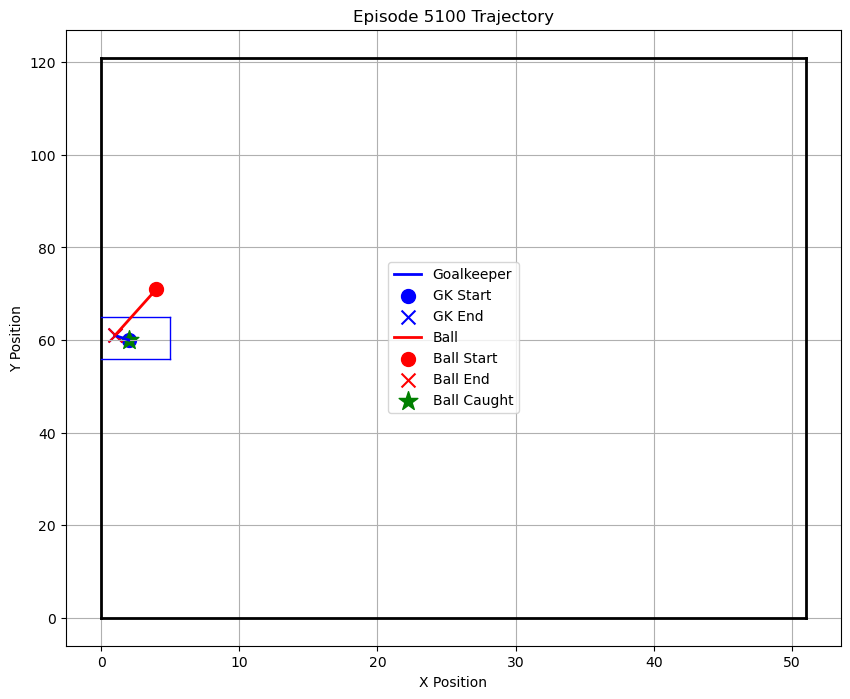

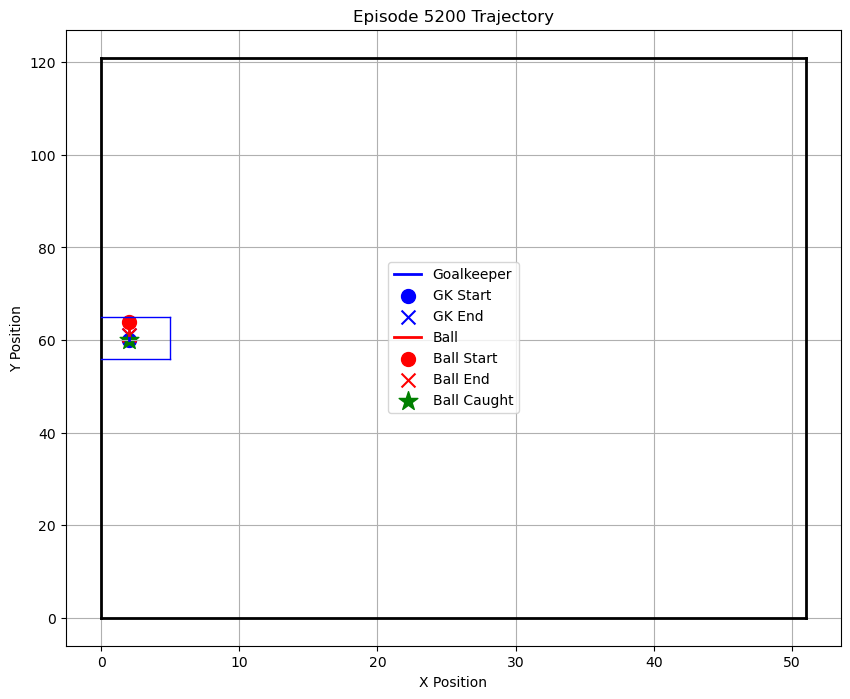

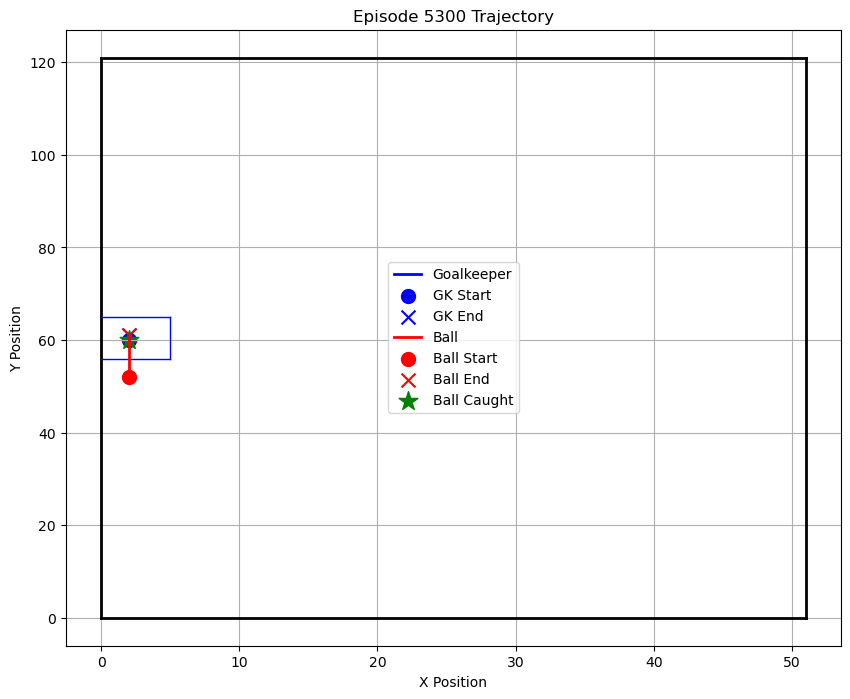

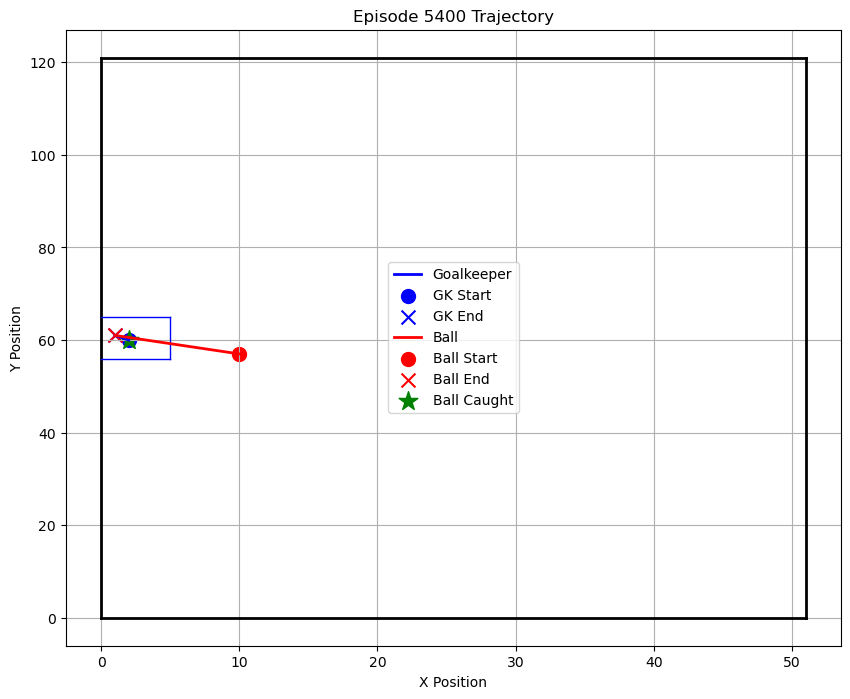

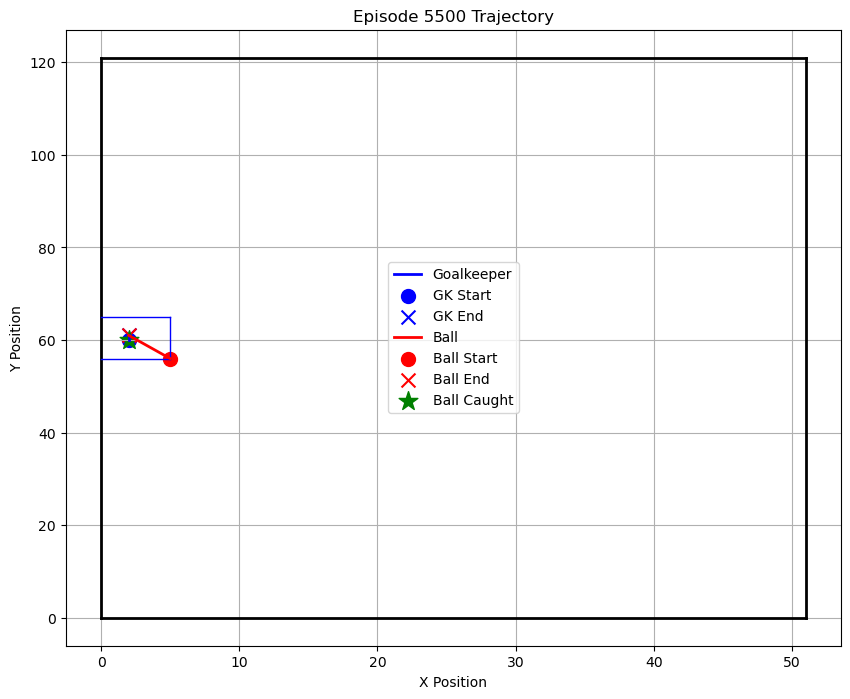

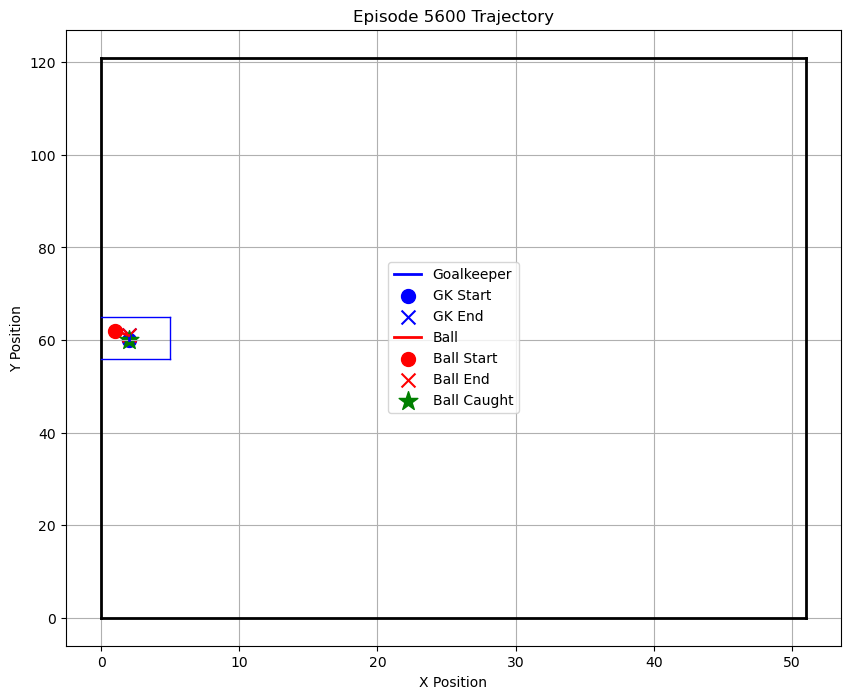

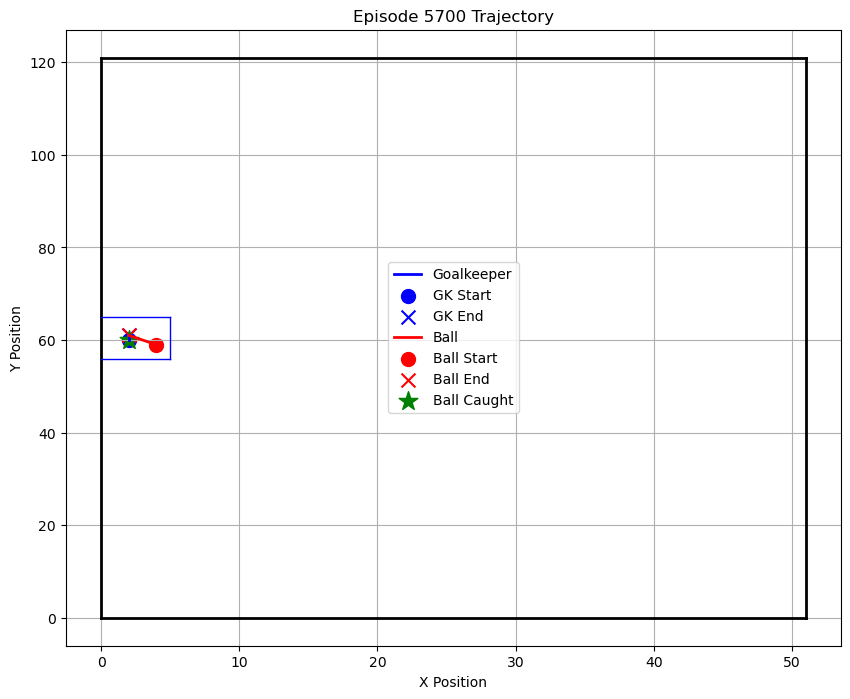

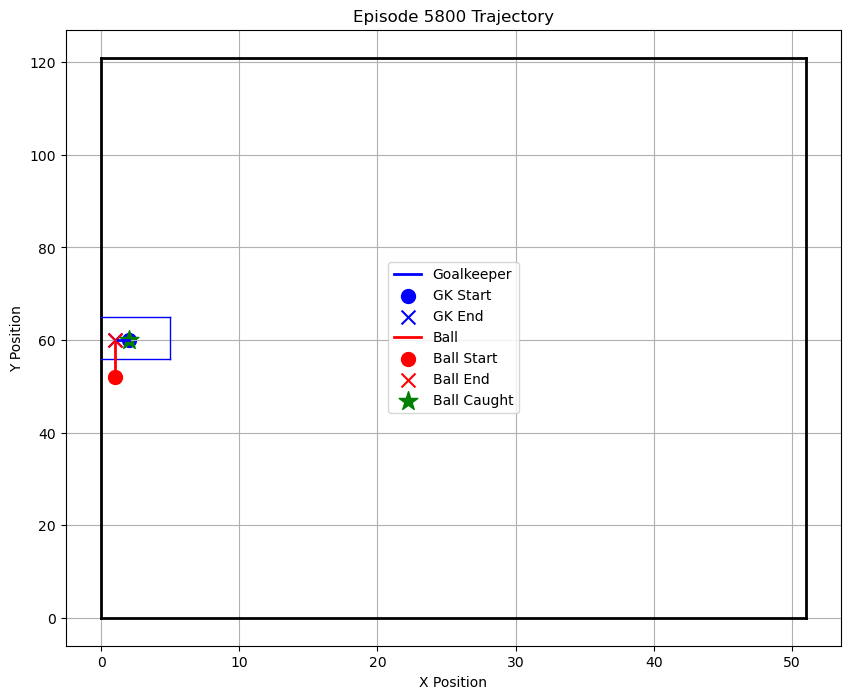

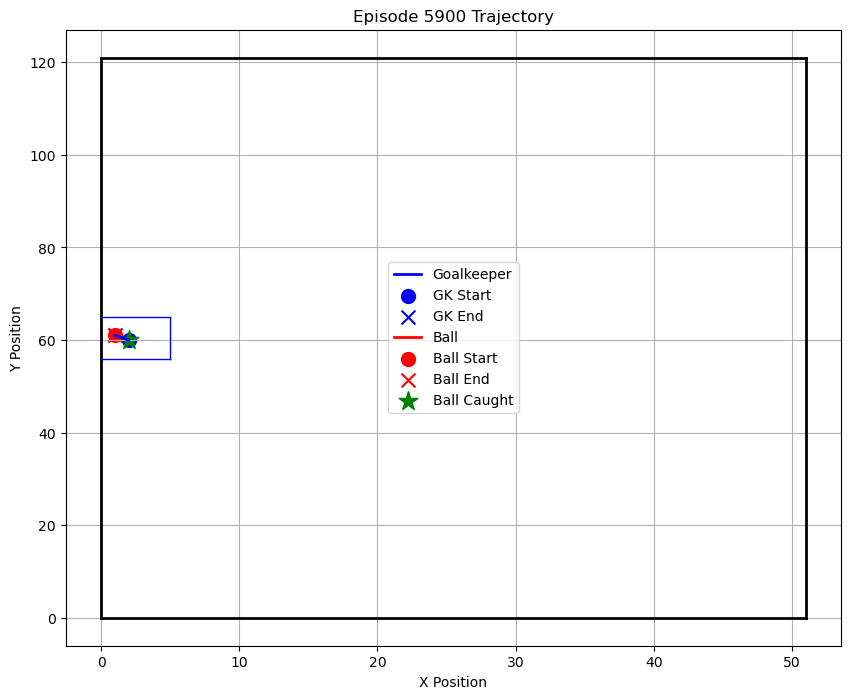

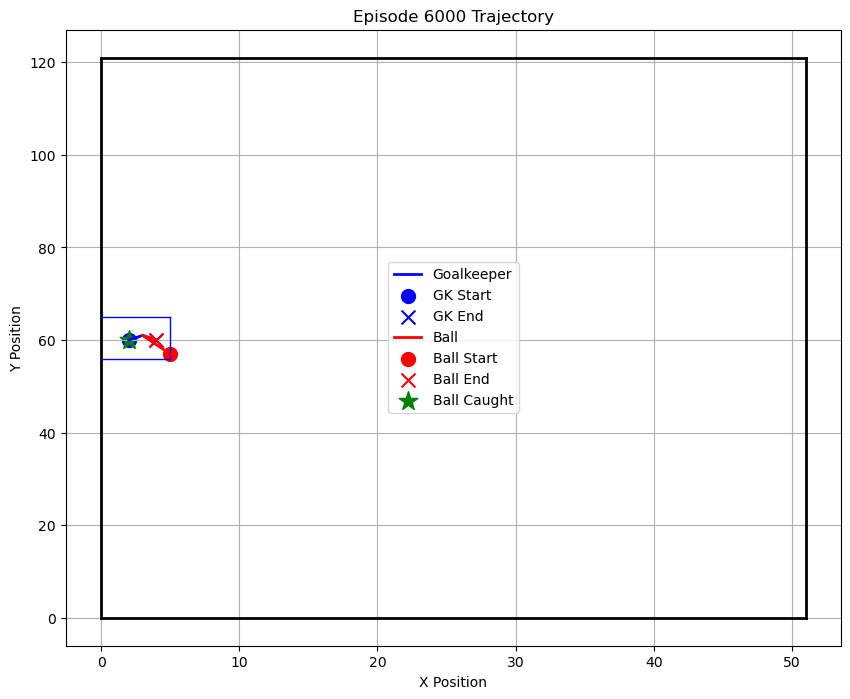

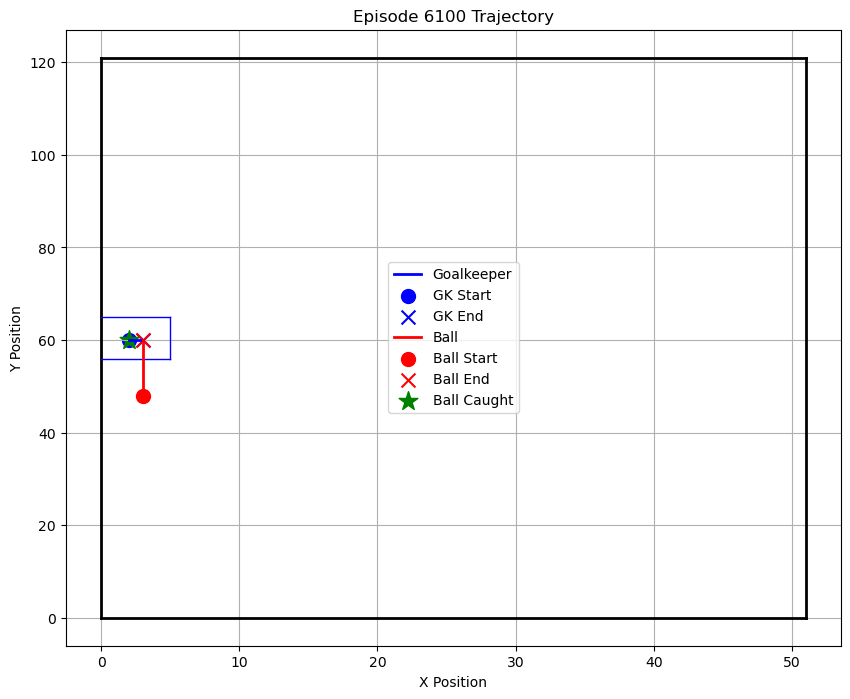

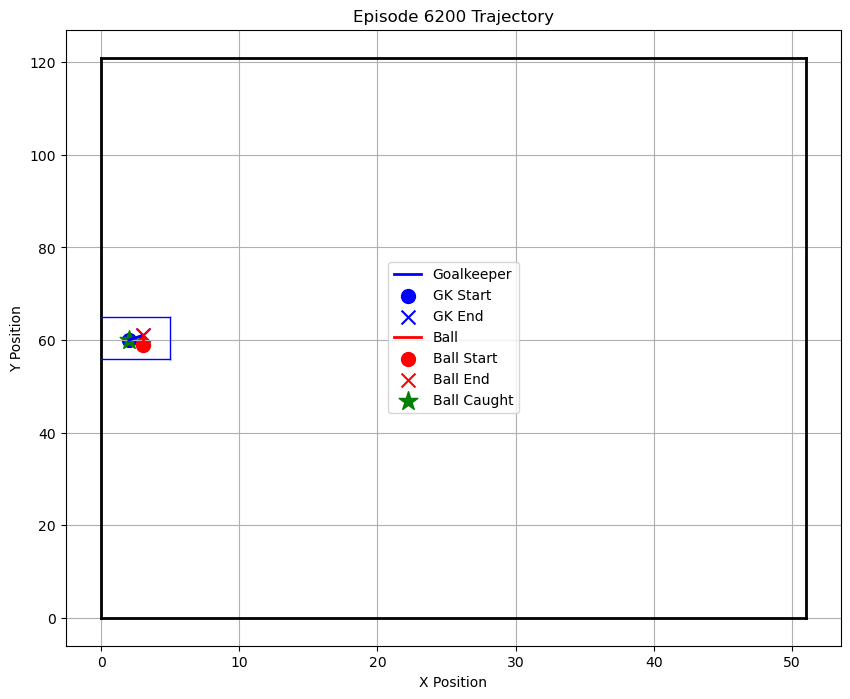

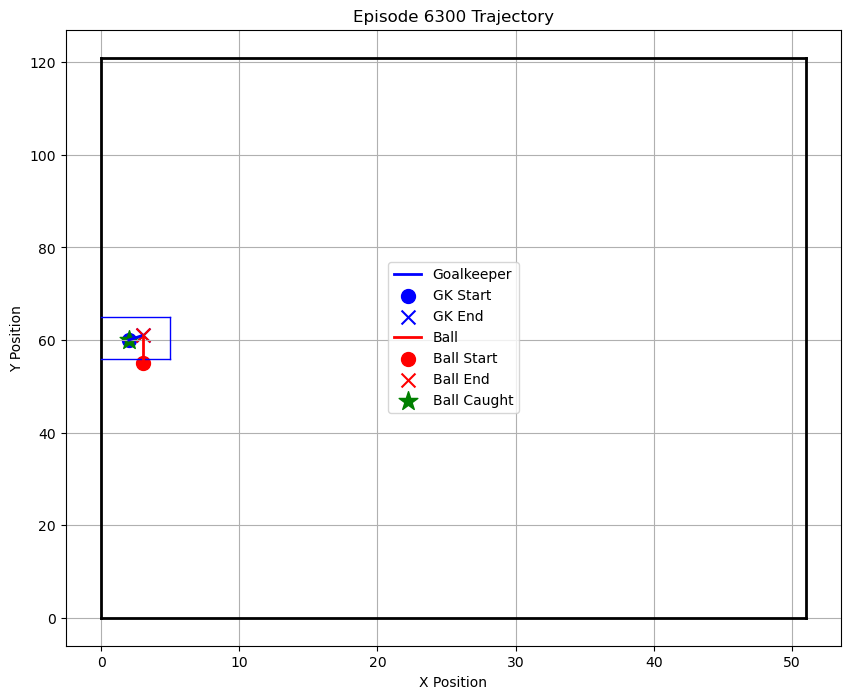

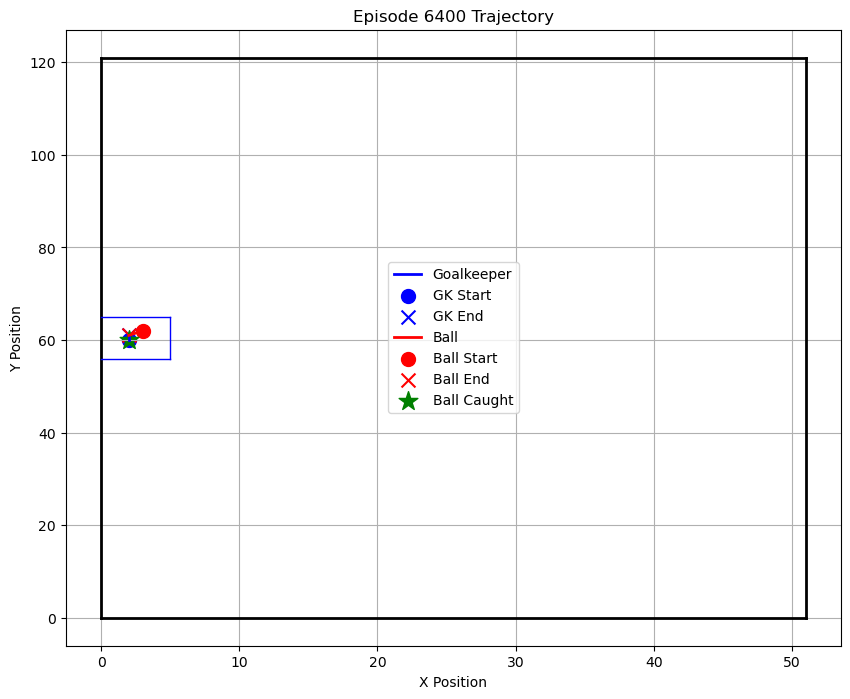

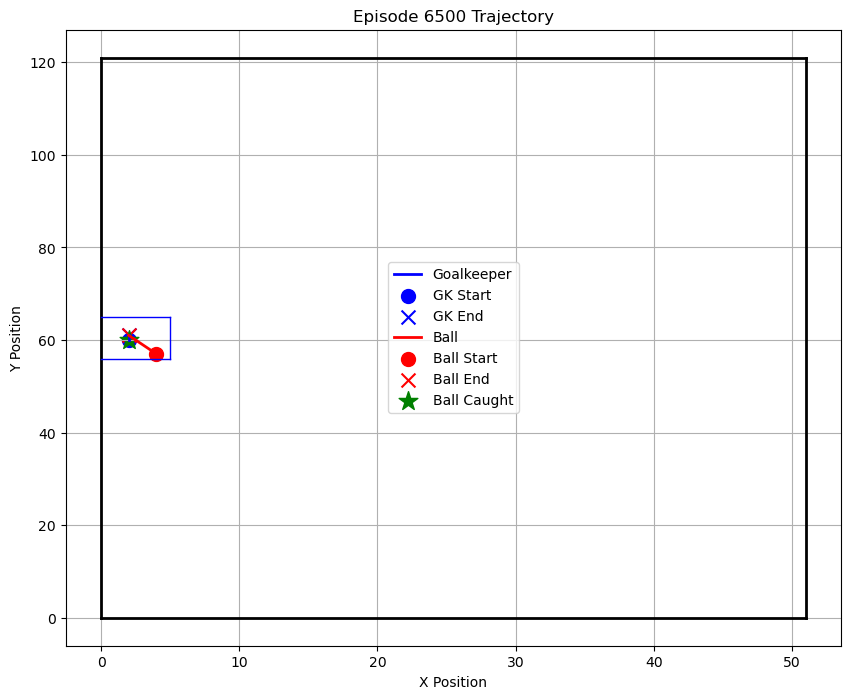

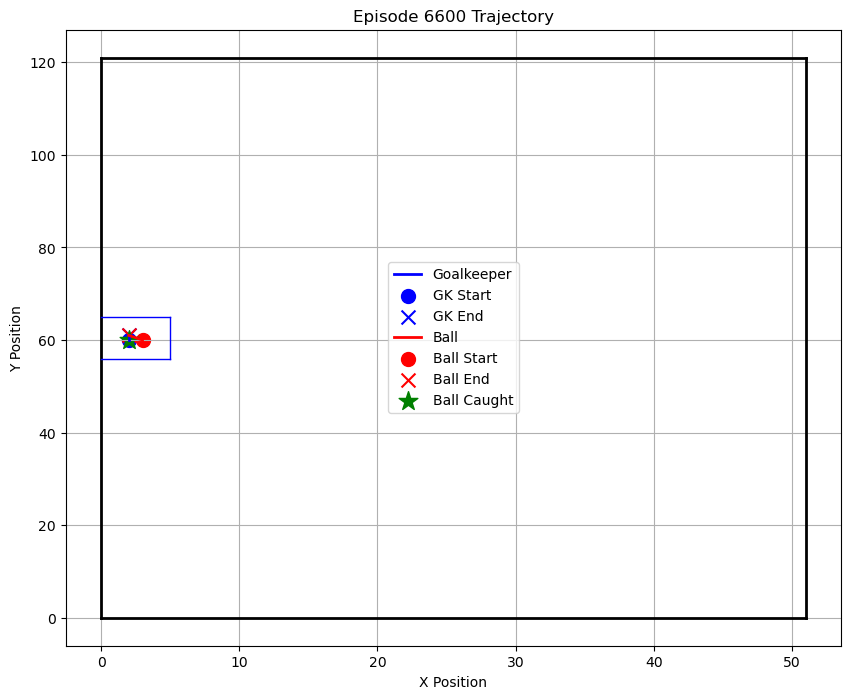

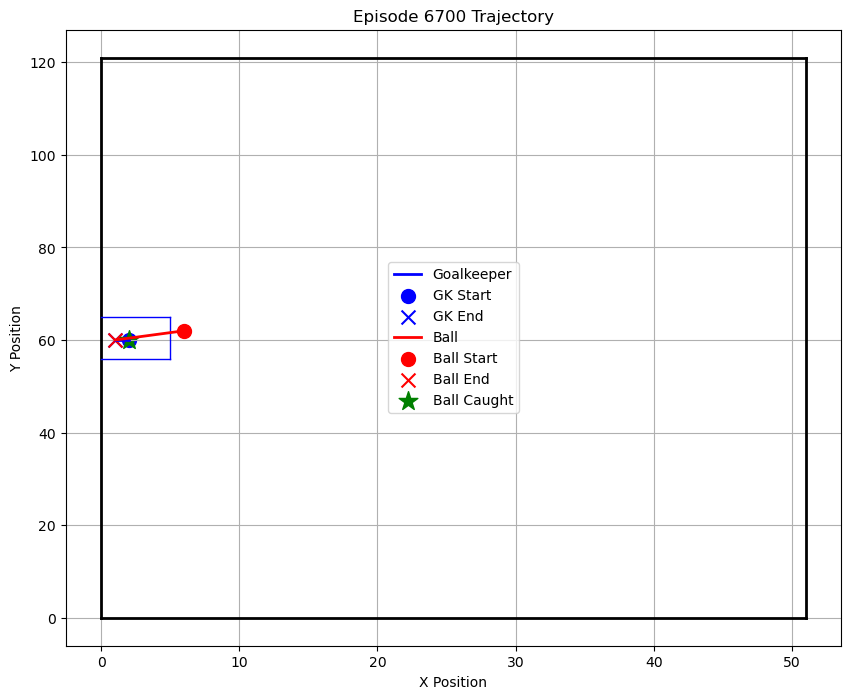

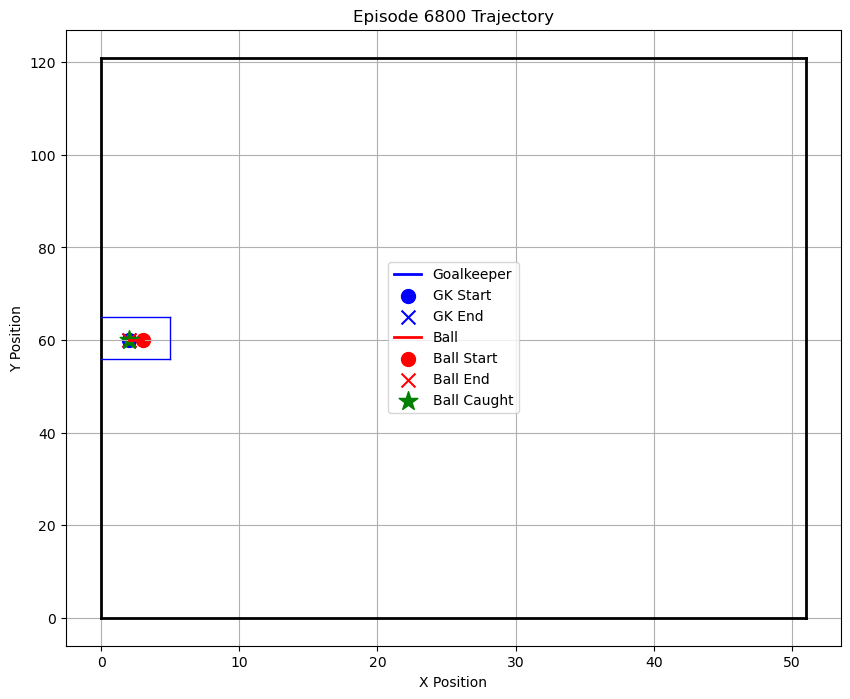

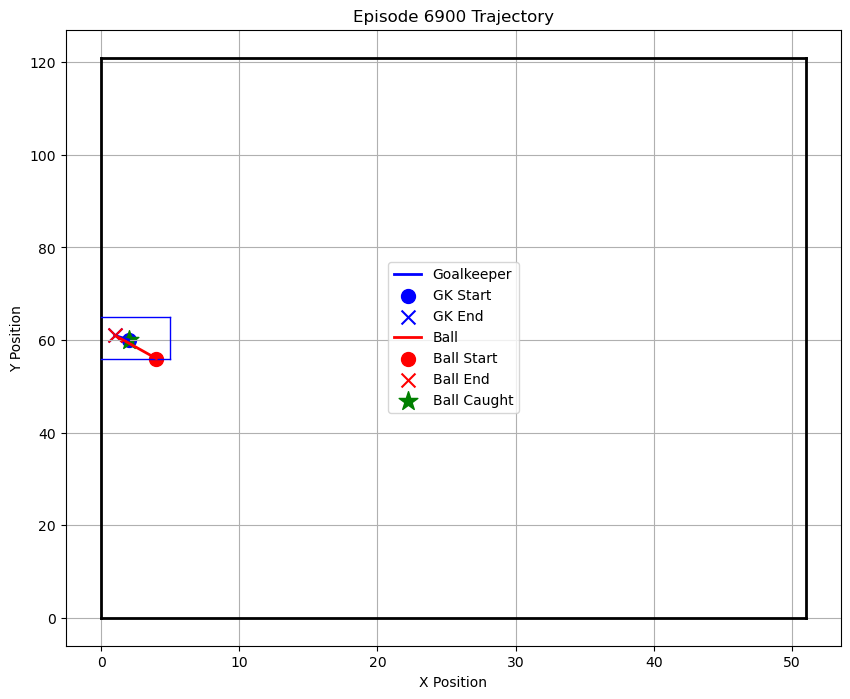

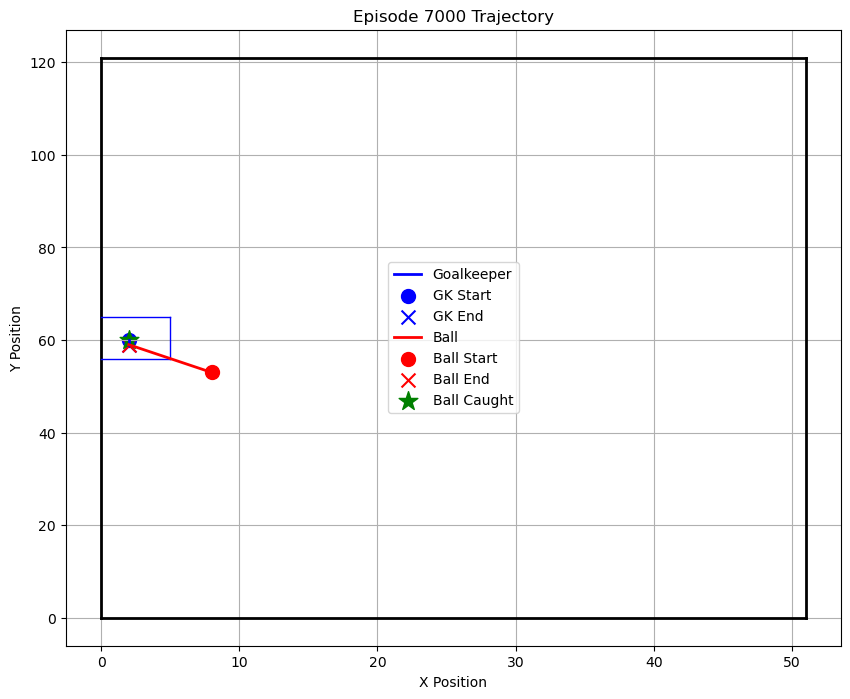

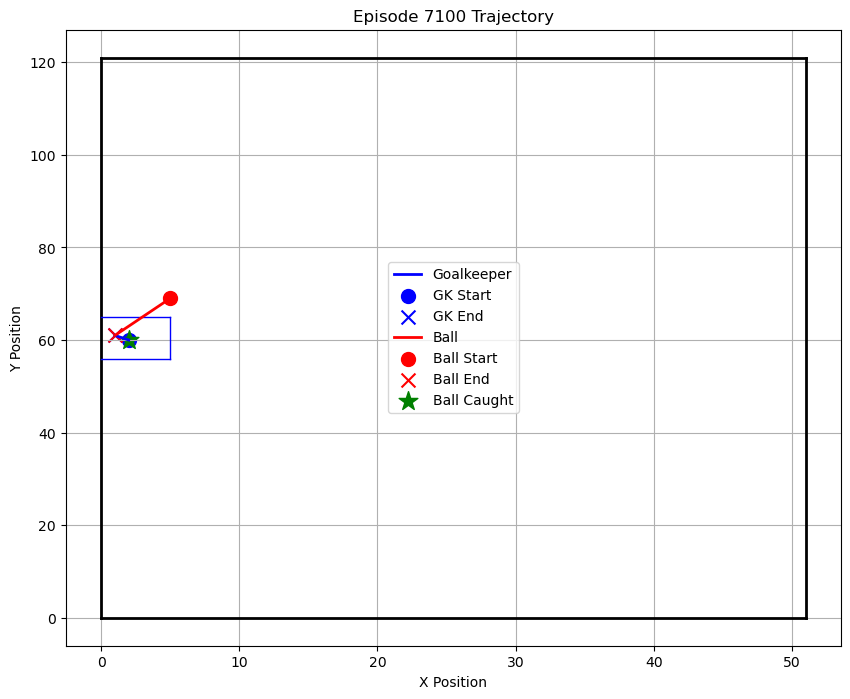

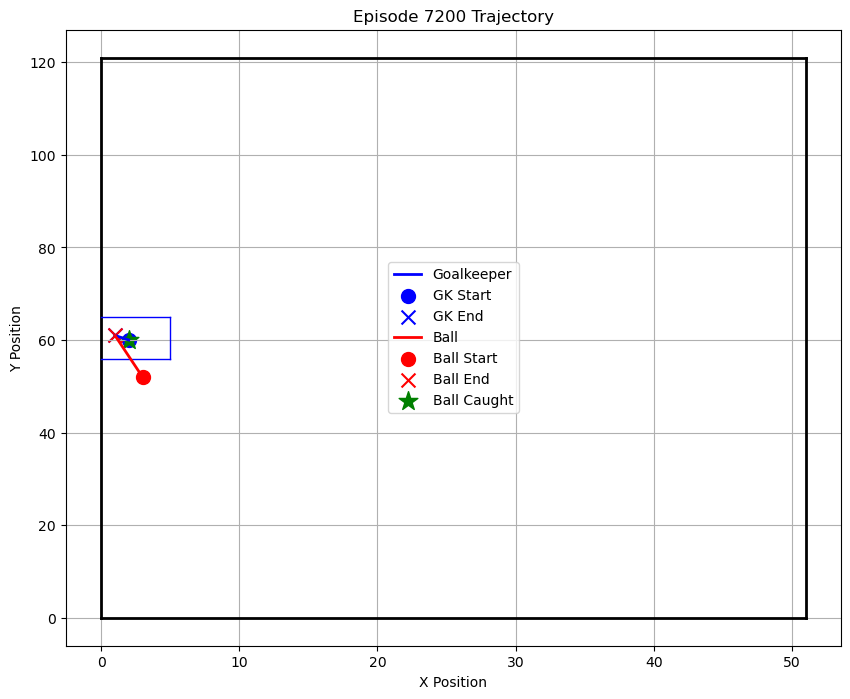

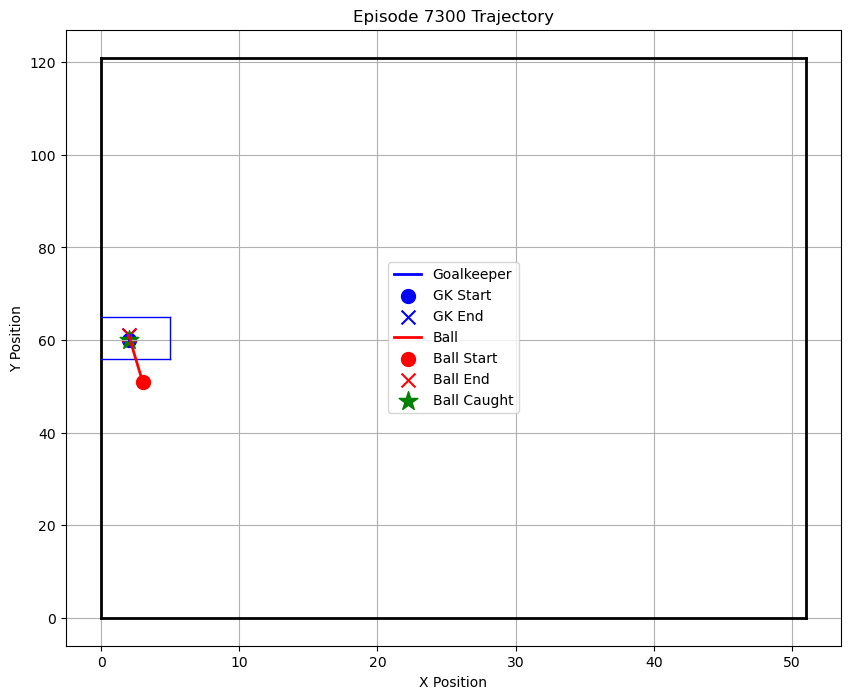

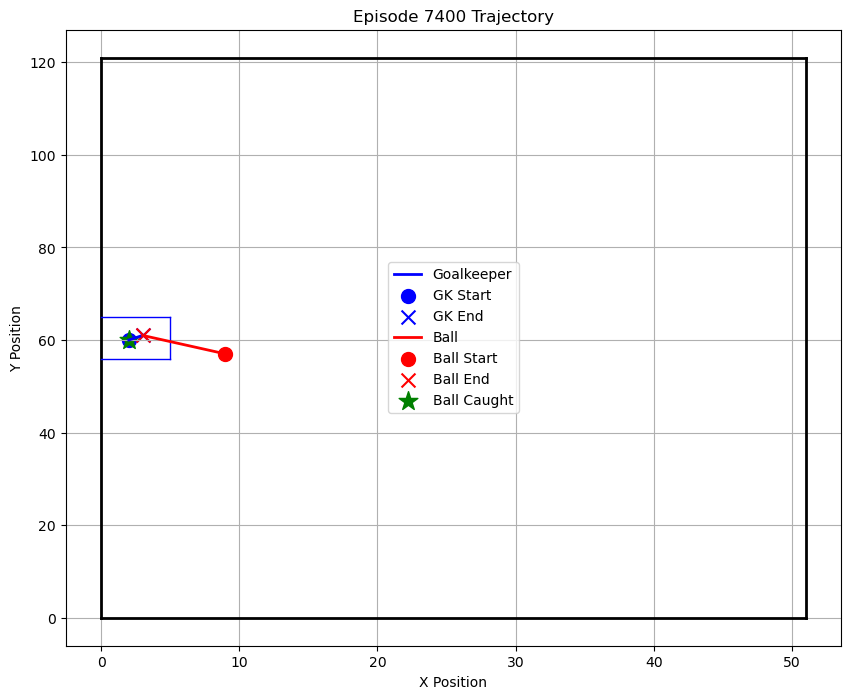

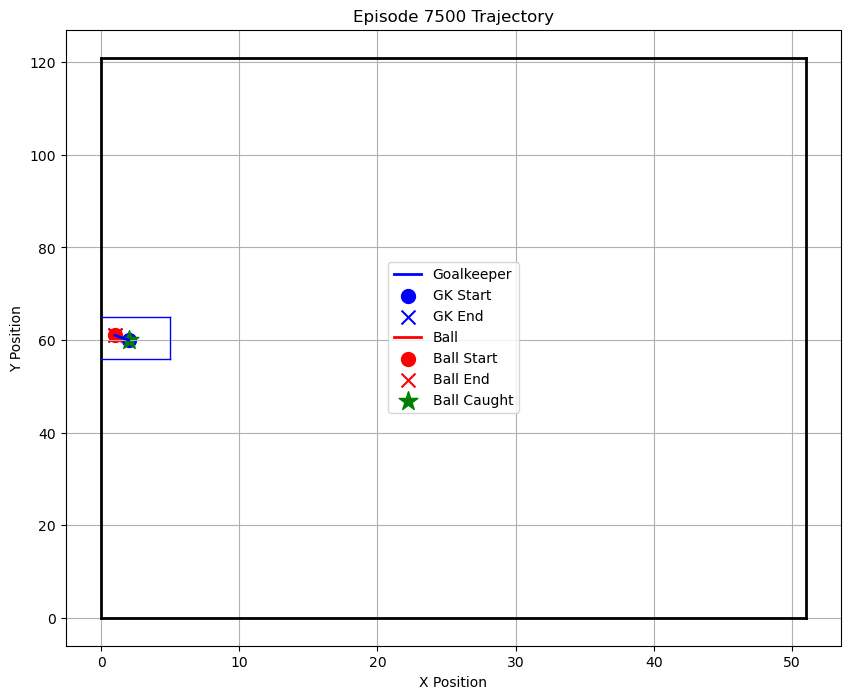

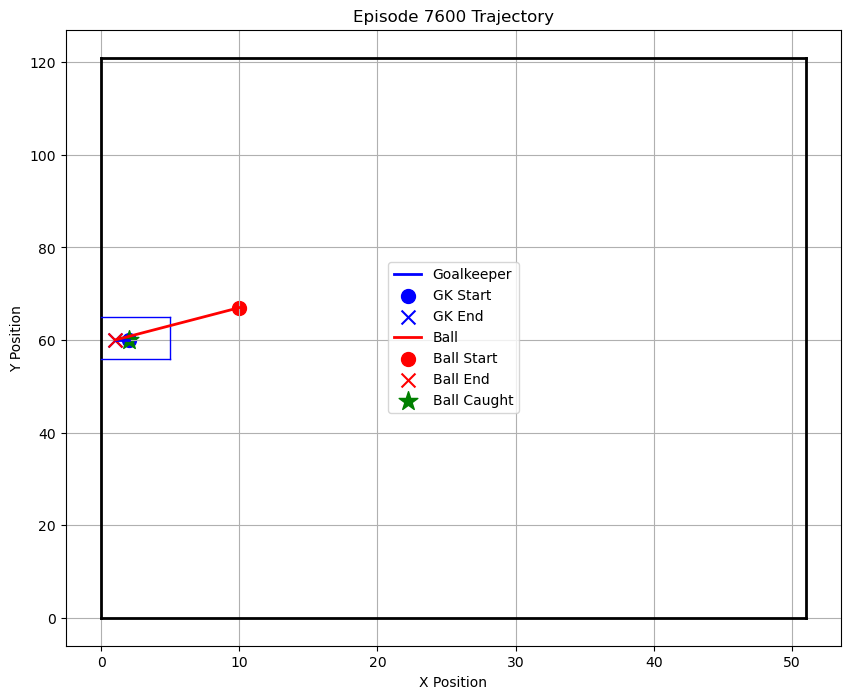

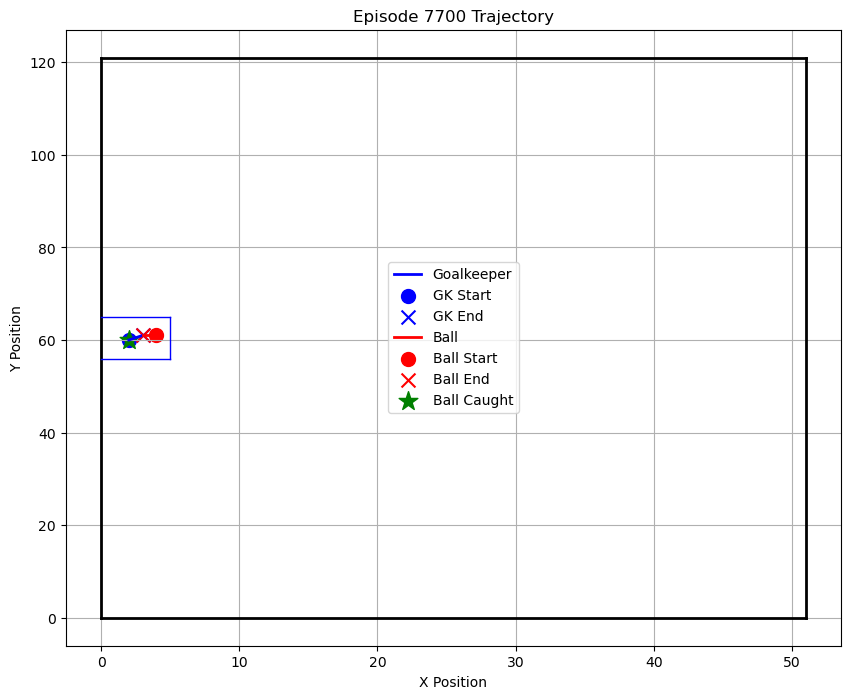

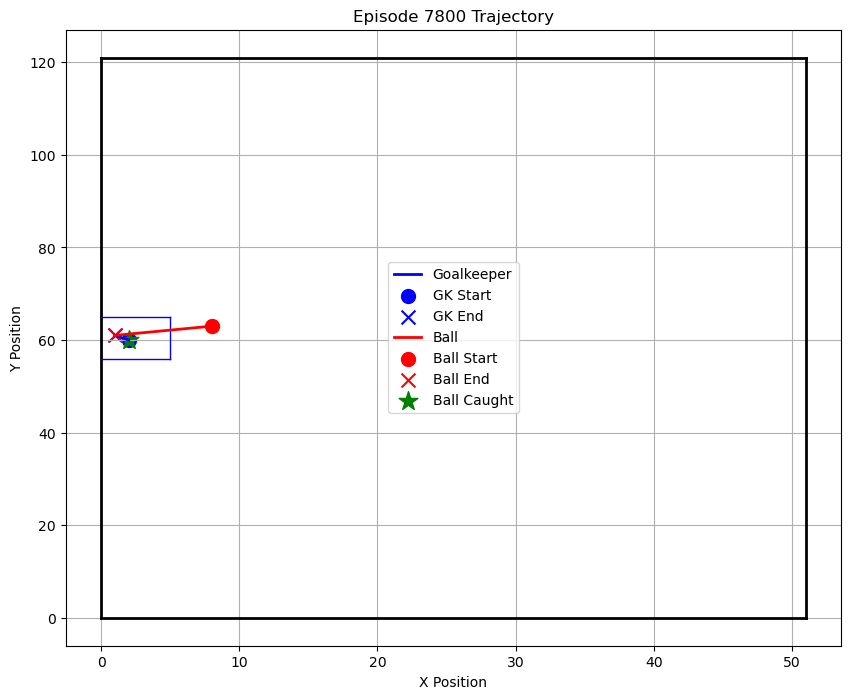

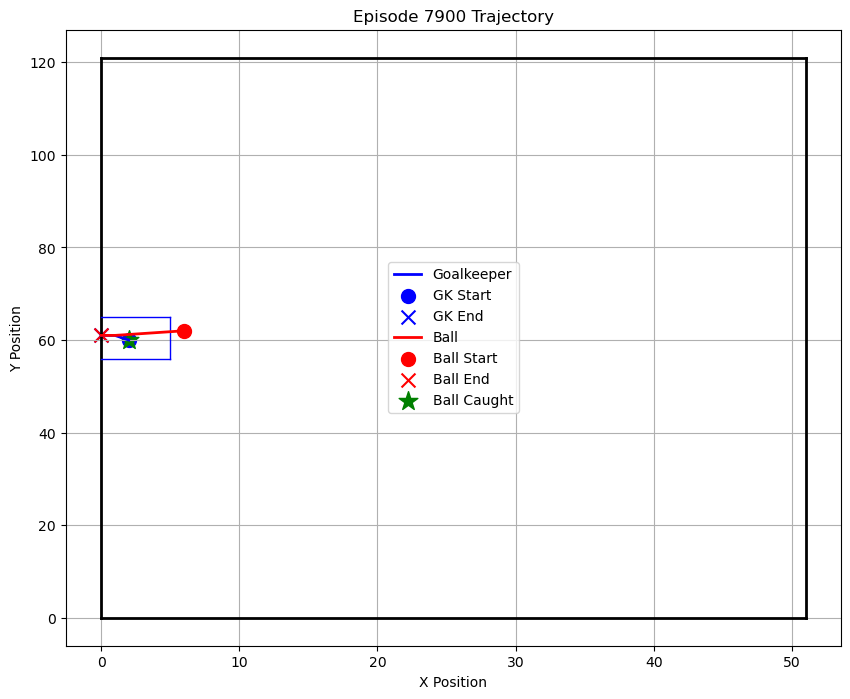

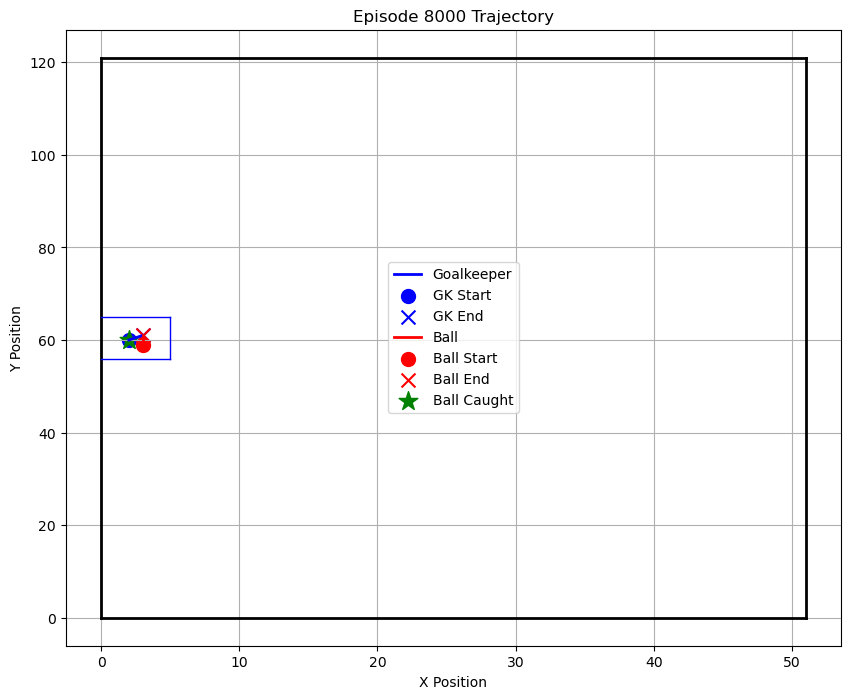

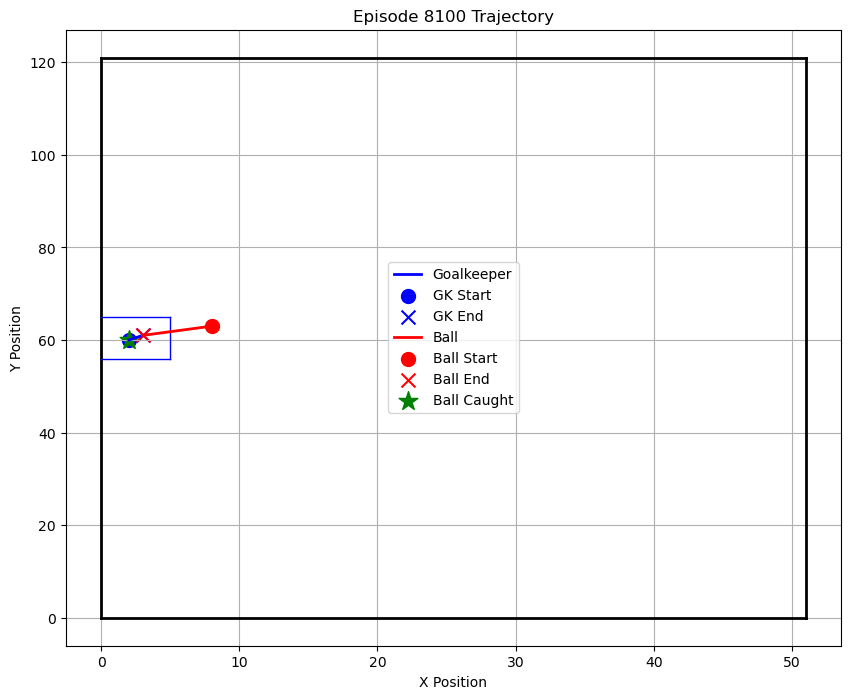

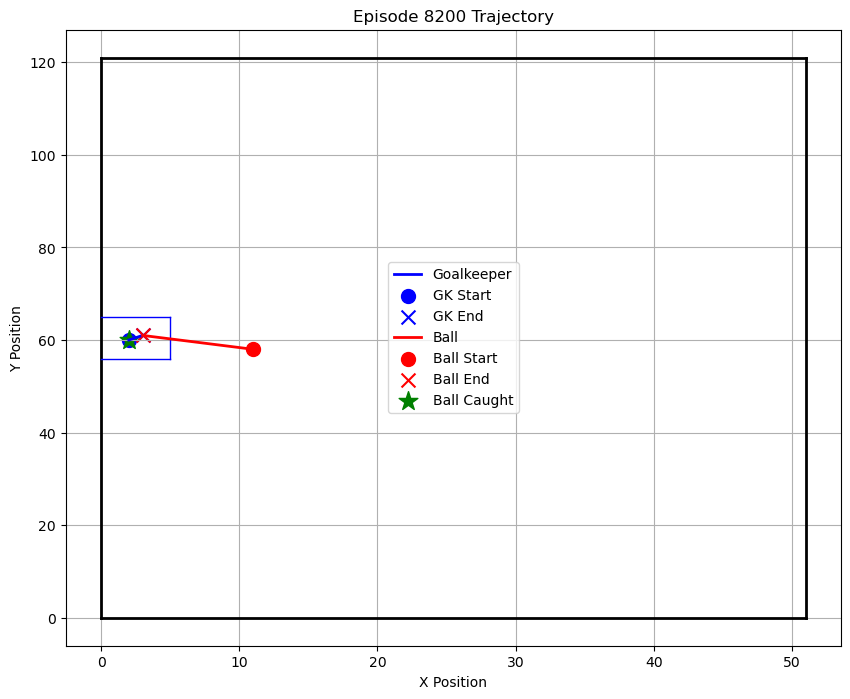

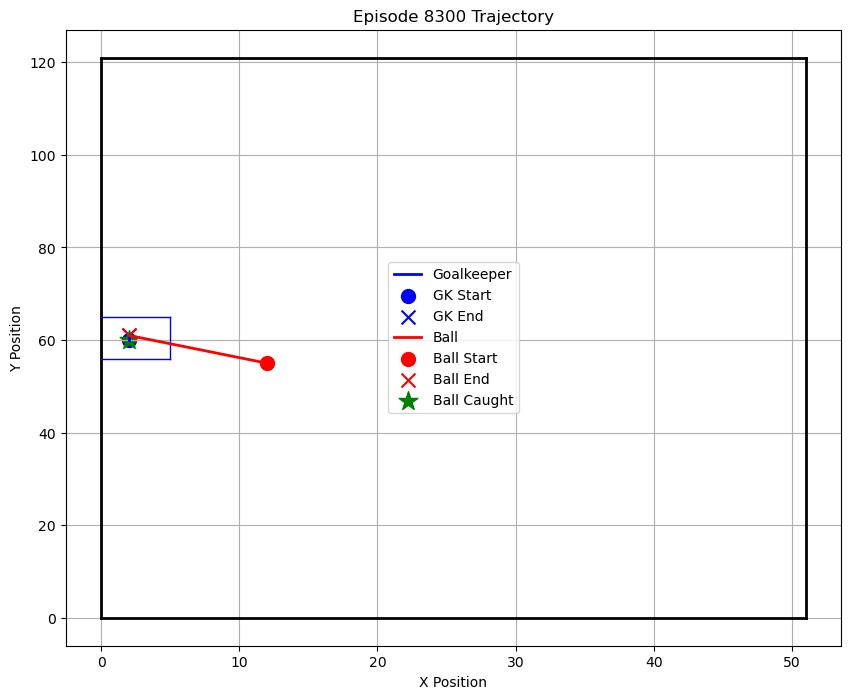

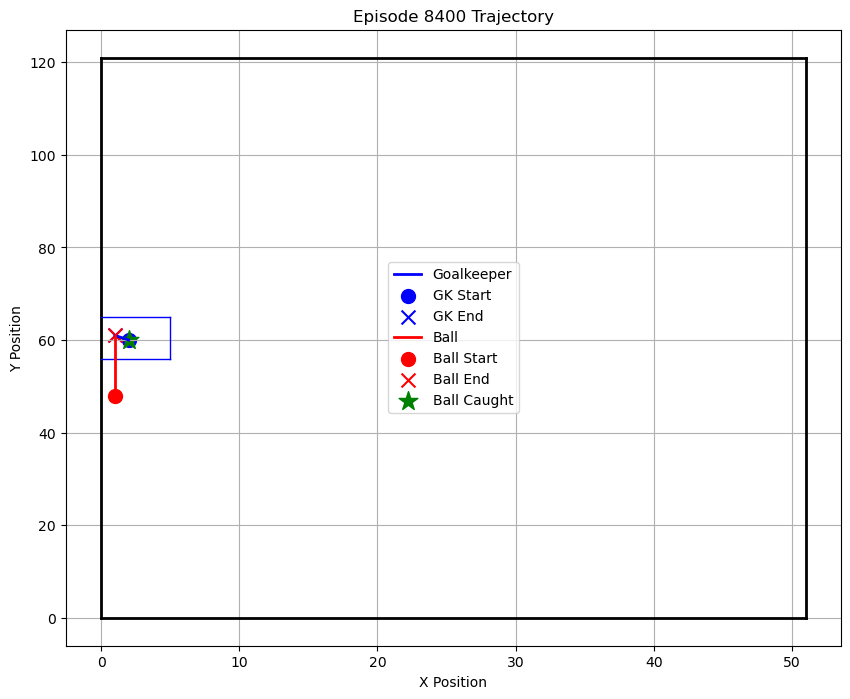

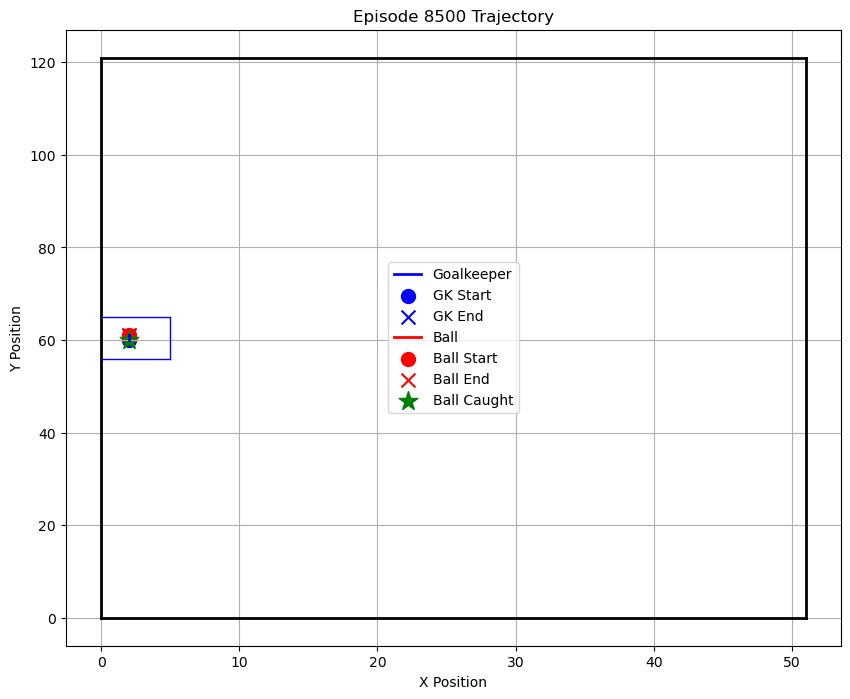

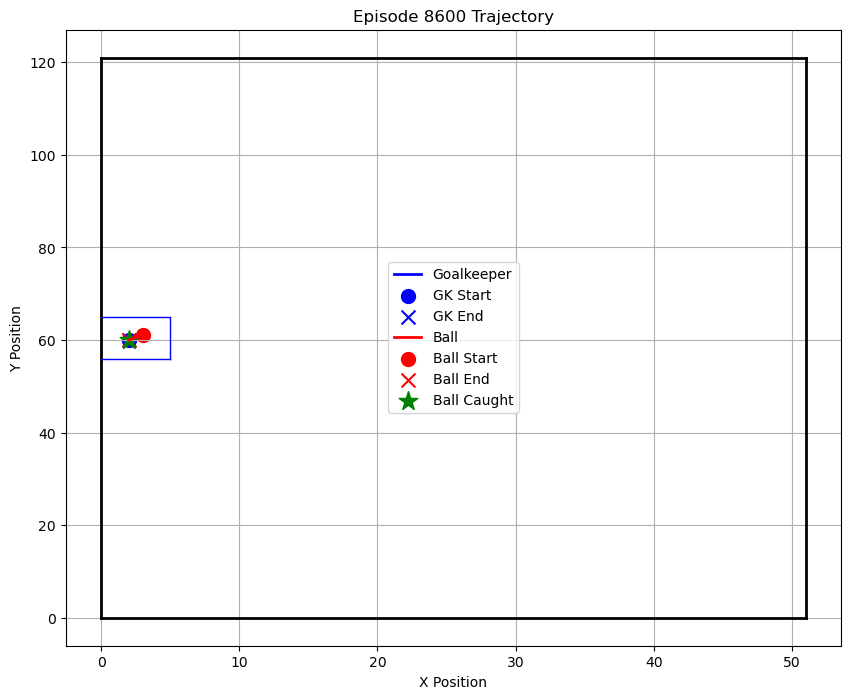

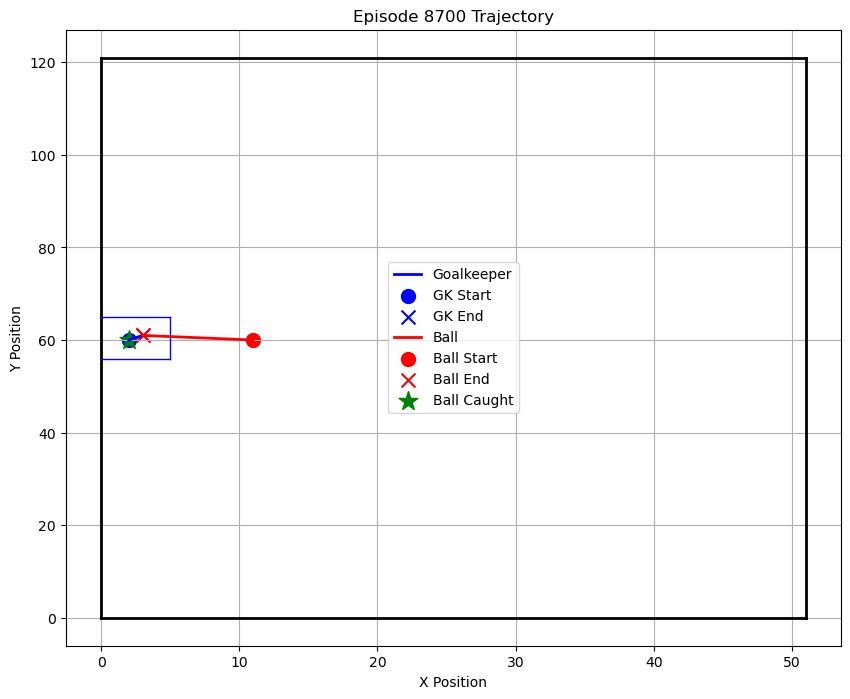

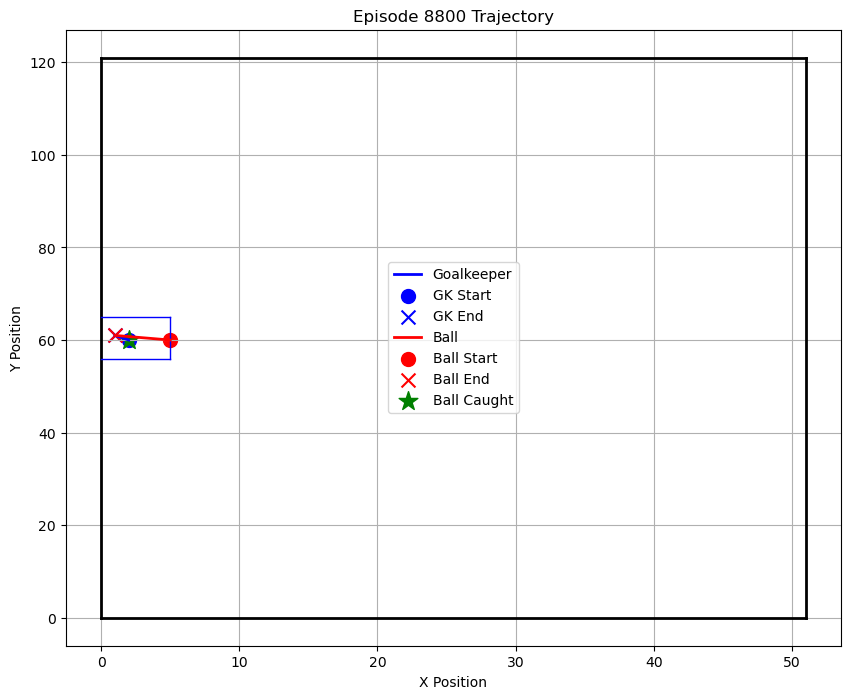

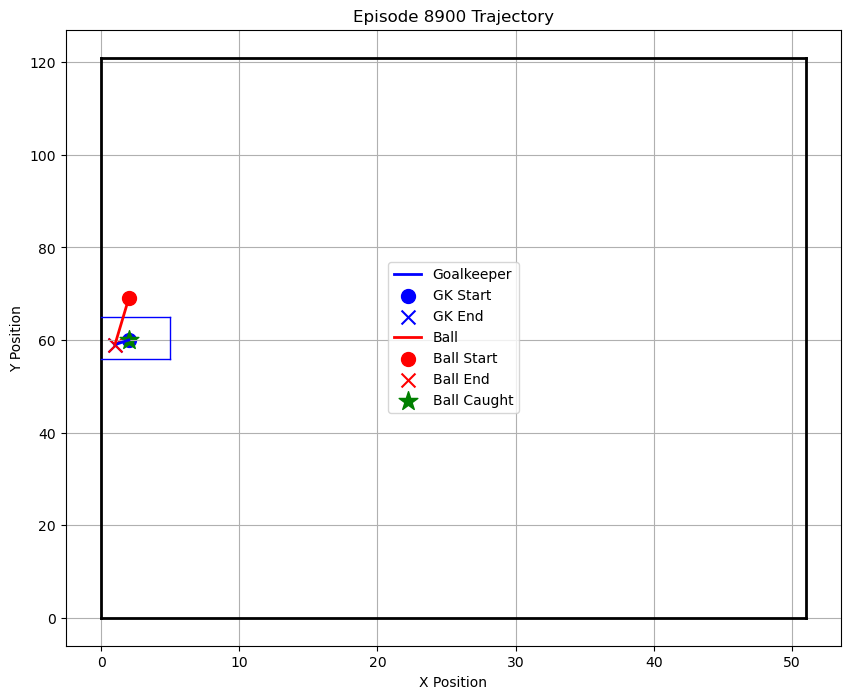

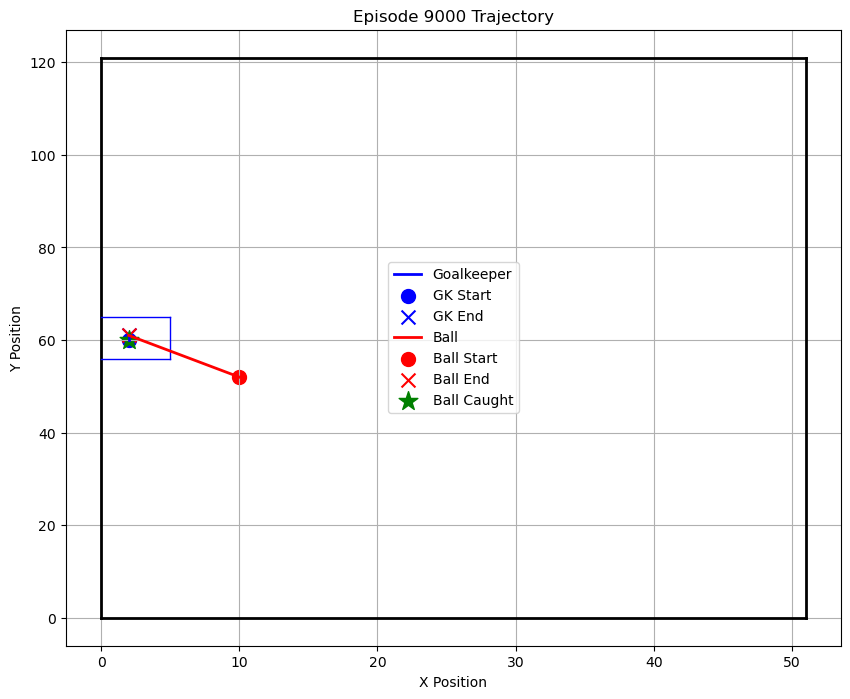

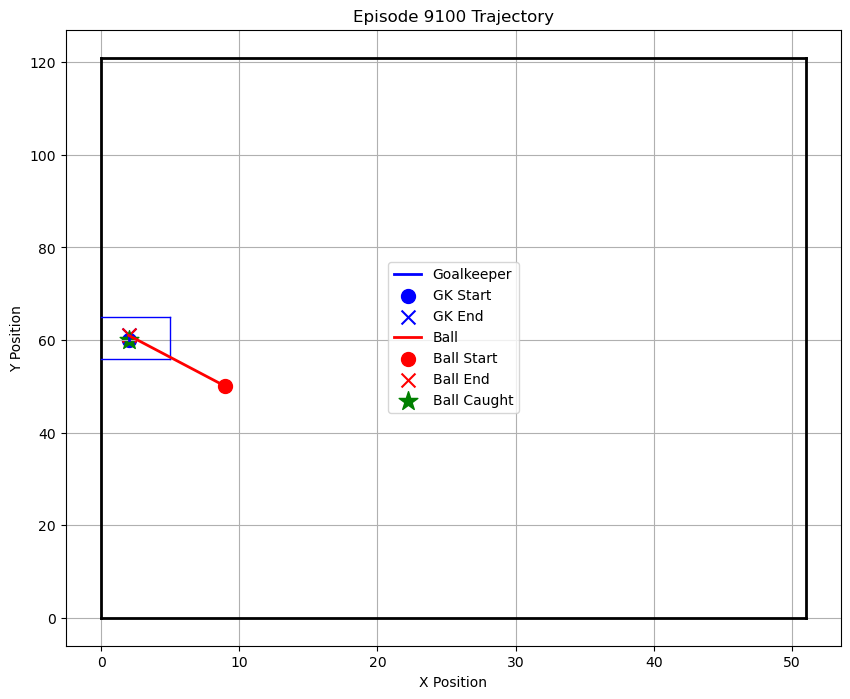

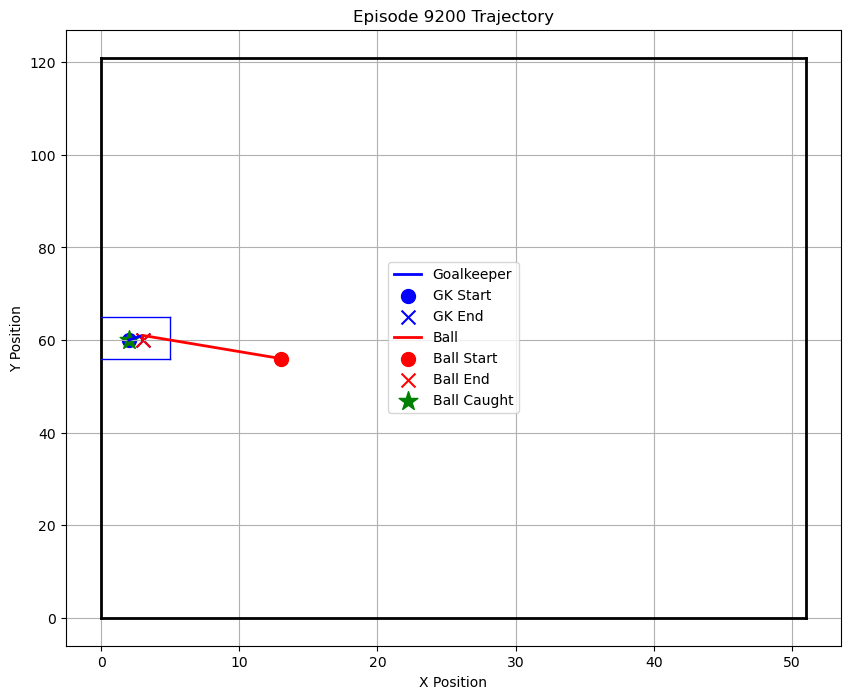

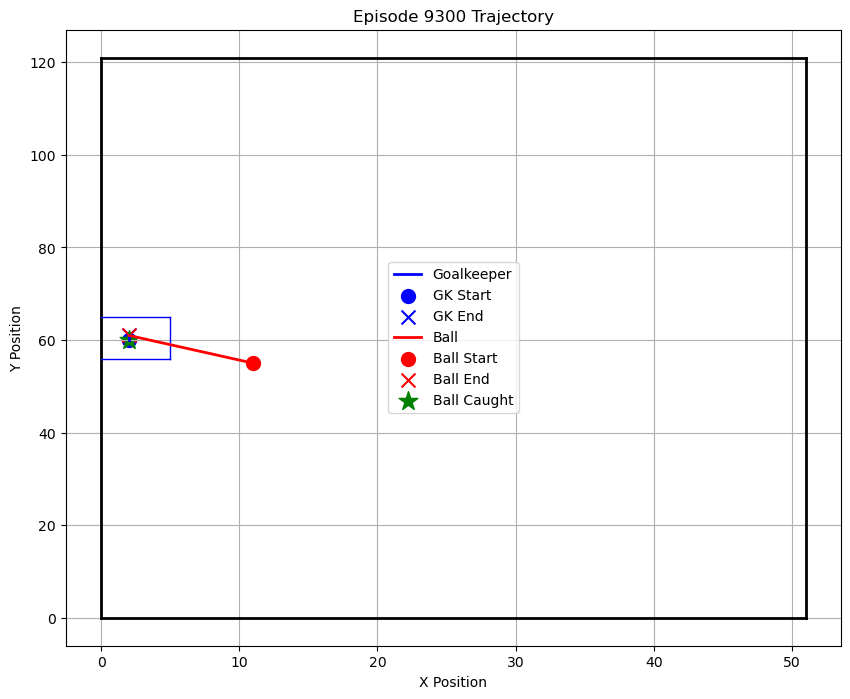

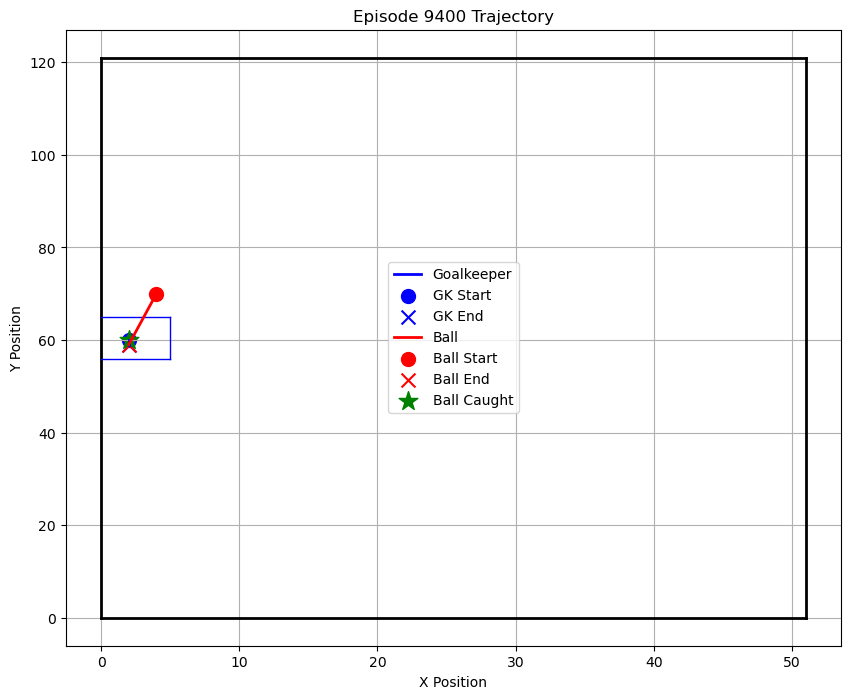

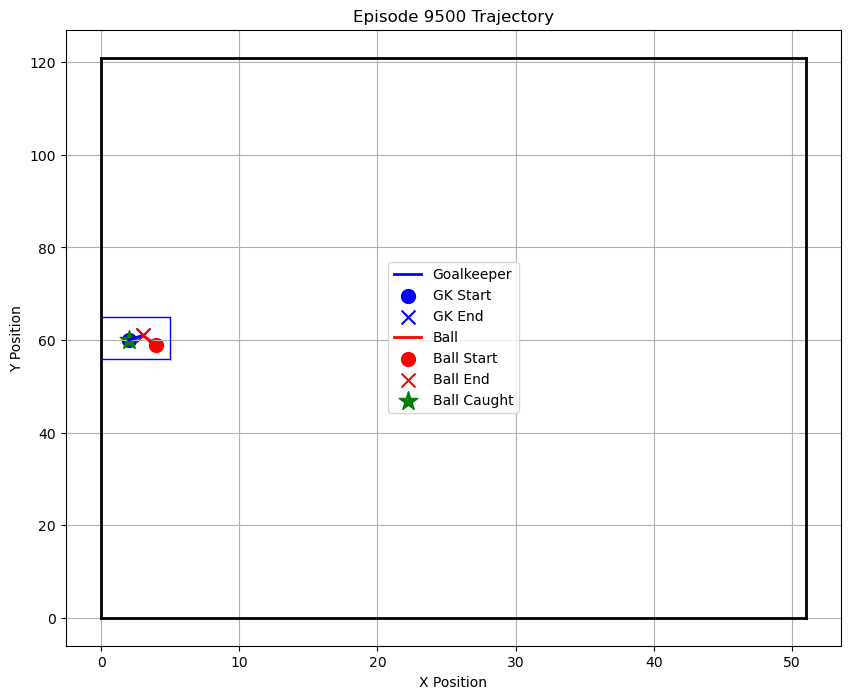

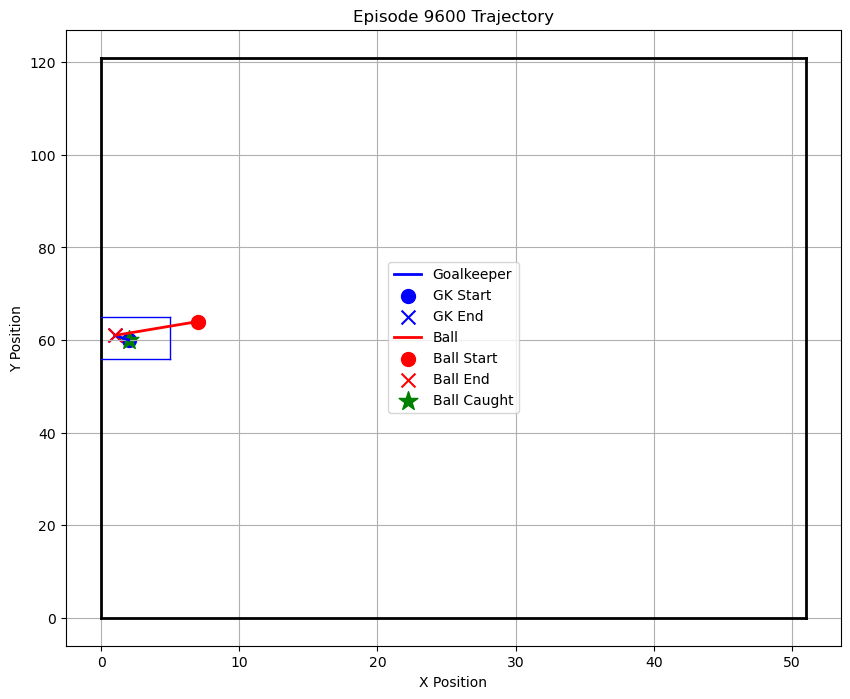

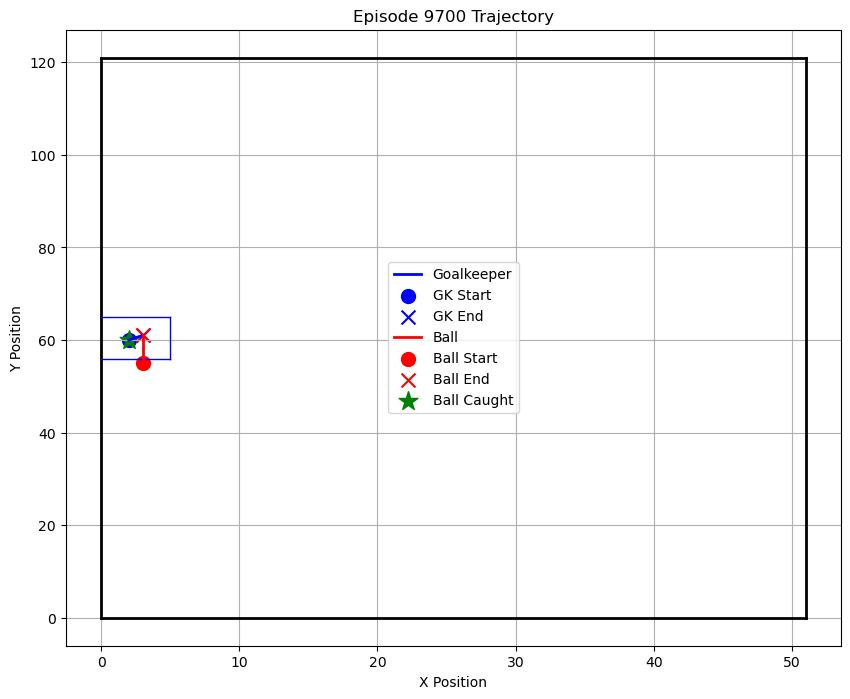

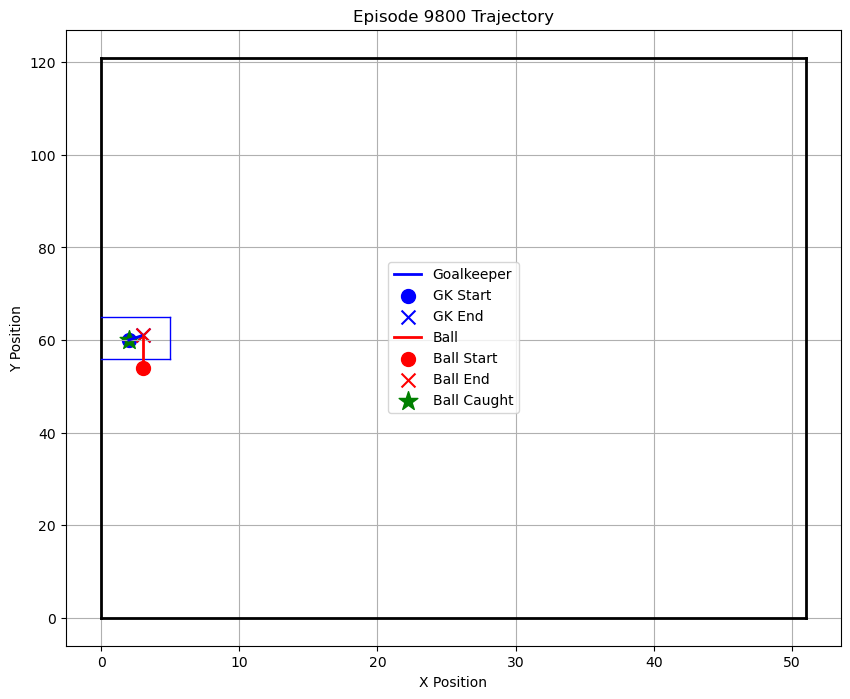

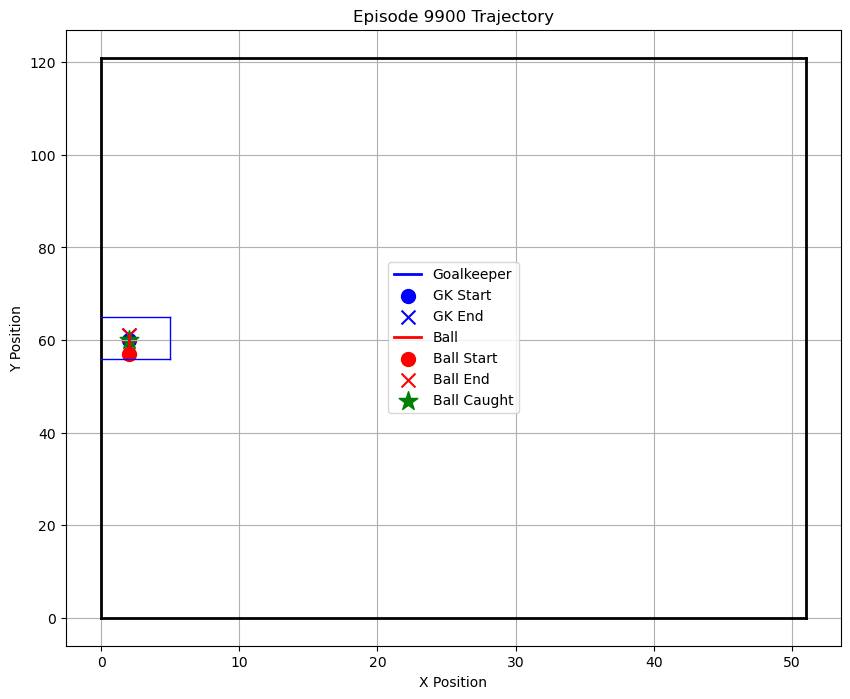

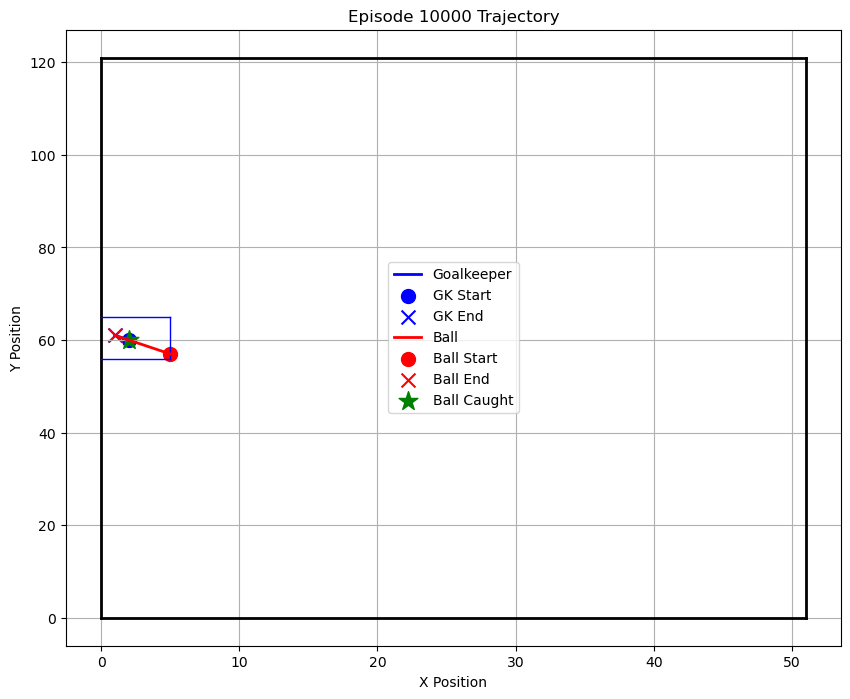

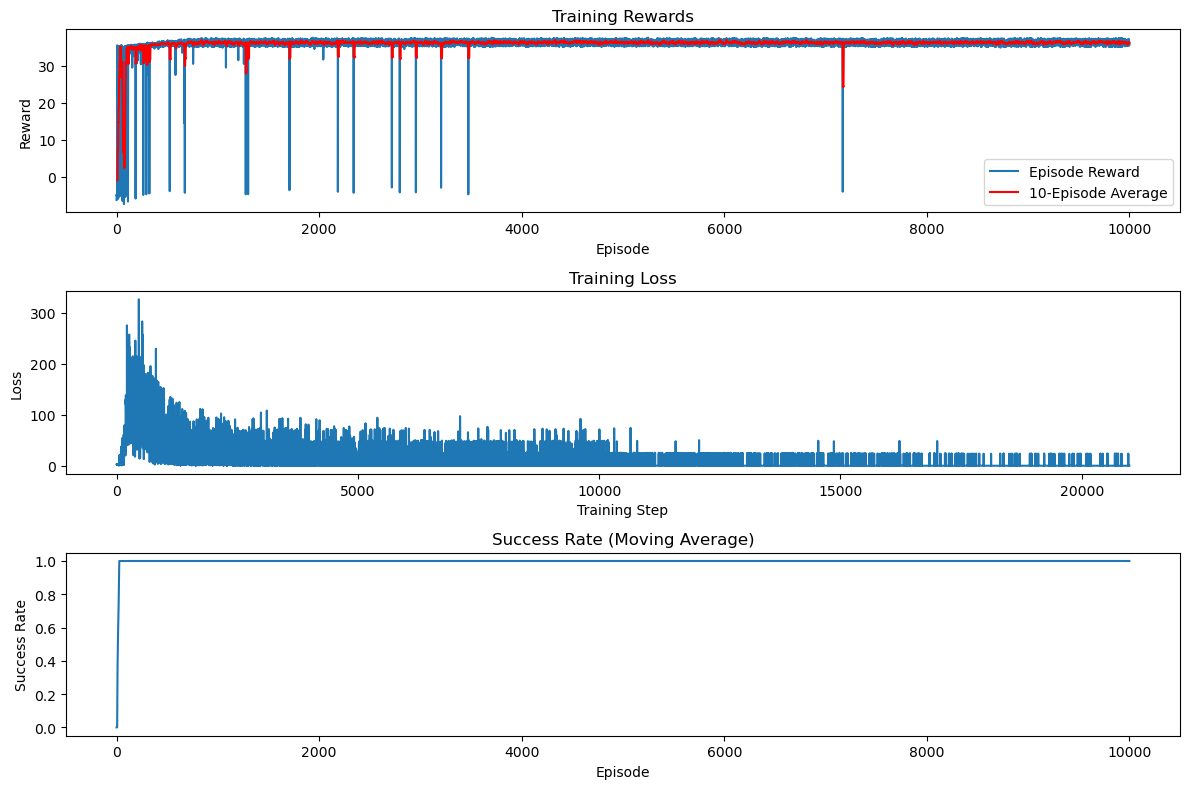

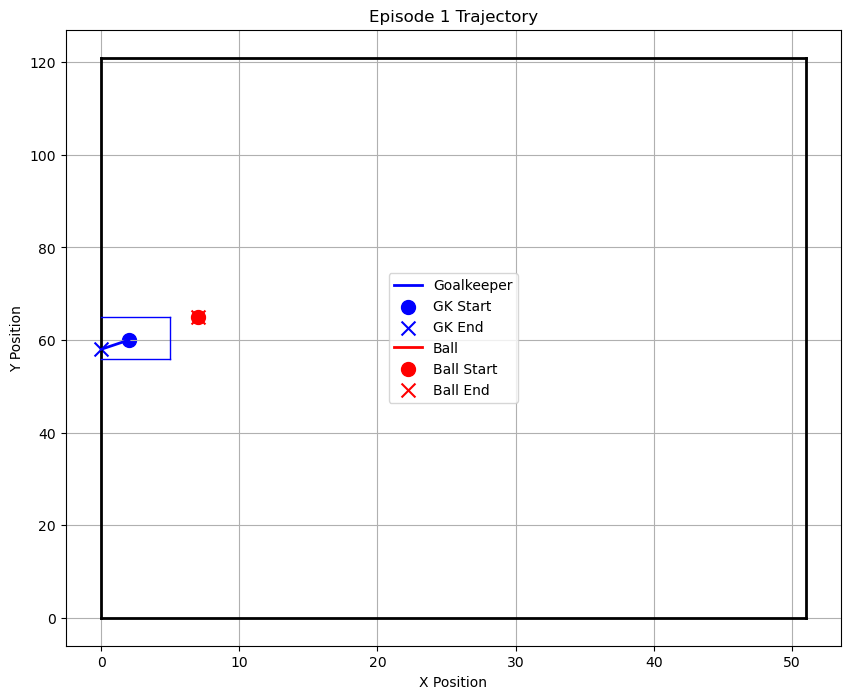

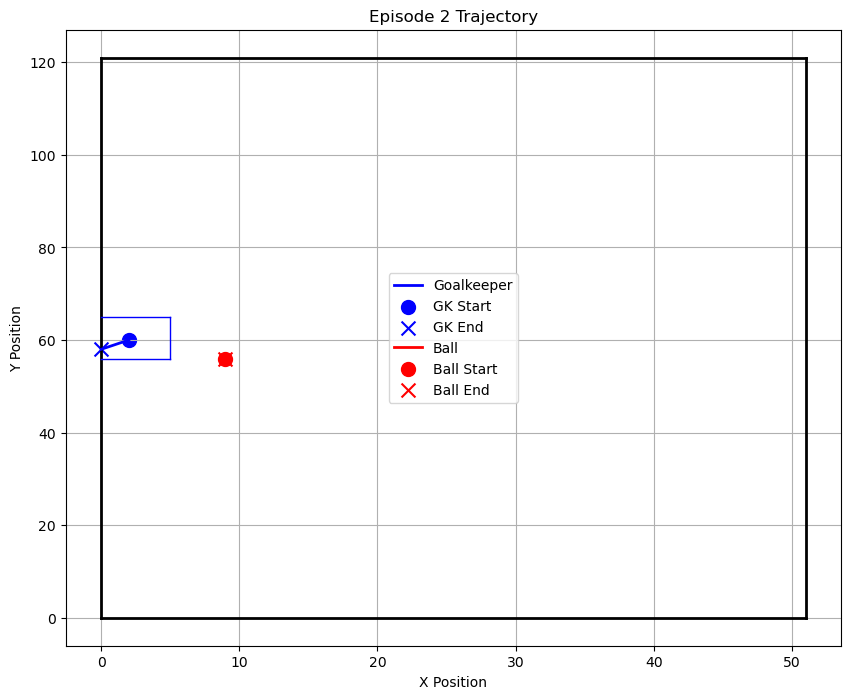

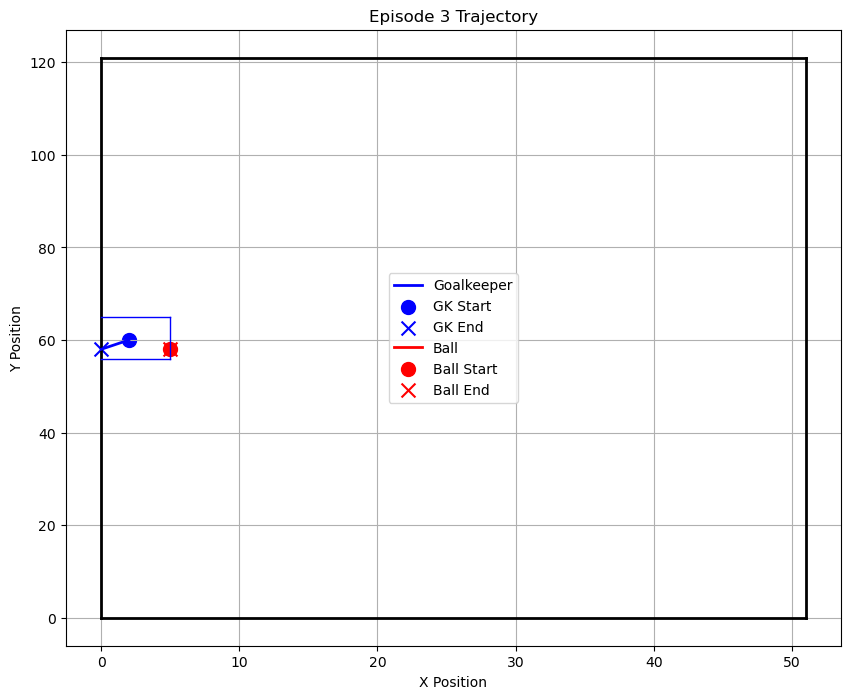

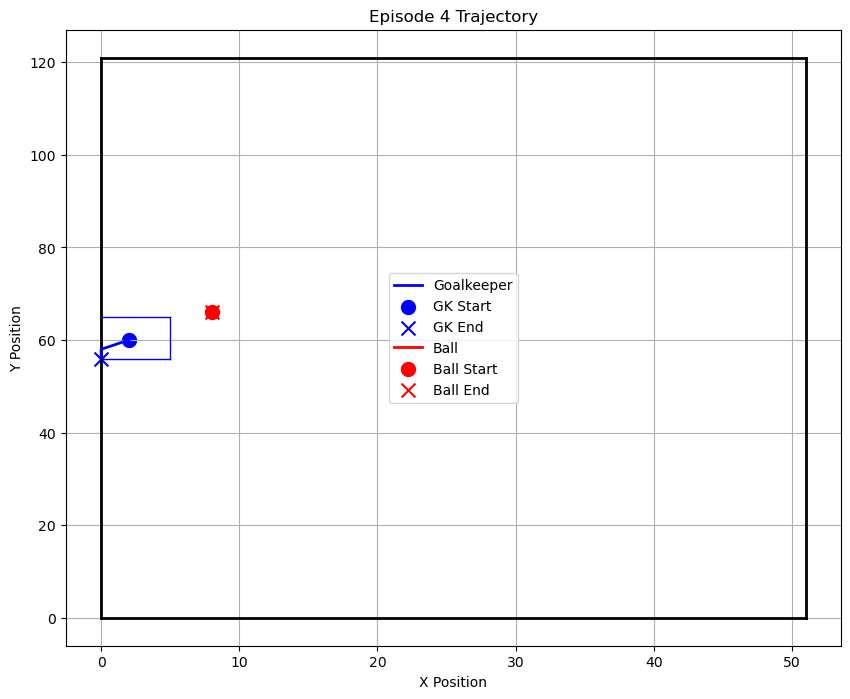

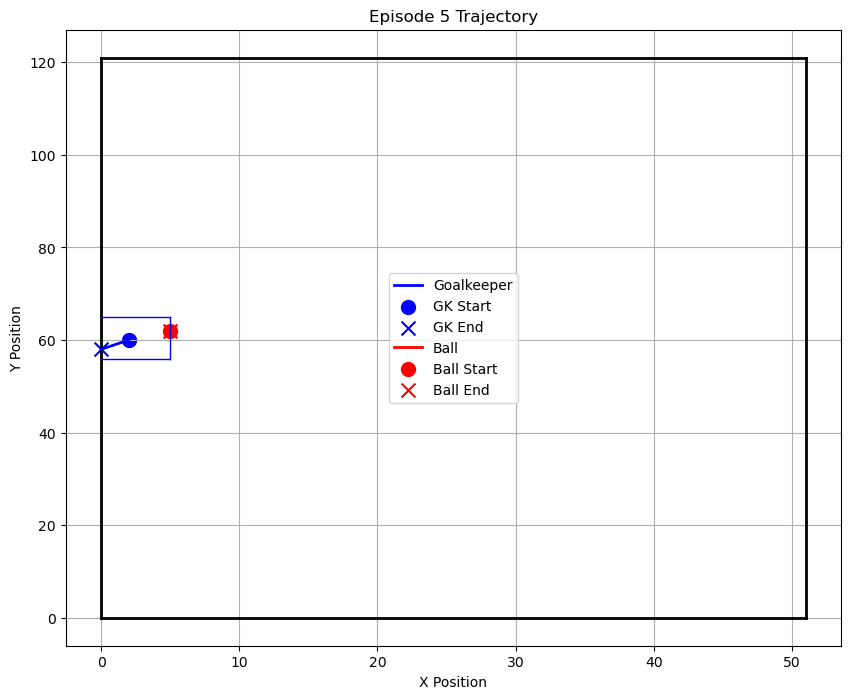

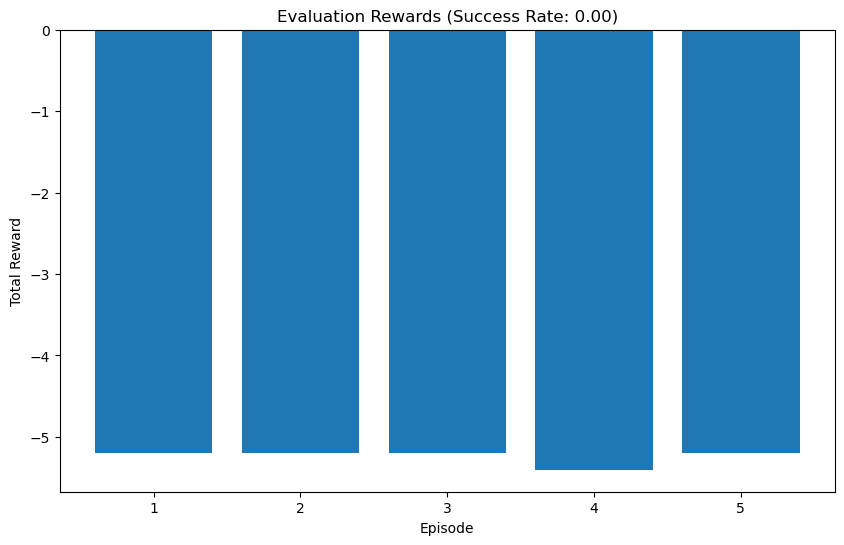

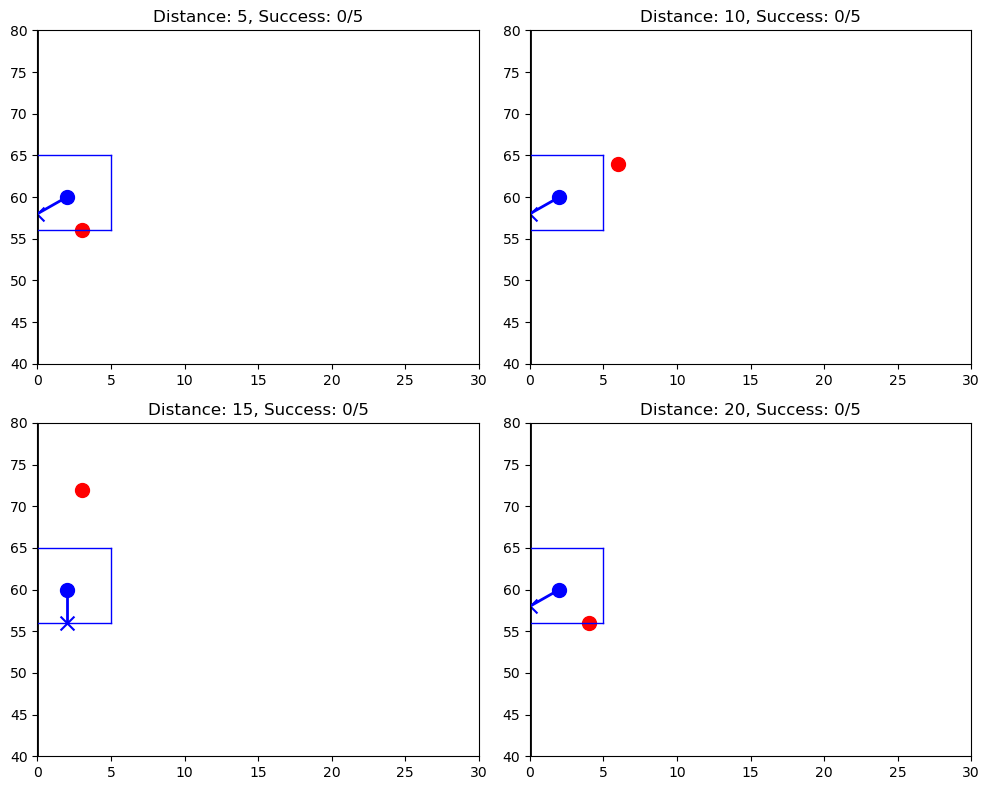

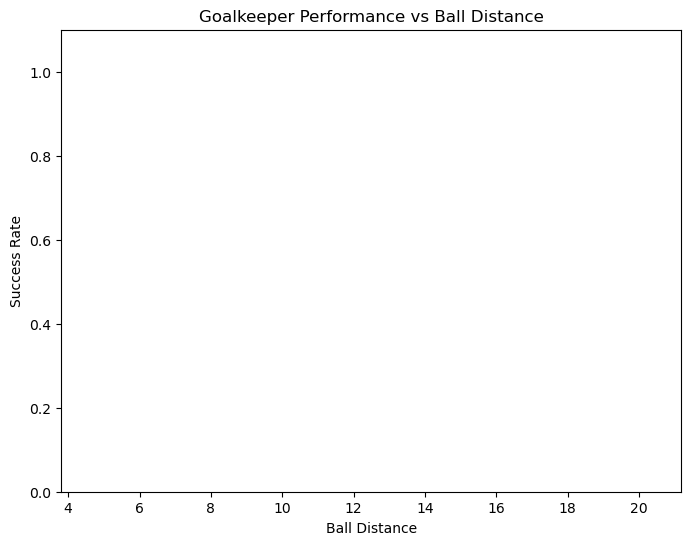

In [4]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import time
import os

# Make sure output directory exists
if not os.path.exists('outputs'):
    os.makedirs('outputs')

# Set reproducible seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create environment
env = FootballEnv()

# Define curriculum training parameters
total_episodes = 10000  # Total episodes for training
curriculum_stages = 8  # Number of difficulty stages
episodes_per_stage = 100  # Episodes per stage
max_steps_per_episode = 50  # Max steps per episode

# Train goalkeeper with curriculum learning
print("Starting curriculum training for goalkeeper agent...")
trained_goalkeeper_agent = curriculum_train_goalkeeper(
    env, 
    episodes=total_episodes,
    stages=curriculum_stages,
    episodes_per_stage=episodes_per_stage,
    max_steps=max_steps_per_episode
)

# Save the trained agent
torch.save(trained_goalkeeper_agent.model.state_dict(), 'outputs/goalkeeper_model.pth')
print("Training complete! Model saved to 'outputs/goalkeeper_model.pth'")

# Plot learning curves
plt.figure(figsize=(15, 10))

# Rewards plot
plt.subplot(2, 2, 1)
plt.plot(trained_goalkeeper_agent.rewards_history)
# Plot curriculum stage boundaries
for i in range(1, curriculum_stages):
    plt.axvline(x=i*episodes_per_stage, color='r', linestyle='--')
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# Moving average rewards
plt.subplot(2, 2, 2)
window_size = 10
moving_avg = []
for i in range(len(trained_goalkeeper_agent.rewards_history) - window_size + 1):
    moving_avg.append(np.mean(trained_goalkeeper_agent.rewards_history[i:i+window_size]))
plt.plot(range(window_size-1, len(trained_goalkeeper_agent.rewards_history)), moving_avg)
for i in range(1, curriculum_stages):
    plt.axvline(x=i*episodes_per_stage, color='r', linestyle='--')
plt.title(f'{window_size}-Episode Moving Average Reward')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

# Loss history
plt.subplot(2, 2, 3)
if trained_goalkeeper_agent.loss_history:
    # Smooth the loss curve (too many points)
    smoothed_loss = []
    smoothing_window = 50
    for i in range(0, len(trained_goalkeeper_agent.loss_history), smoothing_window):
        end = min(i + smoothing_window, len(trained_goalkeeper_agent.loss_history))
        smoothed_loss.append(np.mean(trained_goalkeeper_agent.loss_history[i:end]))
    plt.plot(range(0, len(trained_goalkeeper_agent.loss_history), smoothing_window), smoothed_loss)
    plt.title('Training Loss (Smoothed)')
    plt.xlabel('Training Step (x{})'.format(smoothing_window))
    plt.ylabel('Loss')

# Save the full training plot
plt.tight_layout()
plt.savefig('outputs/training_curves.png')
print("Training curves saved to 'outputs/training_curves.png'")
plt.close()

# Evaluate the trained agent
print("\nEvaluating trained goalkeeper agent...")
num_eval_episodes = 5
evaluate_goalkeeper_agent(
    trained_goalkeeper_agent, 
    env, 
    episodes=num_eval_episodes, 
    max_steps=max_steps_per_episode, 
    render=True
)

# Additional visualizations to show how goalkeeper performs at different distances
print("\nGenerating performance visualization at different ball distances...")

# Test distances
test_distances = [5, 10, 15, 20]
success_counts = []

plt.figure(figsize=(10, 8))

for i, distance in enumerate(test_distances):
    print(f"\nTesting with ball distance: {distance}")
    successes = 0
    trials = 5
    
    for trial in range(trials):
        # Reset with fixed distance
        players = [Player('GK', 0, env)]
        env.reset(players, ball_spawn_radius=distance)
        
        # Run episode
        done = False
        truncated = False
        
        for step in range(max_steps_per_episode):
            if done or truncated:
                break
                
            state = env._get_state(players[0], players)
            action = trained_goalkeeper_agent.act(state, evaluate=True)
            next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
            
        # Check for success
        if players[0].has_ball:
            successes += 1
        
        # Plot the last trajectory at each distance
        if trial == trials - 1:
            plt.subplot(2, 2, i+1)
            # Plot field
            plt.plot([0, 0], [0, env.grid_rows], 'k-', linewidth=2)
            plt.plot([env.grid_cols, env.grid_cols], [0, env.grid_rows], 'k-', linewidth=2)
            plt.plot([0, env.grid_cols], [0, 0], 'k-', linewidth=2)
            plt.plot([0, env.grid_cols], [env.grid_rows, env.grid_rows], 'k-', linewidth=2)
            
            # Plot D box
            d_box_min_row, d_box_max_row = env.grid_rows // 2 - 4, env.grid_rows // 2 + 5
            plt.plot([0, 5], [d_box_min_row, d_box_min_row], 'b-', linewidth=1)
            plt.plot([0, 5], [d_box_max_row, d_box_max_row], 'b-', linewidth=1)
            plt.plot([5, 5], [d_box_min_row, d_box_max_row], 'b-', linewidth=1)
            
            # Extract trajectory
            goalkeeper_positions = [t['player_pos'] for t in env.trajectory]
            ball_positions = [t['ball_pos'] for t in env.trajectory]
            
            # Plot goalkeeper trajectory
            gk_x = [pos[1] for pos in goalkeeper_positions]
            gk_y = [pos[0] for pos in goalkeeper_positions]
            plt.plot(gk_x, gk_y, 'b-', linewidth=2)
            plt.scatter(gk_x[0], gk_y[0], color='blue', s=100, marker='o')
            plt.scatter(gk_x[-1], gk_y[-1], color='blue', s=100, marker='x')
            
            # Plot ball (static in this test)
            ball_x, ball_y = ball_positions[0][1], ball_positions[0][0]
            plt.scatter(ball_x, ball_y, color='red', s=100, marker='o')
            
            plt.title(f'Distance: {distance}, Success: {successes}/{trials}')
            plt.xlim(0, 30)  # Focus on the goal area
            plt.ylim(env.grid_rows//2 - 20, env.grid_rows//2 + 20)
    
    success_counts.append(successes)
    print(f"Success rate at distance {distance}: {successes}/{trials}")

plt.tight_layout()
plt.savefig('outputs/distance_performance.png')
print("Distance performance visualization saved to 'outputs/distance_performance.png'")

# Plot success rate vs distance
plt.figure(figsize=(8, 6))
plt.bar(test_distances, [s/trials for s in success_counts])
plt.xlabel('Ball Distance')
plt.ylabel('Success Rate')
plt.title('Goalkeeper Performance vs Ball Distance')
plt.ylim(0, 1.1)
plt.savefig('outputs/success_vs_distance.png')
print("Success rate vs distance plot saved to 'outputs/success_vs_distance.png'")

print("\nAll evaluations complete!")

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import gymnasium as gym
from collections import deque
import time
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class FootballEnv(gym.Env):
    def __init__(self, grid_rows=121, grid_cols=51):
        super(FootballEnv, self).__init__()
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols

        # Expanded to 9 actions (8 movement directions + block)
        self.action_space = gym.spaces.Discrete(9)
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(7,), dtype=np.float32)

        # Initialize field layout
        self.layout = np.zeros((grid_rows, grid_cols), dtype=str)
        self.layout[:, :] = "."
        self.layout[self.grid_rows//2, self.grid_cols//2] = "C"
        self.layout[self.grid_rows//2-8: self.grid_rows//2+9, -6:-1] = "D"
        self.layout[self.grid_rows//2-8: self.grid_rows//2+9, 0:5] = "d"
        self.layout[:, self.grid_cols//2] = "M"
        self.layout[:, -1] = "O"
        self.layout[:, 0] = "O"
        self.layout[0, :] = "O"
        self.layout[-1, :] = "O"
        self.layout[self.grid_rows//2-4: self.grid_rows//2+5, -1] = "G"
        self.layout[self.grid_rows//2-4: self.grid_rows//2+5, 0] = "g"
        self.ball_pos = (self.grid_rows//2, self.grid_cols//2)
        self.episode_steps = 0

        # Trajectory tracking for visualization
        self.trajectory = []

        # Ball movement parameters (for more realistic ball movement)
        self.ball_speed = 1  # How many cells the ball moves each step
        self.ball_direction = (0, -1)  # Default direction (left)

    def _get_state(self, player, players):
        # Normalized state representation
        same_team = []
        other_team = []
        for play in players:
            if player.team == play.team:
                same_team.extend(
                    [play.position[0]/self.grid_rows, play.position[1]/self.grid_cols])
            else:
                other_team.extend(
                    [play.position[0]/self.grid_rows, play.position[1]/self.grid_cols])

        # Normalize ball position
        ball_row_norm = self.ball_pos[0] / self.grid_rows
        ball_col_norm = self.ball_pos[1] / self.grid_cols

        # Calculate vector from player to ball (direction)
        player_to_ball_row = (
            self.ball_pos[0] - player.position[0]) / self.grid_rows
        player_to_ball_col = (
            self.ball_pos[1] - player.position[1]) / self.grid_cols

        # Return enhanced state with more information
        return np.array([
            player.position[0]/self.grid_rows,  # Player row (normalized)
            player.position[1]/self.grid_cols,  # Player col (normalized)
            ball_row_norm,                      # Ball row (normalized)
            ball_col_norm,                      # Ball col (normalized)
            player_to_ball_row,                 # Direction to ball (row)
            player_to_ball_col,                 # Direction to ball (col)
            float(player.has_ball),             # Has ball flag
        ], dtype=np.float32)

    def reset(self, players, ball_spawn_radius=None, seed=None, options=None):
        super().reset(seed=seed)

        # Clear trajectory
        self.trajectory = []

        # Position players
        occupied_positions = set()
        for player in players:
            while True:
                # Expanded D-box for goalkeeper to have more room to move
                if player.team == 0:  # Left-side goalkeeper
                    # Random starting position within the D-box
                    player_row = random.randint(
                        self.grid_rows // 2 - 10, self.grid_rows // 2 + 10)
                    player_col = random.randint(0, 8)  # Expanded D-box width

                    # Make sure the goalkeeper starts in a good defensive position
                    if random.random() < 0.7:  # 70% of the time, start in central position
                        player_row = self.grid_rows // 2
                        player_col = 1
                elif player.role == "GK":
                    if player.team == 0:
                        player_row = self.grid_rows // 2
                        player_col = 1
                    else:
                        player_row = self.grid_rows // 2
                        player_col = self.grid_cols - 2
                else:
                    player_row = random.randint(
                        self.grid_rows // 2 - 3, self.grid_rows // 2 + 3)
                    player_col = random.randint(
                        3 * self.grid_cols // 4, self.grid_cols - 2)

                if (player_row, player_col) not in occupied_positions:
                    occupied_positions.add((player_row, player_col))
                    player.position = (player_row, player_col)
                    player.has_ball = False
                    break

        # Random ball position within the field
        ball_row = random.randint(1, self.grid_rows - 2)
        ball_col = random.randint(1, self.grid_cols - 2)

        # Keep some distance from left goal
        ball_col = max(10, min(ball_col, self.grid_cols - 2))

        # Make sure ball isn't placed on top of a player
        occupied_positions = [player.position for player in players]
        while (ball_row, ball_col) in occupied_positions:
            ball_row = (ball_row + 1) % (self.grid_rows - 2) + 1

        self.ball_pos = (ball_row, ball_col)

        # Random ball direction with bias towards goal
        if random.random() < 0.8:  # 80% chance of heading toward the goal
            # Calculate direction vector toward the goal (more realistic angles)
            goal_center = (self.grid_rows // 2, 0)
            direction_row = goal_center[0] - ball_row
            direction_col = goal_center[1] - ball_col

            # Normalize and add some randomness
            magnitude = max(1, np.sqrt(direction_row**2 + direction_col**2))
            direction_row = direction_row / \
                magnitude + random.uniform(-0.2, 0.2)
            direction_col = direction_col / \
                magnitude + random.uniform(-0.1, 0.1)

            # Renormalize
            magnitude = max(1, np.sqrt(direction_row**2 + direction_col**2))
            self.ball_direction = (
                direction_row / magnitude, direction_col / magnitude)
        else:
            # Random direction
            # Limit angle to reasonable range
            angle = random.uniform(-np.pi/4, np.pi/4)
            # Heading generally leftward
            self.ball_direction = (np.sin(angle), -np.cos(angle))

        # Randomize ball speed
        self.ball_speed = random.uniform(0.7, 1.3)

        self.episode_steps = 0

        # Add initial positions to trajectory
        for player in players:
            self.trajectory.append({
                'player_pos': player.position,
                'ball_pos': self.ball_pos,
                'has_ball': player.has_ball
            })

        return self._get_state(players[0], players), {}

    def step_goalkeeper(self, action, player, players):
        self.episode_steps += 1
        reward = player.step_penalty  # Small negative reward for each step
        done = False

        # Store previous positions for trajectory
        prev_player_pos = player.position
        prev_ball_pos = self.ball_pos
        prev_has_ball = player.has_ball

        # Move the ball according to its direction and speed
        ball_dx = int(round(self.ball_direction[1] * self.ball_speed))
        ball_dy = int(round(self.ball_direction[0] * self.ball_speed))

        # Ensure ball moves at least one cell per step for better learning
        if ball_dx == 0 and ball_dy == 0:
            ball_dx = -1  # Default left movement if direction would result in no movement

        new_ball_pos = (self.ball_pos[0] + ball_dy, self.ball_pos[1] + ball_dx)

        # Ensure the ball stays in bounds
        if 0 < new_ball_pos[0] < self.grid_rows and 0 < new_ball_pos[1] < self.grid_cols:
            self.ball_pos = new_ball_pos

        # Handle goalkeeper movement (action < 8) or block attempt (action == 8)
        if action < 8:  # Movement actions in 8 directions
            # Expanded movement directions for better control
            dx, dy = [(0, -1), (1, -1), (1, 0), (1, 1), (0, 1),
                       (-1, 1), (-1, 0), (-1, -1)][action]
            # Note: swapped dx, dy to match grid
            new_pos = (player.position[0] + dy, player.position[1] + dx)

            # Check if the new position is within the expanded D box
            # Wider D-box to give goalkeeper more freedom
            d_box_min_row, d_box_max_row = self.grid_rows // 2 - 15, self.grid_rows // 2 + 15
            d_box_min_col, d_box_max_col = 0, 10  # Expanded from 0-5 to 0-10

            is_inside_d_box = (d_box_min_row <= new_pos[0] <= d_box_max_row) and (
                d_box_min_col <= new_pos[1] <= d_box_max_col)

            if is_inside_d_box:
                player.prev_position = player.position
                player.position = new_pos

                # If already has the ball, it moves with the goalkeeper
                if player.has_ball:
                    self.ball_pos = new_pos

                # Calculate distance to ball after movement for reward shaping
                dist_to_ball = np.linalg.norm(
                    np.array(player.position) - np.array(self.ball_pos))

                # Reward for moving toward the ball
                prev_dist = np.linalg.norm(
                    np.array(prev_player_pos) - np.array(self.ball_pos))
                if dist_to_ball < prev_dist:
                    reward += player.move_toward_ball_reward

                # Additional reward for being close to the ball
                if dist_to_ball < 5:
                    reward += player.near_ball_bonus * (1.0 - dist_to_ball/5.0)
            else:
                reward += player.out_of_bounds_penalty
                done = True  # End episode if the goalkeeper moves out of bounds

        # Check for block attempt (action == 8)
        elif action == 8:
            # More forgiving catch radius (increased from 2 to 3)
            catch_radius = 3.0
            dist_to_ball = np.linalg.norm(
                np.array(player.position) - np.array(self.ball_pos))

            if dist_to_ball <= catch_radius:
                # Successful block!
                player.has_ball = True

                # Ball is now with the goalkeeper
                self.ball_pos = player.position

                # Substantial reward for blocking the ball
                reward += player.block_reward + player.ball_held

                # End episode on successful block
                done = True
            else:
                # Failed block attempt - punish slightly to discourage spam blocking
                reward += player.failed_block_penalty

                # But add a small reward based on how close the attempt was
                # (to encourage getting closer for future attempts)
                reward += player.near_miss_reward * \
                    (1.0 - min(1.0, dist_to_ball / 10.0))

        # Check if the ball entered the goal (failure case)
        if 0 <= self.ball_pos[0] < self.grid_rows and self.ball_pos[1] <= 0:
            if self.grid_rows // 2 - 4 <= self.ball_pos[0] <= self.grid_rows // 2 + 4:
                # Ball is in the goal
                reward += player.goal_conceded  # Large negative reward
                done = True

        # End episode if ball goes out of bounds
        if (self.ball_pos[0] <= 0 or self.ball_pos[0] >= self.grid_rows - 1 or
            self.ball_pos[1] <= 0 or self.ball_pos[1] >= self.grid_cols - 1):
            if not player.has_ball:  # Only if goalkeeper didn't catch it
                reward += player.out_of_play_penalty
                done = True

        # Record trajectory for visualization
        self.trajectory.append({
            'player_pos': player.position,
            'ball_pos': self.ball_pos,
            'has_ball': player.has_ball
        })

        # Safety check for maximum episode length
        truncated = self.episode_steps >= 50

        return self._get_state(player, players), reward, done, truncated, {}

    def render(self, players):
        grid = np.full((self.grid_rows, self.grid_cols), '-')

        # Draw field elements
        for i in range(self.grid_rows):
            for j in range(self.grid_cols):
                if self.layout[i, j] == 'O':
                    grid[i, j] = '#'
                elif self.layout[i, j] == 'G':
                    grid[i, j] = '|'
                elif self.layout[i, j] == 'M':
                    grid[i, j] = '.'

        # Draw ball
        if 0 <= self.ball_pos[0] < self.grid_rows and 0 <= self.ball_pos[1] < self.grid_cols:
            grid[self.ball_pos[0], self.ball_pos[1]] = 'B'

        # Draw players
        for player in players:
            if 0 <= player.position[0] < self.grid_rows and 0 <= player.position[1] < self.grid_cols:
                if player.team == 0:
                    grid[player.position[0], player.position[1]] = 'P'
                else:
                    grid[player.position[0], player.position[1]] = 'Q'

        # Print the grid
        print('-' * (self.grid_cols + 2))
        for row in grid:
            print('|' + ''.join(row) + '|')
        print('-' * (self.grid_cols + 2))


class Player():
    def __init__(self, role, team, env):
        self.role = role
        self.team = team
        self.position = [random.randint(
            env.grid_rows//2-3, env.grid_rows//2+3), random.randint(1, env.grid_cols//4)]
        self.prev_position = []
        self.prev_ball_statues = False
        self.has_ball = False

        # Adjusted reward structure to better guide learning
        self.step_penalty = -0.001        # Small penalty per step to encourage efficiency
        self.block_reward = 50.0          # Very large reward for successfully blocking
        self.ball_held = 10.0             # Bonus for holding the ball after block
        self.goal_conceded = -100.0       # Large penalty for conceding a goal
        self.ball_lost = -10.0            # Penalty for losing possession
        self.move_toward_ball_reward = 0.05  # Reward for decreasing distance to ball
        self.near_ball_bonus = 0.1        # Bonus for being near the ball
        self.out_of_bounds_penalty = -5.0  # Penalty for going out of bounds
        self.out_of_play_penalty = -1.0   # Penalty if ball goes out of play
        self.failed_block_penalty = -0.01  # Small penalty for failed block attempts
        self.near_miss_reward = 0.02      # Small reward for near misses to guide learning


class DQN(nn.Module):
    def __init__(self, input_dim, action_size):
        super(DQN, self).__init__()
        # Deeper network architecture
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, action_size)

        # Use better initialization
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x)


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters
        self.gamma = 0.99          # Discount factor
        self.epsilon = 1.0         # Exploration rate
        self.epsilon_min = 0.05    # Minimum exploration rate
        self.epsilon_decay = 0.998  # Slower decay rate for more exploration
        self.learning_rate = 0.0002  # Adjusted learning rate

        # Replay memory
        self.memory = deque(maxlen=100000)
        self.batch_size = 64       # Smaller batch size for more frequent updates
        self.target_update_freq = 10  # More frequent target network updates

        # Neural networks
        self.device = device
        self.model = DQN(state_size, action_size).to(self.device)
        self.target_model = DQN(state_size, action_size).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(
            self.model.parameters(), lr=self.learning_rate)

        # Tracking metrics
        self.rewards_history = []
        self.loss_history = []
        self.episode_count = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, evaluate=False):
        # Random action during training with probability epsilon
        if not evaluate and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        # Forward pass through neural network
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0

        # Sample random batch from memory
        minibatch = random.sample(self.memory, self.batch_size)

        # Prepare batch data
        states = torch.FloatTensor(
            np.array([experience[0] for experience in minibatch])).to(self.device)
        actions = torch.LongTensor([experience[1]
                                   for experience in minibatch]).to(self.device)
        rewards = torch.FloatTensor([experience[2]
                                    for experience in minibatch]).to(self.device)
        next_states = torch.FloatTensor(
            np.array([experience[3] for experience in minibatch])).to(self.device)
        dones = torch.FloatTensor([experience[4]
                                  for experience in minibatch]).to(self.device)

        # Current Q values
        curr_q_values = self.model(states).gather(1, actions.unsqueeze(1))

        # Target Q values
        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1)[0]

        # Compute target values using Bellman equation
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss
        loss = F.mse_loss(curr_q_values.squeeze(), target_q_values)

        # Gradient descent step
        self.optimizer.zero_grad()
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

        self.optimizer.step()

        # Record loss for tracking
        self.loss_history.append(loss.item())

        return loss.item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def curriculum_train_goalkeeper(env, episodes=10000, stages=5, episodes_per_stage=100, max_steps=50):
    """
    Train goalkeeper agent using curriculum learning with increasing difficulty.

    Args:
        env: Football environment
        episodes: Total number of episodes for training
        stages: Number of curriculum difficulty stages
        episodes_per_stage: Episodes per curriculum stage
        max_steps: Maximum steps per episode

    Returns:
        Trained DQN agent
    """
    # Create a goalkeeper
    players = [Player('GK', 0, env)]

    # Get initial state to determine state size
    env.reset(players)
    sample_state = env._get_state(players[0], players)
    state_size = len(sample_state)

    print(f"State size: {state_size}")

    # Create a DQN agent with the determined state size
    agent = DQNAgent(state_size, 9)  # 9 possible actions (8 movements + block)

    # Define curriculum parameters
    # Start with slower, more predictable balls at closer distances
    # Gradually increase speed, distance, and randomness
    for stage in range(stages):
        stage_difficulty = (stage + 1) / stages  # 0.2, 0.4, 0.6, 0.8, 1.0

        print(
            f"\n--- Starting Curriculum Stage {stage+1}/{stages} (Difficulty: {stage_difficulty:.2f}) ---")

        # Ball distance increases with difficulty
        min_distance = 5 + stage_difficulty * 15  # 5-20 range
        max_distance = min_distance + 5

        # Ball speed increases with difficulty
        ball_speed = 0.5 + stage_difficulty * 0.5  # 0.5-1.0 range

        # Randomness increases with difficulty
        angle_variance = stage_difficulty * 0.6  # 0-0.6 range

        for episode in range(episodes_per_stage):
            # Reset the environment
            env.reset(players)

            # Place ball at specified distance from goal with appropriate angle
            goal_center_row = env.grid_rows // 2
            ball_distance = random.uniform(min_distance, max_distance)
            angle = random.uniform(-angle_variance, angle_variance)

            # Calculate ball position
            ball_row = goal_center_row + int(ball_distance * np.sin(angle))
            ball_col = 1 + ball_distance  # Distance from left goal line

            # Ensure ball stays in bounds
            ball_row = max(1, min(ball_row, env.grid_rows - 2))
            ball_col = max(10, min(ball_col, env.grid_cols - 2))

            # Set ball position
            env.ball_pos = (ball_row, ball_col)

            # Set ball direction toward goal with appropriate angle
            goal_center = (env.grid_rows // 2, 0)
            direction_row = goal_center[0] - ball_row
            direction_col = goal_center[1] - ball_col

            # Add randomness based on stage
            direction_row += random.uniform(-angle_variance, angle_variance)
            direction_col += random.uniform(-angle_variance *
                                            0.5, angle_variance * 0.5)

            # Normalize direction vector
            magnitude = max(0.1, np.sqrt(direction_row**2 + direction_col**2))
            env.ball_direction = (direction_row / magnitude,
                                  direction_col / magnitude)

            # Set ball speed
            env.ball_speed = ball_speed * random.uniform(0.8, 1.2)

            total_reward = 0
            done = False
            truncated = False

            # Get initial state
            state = env._get_state(players[0], players)

            for step in range(max_steps):
                if done or truncated:
                    break

                # Choose action
                action = agent.act(state)

                # Take action
                next_state, reward, done, truncated, _ = env.step_goalkeeper(
                    action, players[0], players)

                # Remember experience
                agent.remember(state, action, reward,
                               next_state, done or truncated)

                # Learn from batches of experience
                if len(agent.memory) >= agent.batch_size:
                    loss = agent.replay()

                state = next_state
                total_reward += reward

            # Track rewards
            agent.rewards_history.append(total_reward)

            # Update target network periodically
            agent.episode_count += 1
            if agent.episode_count % agent.target_update_freq == 0:
                agent.update_target_model()

            # Decay exploration rate
            agent.decay_epsilon()

            # Show progress
            if (episode + 1) % 10 == 0:
                avg_reward = np.mean(agent.rewards_history[-10:])
                print(
                    f"Stage {stage+1}, Episode {episode+1}: Reward = {total_reward:.2f}, Avg(10) = {avg_reward:.2f}, Epsilon = {agent.epsilon:.3f}")

        # Evaluate at the end of each curriculum stage
        eval_rewards = []
        for _ in range(5):  # 5 evaluation episodes
            env.reset(players)
            eval_total_reward = 0
            eval_done = False
            eval_truncated = False
            eval_state = env._get_state(players[0], players)

            for step in range(max_steps):
                if eval_done or eval_truncated:
                    break

                # Use greedy policy for evaluation
                eval_action = agent.act(eval_state, evaluate=True)
                eval_next_state, eval_reward, eval_done, eval_truncated, _ = env.step_goalkeeper(
                    eval_action, players[0], players)
                eval_state = eval_next_state
                eval_total_reward += eval_reward

            eval_rewards.append(eval_total_reward)

        print(
            f"Stage {stage+1} Evaluation: Avg Reward = {np.mean(eval_rewards):.2f}")

    print("\nTraining complete!")
    return agent


def evaluate_goalkeeper_agent(agent, env, episodes=5, max_steps=50, render=True):
    """
    Evaluate goalkeeper agent performance.

    Args:
        agent: Trained DQN agent
        env: Football environment
        episodes: Number of evaluation episodes
        max_steps: Maximum steps per episode
        render: Whether to render the environment
    """
    # Create a goalkeeper
    players = [Player('GK', 0, env)]

    episode_rewards = []
    success_count = 0

    for episode in range(episodes):
        # Reset the environment
        env.reset(players)

        # Place ball at realistic position
        ball_row = random.randint(
            env.grid_rows // 2 - 10, env.grid_rows // 2 + 10)
        ball_col = random.randint(10, 30)  # Medium distance
        env.ball_pos = (ball_row, ball_col)

        # Direction toward goal
        goal_center = (env.grid_rows // 2, 0)
        direction_row = goal_center[0] - ball_row
        direction_col = goal_center[1] - ball_col

        # Normalize direction
        magnitude = np.sqrt(direction_row**2 + direction_col**2)
        env.ball_direction = (direction_row / magnitude,
                              direction_col / magnitude)

        # Random but reasonable speed
        env.ball_speed = random.uniform(0.8, 1.2)

        total_reward = 0
        done = False
        truncated = False

        # Get initial state
        state = env._get_state(players[0], players)

        for step in range(max_steps):
            if done or truncated:
                break

            # Render if requested
            if render:
                env.render(players)
                time.sleep(0.1)  # Slow down for visualization

            # Choose action
            action = agent.act(state, evaluate=True)
            print(f"Step {step}, Action: {action}")

            # Take action
            next_state, reward, done, truncated, _ = env.step_goalkeeper(
                action, players[0], players)

            state = next_state
            total_reward += reward

        # Final render to show result
        if render:
            env.render(players)

        # Track results
        episode_rewards.append(total_reward)

        # Count successes (goalkeeper caught the ball)
        if players[0].has_ball:
            success_count += 1

        print(
            f"Episode {episode+1}: Reward = {total_reward:.2f}, Success = {players[0].has_ball}")

    # Print final results
    print(f"\nEvaluation complete!")
    print(f"Average reward: {np.mean(episode_rewards):.2f}")
    print(f"Success rate: {success_count / episodes:.2f}")

    return episode_rewards


In [4]:
# Set seeds for reproducibility
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    print(f"Seeds set to {seed}")

# 1. Environment and Player Setup
def setup_environment():
    # Create the football environment
    env = FootballEnv(grid_rows=121, grid_cols=51)
    
    # Create a goalkeeper player
    players = [Player('GK', 0, env)]
    
    # Reset environment to initialize
    env.reset(players)
    
    print(f"Environment created with grid size: {env.grid_rows}x{env.grid_cols}")
    print(f"Player created: role={players[0].role}, team={players[0].team}")
    
    return env, players

# 2. Agent Setup
def setup_agent(env, players):
    # Get initial state to determine state size
    env.reset(players)
    sample_state = env._get_state(players[0], players)
    state_size = len(sample_state)
    
    # Create a DQN agent with the determined state size
    agent = DQNAgent(state_size, 9)  # 9 possible actions (8 movements + block)
    
    print(f"Agent created: state_size={state_size}, action_size=9")
    print(f"Hyperparameters: gamma={agent.gamma}, epsilon={agent.epsilon}, learning_rate={agent.learning_rate}")
    
    return agent

# 3. Custom Training (Shorter version for testing)
def quick_train_goalkeeper(env, players, agent, episodes=100, max_steps=50):
    """
    Quickly train goalkeeper agent for testing purposes.
    """
    print(f"\nStarting quick training for {episodes} episodes...")
    
    for episode in range(episodes):
        # Reset the environment
        env.reset(players)
        
        # Place ball at a reasonable distance
        ball_row = random.randint(env.grid_rows // 2 - 10, env.grid_rows // 2 + 10)
        ball_col = random.randint(10, 20)  # Closer distance for quicker training
        env.ball_pos = (ball_row, ball_col)
        
        # Direction toward goal
        goal_center = (env.grid_rows // 2, 0)
        direction_row = goal_center[0] - ball_row
        direction_col = goal_center[1] - ball_col
        
        # Normalize direction
        magnitude = max(0.1, np.sqrt(direction_row**2 + direction_col**2))
        env.ball_direction = (direction_row / magnitude, direction_col / magnitude)
        
        # Set ball speed
        env.ball_speed = random.uniform(0.7, 1.0)
        
        # Reset variables
        total_reward = 0
        done = False
        truncated = False
        
        # Get initial state
        state = env._get_state(players[0], players)
        
        for step in range(max_steps):
            if done or truncated:
                break
            
            # Choose action
            action = agent.act(state)
            
            # Take action
            next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
            
            # Remember experience
            agent.remember(state, action, reward, next_state, done or truncated)
            
            # Learn from batches of experience
            if len(agent.memory) >= agent.batch_size:
                loss = agent.replay()
            
            state = next_state
            total_reward += reward
        
        # Update target network periodically
        if episode % agent.target_update_freq == 0:
            agent.update_target_model()
        
        # Decay exploration rate
        agent.decay_epsilon()
        
        # Show progress
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}/{episodes}: Reward = {total_reward:.2f}, Epsilon = {agent.epsilon:.3f}")
    
    print("\nQuick training complete!")
    return agent

# 4. Full Curriculum Training
def run_curriculum_training(env, players, episodes=1000, stages=3):
    """
    Run the full curriculum training with the specified parameters.
    """
    print("\nStarting curriculum training...")
    trained_agent = curriculum_train_goalkeeper(
        env,
        episodes=episodes,
        stages=stages,
        episodes_per_stage=episodes // stages,
        max_steps=50
    )
    
    # Save the trained model
    torch.save(trained_agent.model.state_dict(), 'goalkeeper_model.pth')
    print("Model saved to 'goalkeeper_model.pth'")
    
    return trained_agent

# 5. Evaluation
def evaluate_agent(agent, env, players, episodes=3):
    """
    Evaluate the trained agent.
    """
    print("\nEvaluating trained goalkeeper...")
    results = evaluate_goalkeeper_agent(
        agent,
        env,
        episodes=episodes,
        max_steps=50,
        render=True
    )
    
    return results

# 6. Testing with Specific Ball Positions
def test_specific_positions(agent, env, players):
    """
    Test the agent with specific ball positions.
    """
    print("\nTesting specific ball positions...")
    positions = [
        # (row_offset, col, description)
        (0, 10, "Straight ahead, close"),
        (0, 20, "Straight ahead, medium"),
        (20, 15, "High shot, medium"),
        (-20, 15, "Low shot, medium"),
        (10, 25, "High angled, far"),
        (-10, 25, "Low angled, far")
    ]
    
    goal_center_row = env.grid_rows // 2
    
    for i, (row_offset, col, desc) in enumerate(positions):
        # Reset environment
        env.reset(players)
        
        # Position ball
        ball_row = goal_center_row + row_offset
        ball_col = col
        env.ball_pos = (ball_row, ball_col)
        
        # Direction toward goal
        goal_center = (env.grid_rows // 2, 0)
        direction_row = goal_center[0] - ball_row
        direction_col = goal_center[1] - ball_col
        
        # Normalize direction
        magnitude = np.sqrt(direction_row**2 + direction_col**2)
        env.ball_direction = (direction_row / magnitude, direction_col / magnitude)
        
        # Set ball speed
        env.ball_speed = 1.0
        
        # Run episode
        print(f"\nTest {i+1}: {desc}")
        print("Initial state:")
        env.render(players)
        
        state = env._get_state(players[0], players)
        done = False
        truncated = False
        
        for step in range(50):
            if done or truncated:
                break
            
            action = agent.act(state, evaluate=True)
            next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
            state = next_state
            
            print(f"Step {step+1}, Action: {action}")
            env.render(players)
            time.sleep(0.2)  # Slow down visualization
        
        success = players[0].has_ball
        print(f"Test {i+1} result: {'SUCCESS' if success else 'FAILURE'}")

# 7. Load a pre-trained model
def load_model(model_path, env, players):
    """
    Load a pre-trained model.
    """
    print(f"\nLoading model from {model_path}...")
    
    # Get state size
    env.reset(players)
    sample_state = env._get_state(players[0], players)
    state_size = len(sample_state)
    
    # Create agent
    agent = DQNAgent(state_size, 9)
    
    # Load weights
    agent.model.load_state_dict(torch.load(model_path))
    agent.target_model.load_state_dict(agent.model.state_dict())
    
    # Set to evaluation mode
    agent.epsilon = 0.0
    
    print("Model loaded successfully")
    return agent

# Main execution script
def main():
    # Set seeds
    set_seeds(42)
    
    # Setup environment and player
    env, players = setup_environment()
    
    # Create agent
    agent = setup_agent(env, players)
    
    # Choose training mode:
    training_mode = input("Select training mode (1: Quick Train, 2: Full Curriculum, 3: Load Model): ")
    
    if training_mode == "1":
        # Quick train for testing
        agent = quick_train_goalkeeper(env, players, agent, episodes=100)
    elif training_mode == "2":
        # Full curriculum training
        agent = run_curriculum_training(env, players, episodes=1000, stages=3)
    elif training_mode == "3":
        # Load pre-trained model
        model_path = input("Enter model path (default: goalkeeper_model.pth): ") or "goalkeeper_model.pth"
        agent = load_model(model_path, env, players)
    else:
        print("Invalid option. Defaulting to quick training.")
        agent = quick_train_goalkeeper(env, players, agent, episodes=100)
    
    # Evaluate the trained agent
    evaluate_agent(agent, env, players, episodes=3)
    
    # Test specific positions
    test_specific_positions(agent, env, players)
    
    print("\nAll tests completed.")

if __name__ == "__main__":
    main()

Seeds set to 42
Environment created with grid size: 121x51
Player created: role=GK, team=0
Agent created: state_size=7, action_size=9
Hyperparameters: gamma=0.99, epsilon=1.0, learning_rate=0.0002

Starting curriculum training...
State size: 7

--- Starting Curriculum Stage 1/3 (Difficulty: 0.33) ---
Stage 1, Episode 10: Reward = -4.92, Avg(10) = 15.98, Epsilon = 0.980
Stage 1, Episode 20: Reward = -3.74, Avg(10) = 8.37, Epsilon = 0.961
Stage 1, Episode 30: Reward = -4.67, Avg(10) = 9.01, Epsilon = 0.942
Stage 1, Episode 40: Reward = 1.10, Avg(10) = 8.85, Epsilon = 0.923
Stage 1, Episode 50: Reward = -4.86, Avg(10) = -7.09, Epsilon = 0.905
Stage 1, Episode 60: Reward = -4.68, Avg(10) = -3.02, Epsilon = 0.887
Stage 1, Episode 70: Reward = 60.28, Avg(10) = 9.94, Epsilon = 0.869
Stage 1, Episode 80: Reward = 60.14, Avg(10) = 28.87, Epsilon = 0.852
Stage 1, Episode 90: Reward = 61.43, Avg(10) = 22.79, Epsilon = 0.835
Stage 1, Episode 100: Reward = -4.96, Avg(10) = 18.51, Epsilon = 0.819
St

State size: 7

Training Options:
1. Quick training (100 episodes)
2. Medium training (500 episodes)
3. Full curriculum training (1000+ episodes)
4. Load pre-trained model

Starting full curriculum training...
State size: 7

--- Starting Curriculum Stage 1/5 (Difficulty: 0.20) ---
Stage 1, Episode 10: Reward = -5.00, Avg(10) = 2.98, Epsilon = 0.980
Stage 1, Episode 20: Reward = -4.97, Avg(10) = 16.29, Epsilon = 0.961
Stage 1, Episode 30: Reward = 60.38, Avg(10) = 21.84, Epsilon = 0.942
Stage 1, Episode 40: Reward = 60.14, Avg(10) = 27.68, Epsilon = 0.923
Stage 1, Episode 50: Reward = -4.86, Avg(10) = 3.17, Epsilon = 0.905
Stage 1, Episode 60: Reward = 60.12, Avg(10) = 28.91, Epsilon = 0.887
Stage 1, Episode 70: Reward = 60.64, Avg(10) = 21.80, Epsilon = 0.869
Stage 1, Episode 80: Reward = -4.91, Avg(10) = 29.04, Epsilon = 0.852
Stage 1, Episode 90: Reward = 60.19, Avg(10) = 8.77, Epsilon = 0.835
Stage 1, Episode 100: Reward = -4.97, Avg(10) = -1.31, Epsilon = 0.819
Stage 1, Episode 110:

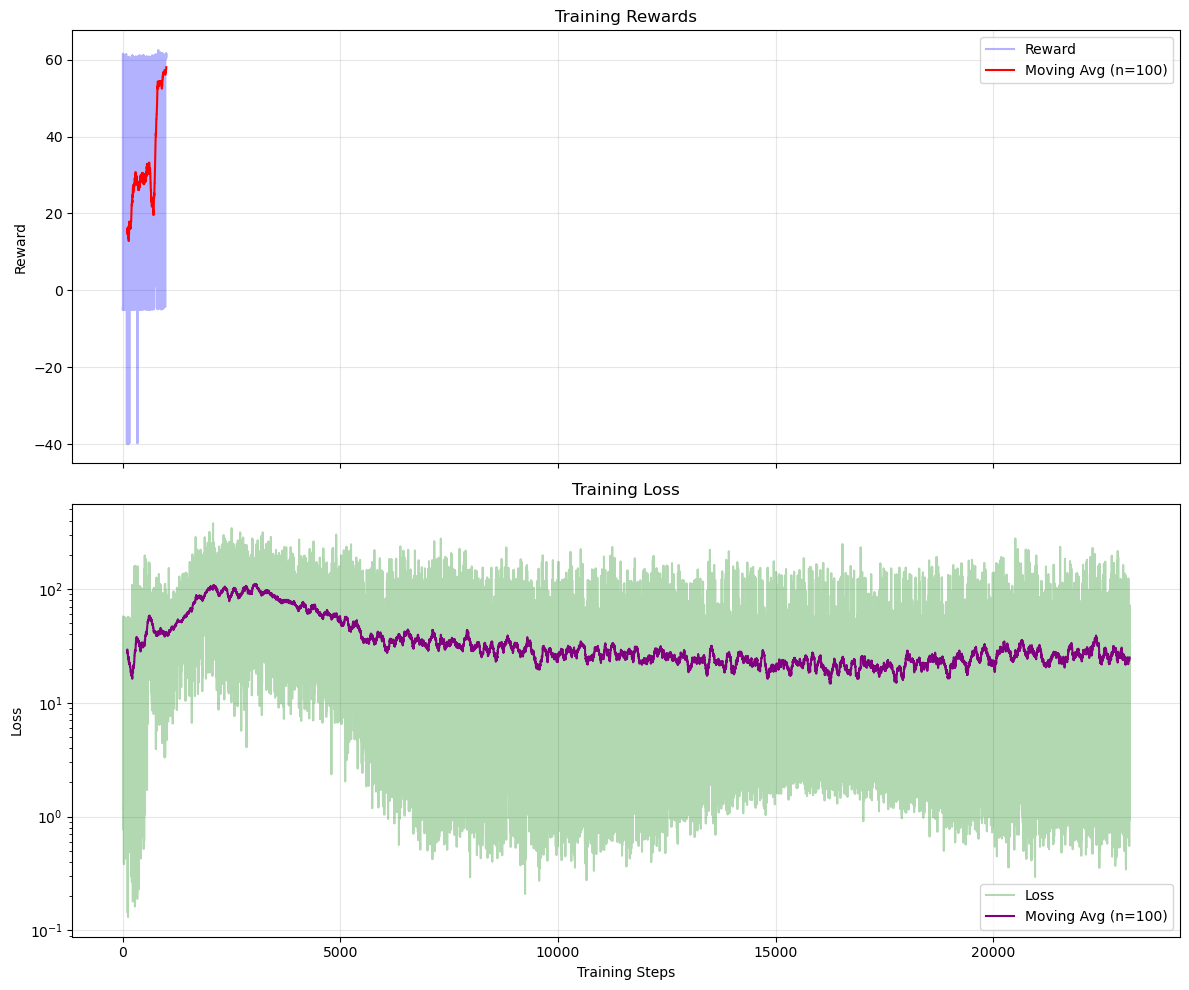

3.2 Reward distribution plot


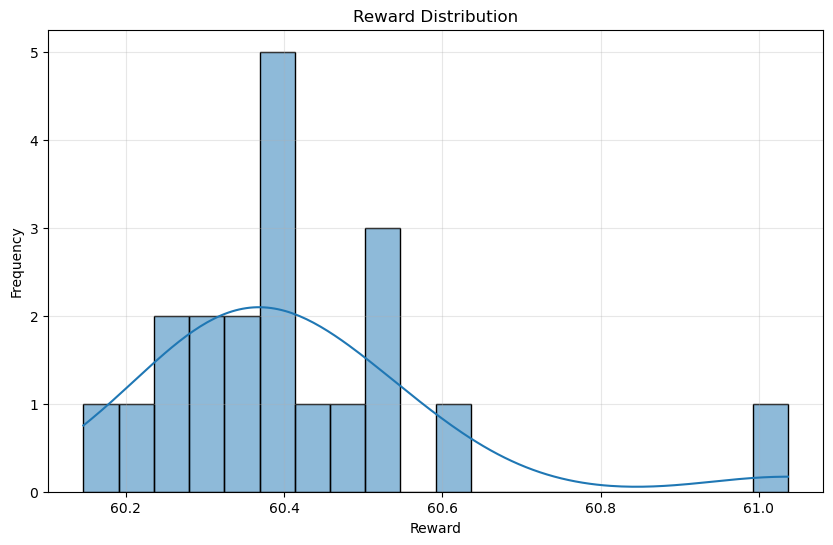

3.3 Action distribution plot


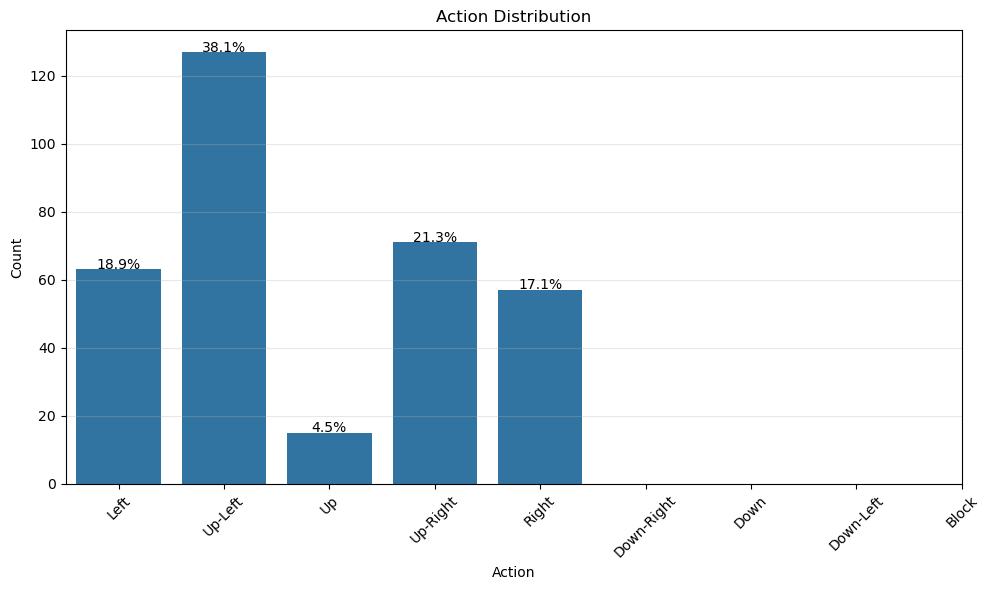

3.4 Field visualization


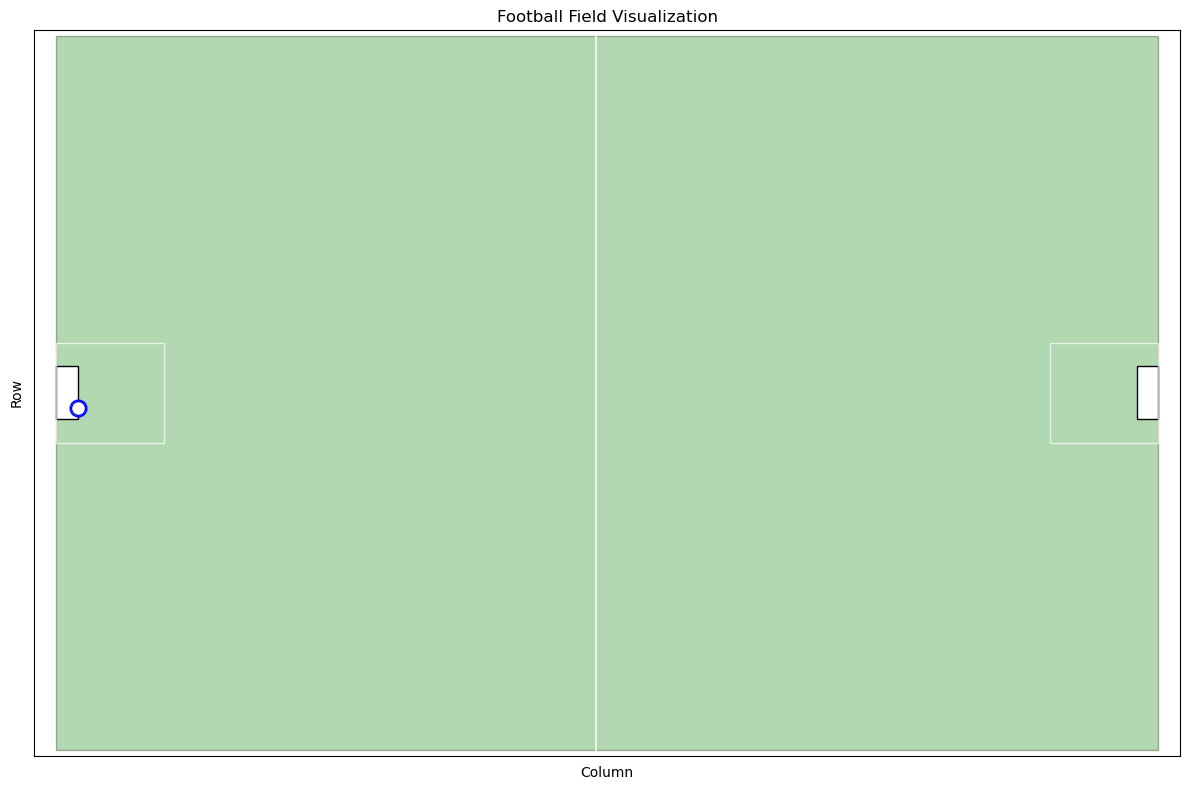

3.5 Q-value heatmap


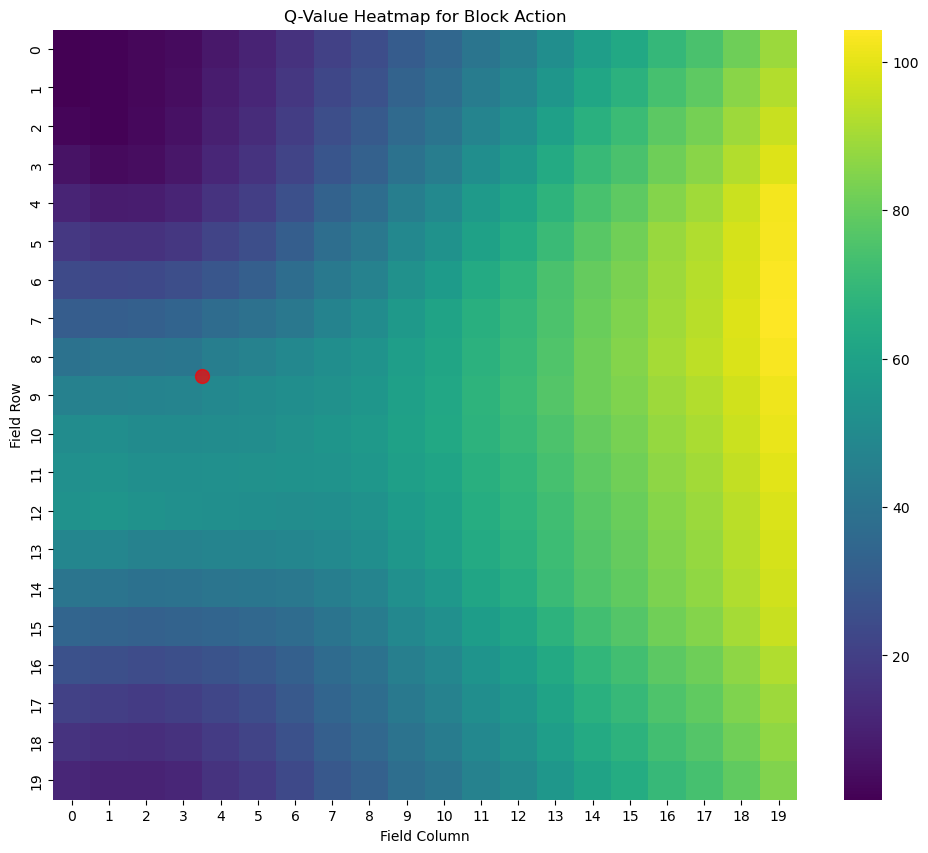

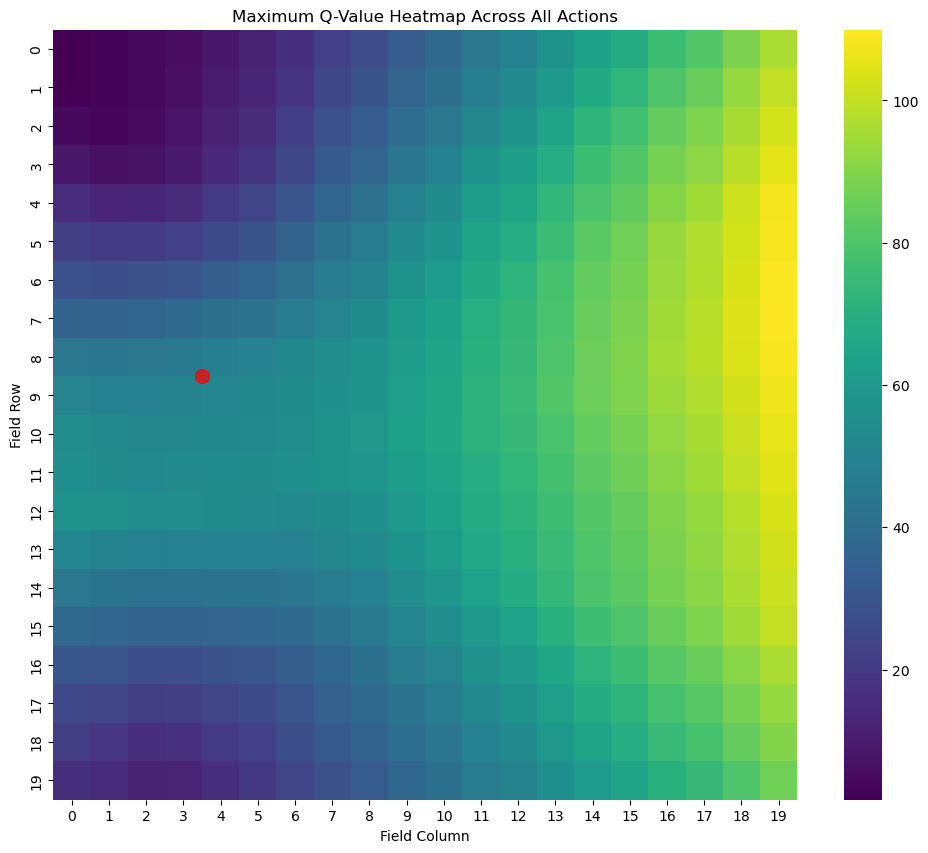

MovieWriter ffmpeg unavailable; using Pillow instead.



4. REPORT SAVED
----------------------------------------
All visualizations saved to directory: training_results

Generating animation of one evaluation episode...


ValueError: unknown file extension: .mp4

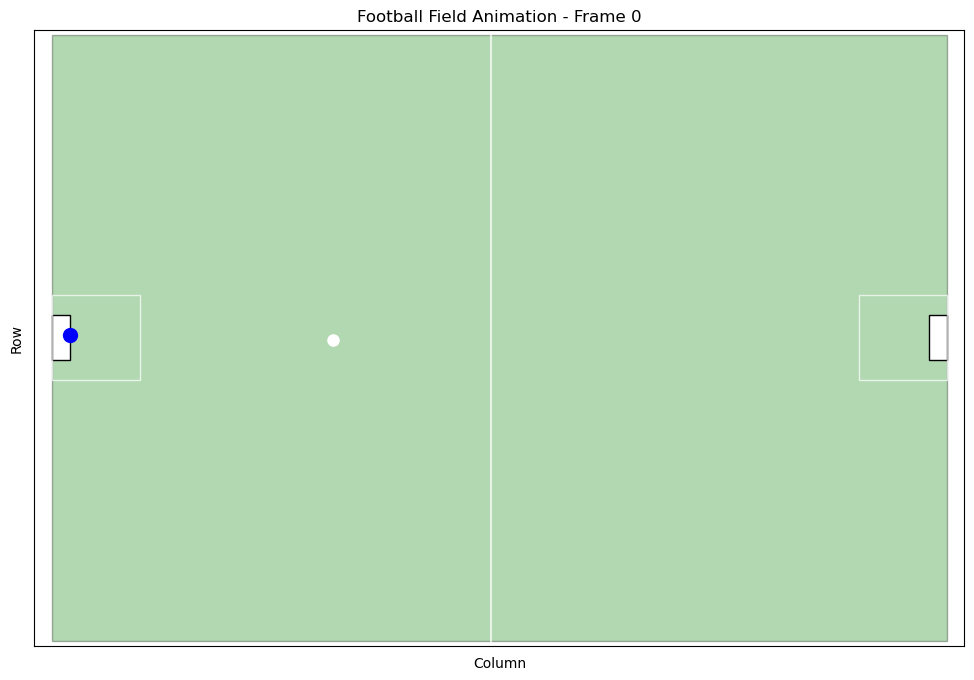

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from IPython.display import HTML
import torch
import os
from datetime import datetime

class TrainingVisualizer:
    """
    Class to visualize and report the training process and results of the goalkeeper agent.
    """
    def __init__(self, save_dir="training_results"):
        """Initialize the visualizer with a directory to save results."""
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
    def plot_training_progress(self, agent, save=True):
        """
        Plot the training progress including rewards and loss.
        
        Args:
            agent: DQNAgent instance with training history
            save: Whether to save the plot to disk
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        # Plot rewards
        rewards = np.array(agent.rewards_history)
        episodes = np.arange(1, len(rewards) + 1)
        
        # Calculate moving average with window size of 100
        window_size = min(100, len(rewards))
        moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        
        ax1.plot(episodes, rewards, alpha=0.3, color='blue', label='Reward')
        ax1.plot(np.arange(window_size, len(rewards) + 1), moving_avg, 
                 color='red', label=f'Moving Avg (n={window_size})')
        
        ax1.set_ylabel('Reward')
        ax1.set_title('Training Rewards')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot loss if available
        if hasattr(agent, 'loss_history') and len(agent.loss_history) > 0:
            losses = np.array(agent.loss_history)
            # We may have multiple losses per episode if batch replay was called multiple times
            loss_episodes = np.arange(1, len(losses) + 1)
            
            # Calculate moving average for loss
            window_size = min(100, len(losses))
            loss_moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
            
            ax2.plot(loss_episodes, losses, alpha=0.3, color='green', label='Loss')
            ax2.plot(np.arange(window_size, len(losses) + 1), loss_moving_avg, 
                     color='purple', label=f'Moving Avg (n={window_size})')
            
            ax2.set_ylabel('Loss')
            ax2.set_xlabel('Training Steps')
            ax2.set_title('Training Loss')
            ax2.set_yscale('log')  # Log scale for loss can help visualize improvements
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save:
            plt.savefig(f"{self.save_dir}/training_progress_{self.timestamp}.png", dpi=300)
            
        plt.show()
        
    def plot_reward_distribution(self, rewards, title="Reward Distribution", save=True):
        """
        Plot the distribution of rewards.
        
        Args:
            rewards: List of rewards from evaluation episodes
            title: Plot title
            save: Whether to save the plot
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(rewards, kde=True, bins=20)
        plt.title(title)
        plt.xlabel("Reward")
        plt.ylabel("Frequency")
        plt.grid(True, alpha=0.3)
        
        if save:
            plt.savefig(f"{self.save_dir}/reward_distribution_{self.timestamp}.png", dpi=300)
            
        plt.show()
        
    def plot_action_distribution(self, actions, title="Action Distribution", save=True):
        """
        Plot the distribution of actions taken during evaluation.
        
        Args:
            actions: List of actions from evaluation episodes
            title: Plot title
            save: Whether to save the plot
        """
        plt.figure(figsize=(10, 6))
        
        # Define action names for better readability
        action_names = [
            "Left", "Up-Left", "Up", "Up-Right", 
            "Right", "Down-Right", "Down", "Down-Left", "Block"
        ]
        
        # Count actions
        action_counts = pd.Series(actions).value_counts().sort_index()
        
        # Plot with action names
        ax = sns.barplot(x=action_counts.index, y=action_counts.values)
        
        # Set action names as x-tick labels
        plt.xticks(range(len(action_names)), action_names, rotation=45)
        
        plt.title(title)
        plt.xlabel("Action")
        plt.ylabel("Count")
        plt.grid(True, alpha=0.3, axis='y')
        
        # Add percentage labels on top of bars
        total = len(actions)
        for i, count in enumerate(action_counts):
            percentage = 100 * count / total
            ax.text(i, count + 0.1, f"{percentage:.1f}%", ha='center')
        
        plt.tight_layout()
        
        if save:
            plt.savefig(f"{self.save_dir}/action_distribution_{self.timestamp}.png", dpi=300)
            
        plt.show()
        
    def visualize_field(self, env, players, save=False):
        """
        Create a visualization of the football field with player and ball positions.
        
        Args:
            env: Football environment
            players: List of player objects
            save: Whether to save the visualization
        """
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Draw the field
        field = Rectangle((0, 0), env.grid_cols, env.grid_rows, 
                         fc='green', ec='black', alpha=0.3)
        ax.add_patch(field)
        
        # Draw the goals
        left_goal = Rectangle((0, env.grid_rows//2 - 4), 1, 9, 
                             fc='white', ec='black')
        right_goal = Rectangle((env.grid_cols-1, env.grid_rows//2 - 4), 1, 9, 
                              fc='white', ec='black')
        ax.add_patch(left_goal)
        ax.add_patch(right_goal)
        
        # Draw the center line
        plt.axvline(x=env.grid_cols//2, color='white', linestyle='-', alpha=0.7)
        
        # Draw the D-box
        d_box_left = Rectangle((0, env.grid_rows//2 - 8), 5, 17, 
                              fc='none', ec='white', alpha=0.7)
        d_box_right = Rectangle((env.grid_cols-5, env.grid_rows//2 - 8), 5, 17, 
                               fc='none', ec='white', alpha=0.7)
        ax.add_patch(d_box_left)
        ax.add_patch(d_box_right)
        
        # Draw the player
        player_colors = ['blue', 'red']
        for player in players:
            ax.plot(player.position[1], player.position[0], 'o', 
                   color=player_colors[player.team], markersize=10)
            
            # Highlight goalkeeper with a different marker
            if player.role == 'GK':
                ax.plot(player.position[1], player.position[0], 'o', 
                       color=player_colors[player.team], markersize=12, fillstyle='none')
        
        # Draw the ball
        ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', color='white', markersize=8)
        
        # Set axis limits and labels
        ax.set_xlim(-1, env.grid_cols+1)
        ax.set_ylim(-1, env.grid_rows+1)
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')
        ax.set_title('Football Field Visualization')
        
        # Remove ticks for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        
        if save:
            plt.savefig(f"{self.save_dir}/field_visualization_{self.timestamp}.png", dpi=300)
            
        plt.tight_layout()
        plt.show()
        
    def create_trajectory_animation(self, env, trajectory, save=True):
        """
        Create an animation of the goalkeeper and ball trajectories.
        
        Args:
            env: Football environment
            trajectory: List of dictionaries containing player_pos and ball_pos
            save: Whether to save the animation
        """
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Function to update the plot for animation
        def update(frame):
            ax.clear()
            
            # Draw the field
            field = Rectangle((0, 0), env.grid_cols, env.grid_rows, 
                             fc='green', ec='black', alpha=0.3)
            ax.add_patch(field)
            
            # Draw the goals
            left_goal = Rectangle((0, env.grid_rows//2 - 4), 1, 9, 
                                 fc='white', ec='black')
            right_goal = Rectangle((env.grid_cols-1, env.grid_rows//2 - 4), 1, 9, 
                                  fc='white', ec='black')
            ax.add_patch(left_goal)
            ax.add_patch(right_goal)
            
            # Draw the center line
            ax.axvline(x=env.grid_cols//2, color='white', linestyle='-', alpha=0.7)
            
            # Draw the D-box
            d_box_left = Rectangle((0, env.grid_rows//2 - 8), 5, 17, 
                                  fc='none', ec='white', alpha=0.7)
            d_box_right = Rectangle((env.grid_cols-5, env.grid_rows//2 - 8), 5, 17, 
                                   fc='none', ec='white', alpha=0.7)
            ax.add_patch(d_box_left)
            ax.add_patch(d_box_right)
            
            # Draw player trajectory
            player_positions = [traj['player_pos'] for traj in trajectory[:frame+1]]
            player_x = [pos[1] for pos in player_positions]
            player_y = [pos[0] for pos in player_positions]
            ax.plot(player_x, player_y, '-', color='blue', alpha=0.5, linewidth=2)
            
            # Draw the current player position
            current_player_pos = trajectory[frame]['player_pos']
            
            # Check if the player has the ball
            if trajectory[frame]['has_ball']:
                ax.plot(current_player_pos[1], current_player_pos[0], 'o', 
                       color='blue', markersize=12, fillstyle='full')
            else:
                ax.plot(current_player_pos[1], current_player_pos[0], 'o', 
                       color='blue', markersize=10)
            
            # Draw ball trajectory
            ball_positions = [traj['ball_pos'] for traj in trajectory[:frame+1]]
            ball_x = [pos[1] for pos in ball_positions]
            ball_y = [pos[0] for pos in ball_positions]
            ax.plot(ball_x, ball_y, '-', color='orange', alpha=0.5, linewidth=2)
            
            # Draw the current ball position
            current_ball_pos = trajectory[frame]['ball_pos']
            
            # Only draw the ball if it's not caught
            if not trajectory[frame]['has_ball']:
                ax.plot(current_ball_pos[1], current_ball_pos[0], 'o', 
                       color='white', markersize=8)
            
            # Set axis limits and labels
            ax.set_xlim(-1, env.grid_cols+1)
            ax.set_ylim(-1, env.grid_rows+1)
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            ax.set_title(f'Football Field Animation - Frame {frame}')
            
            # Remove ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
            
            return ax,
        
        # Create animation
        anim = animation.FuncAnimation(fig, update, frames=len(trajectory), interval=200, blit=False)
        
        # Save animation if requested
        if save:
            anim.save(f"{self.save_dir}/trajectory_animation_{self.timestamp}.mp4", writer='ffmpeg', dpi=100)
        
        plt.close()
        
        return HTML(anim.to_html5_video())
    
    def plot_q_values_heatmap(self, agent, env, players, save=True):
        """
        Create a heatmap of Q-values for different positions on the field.
        
        Args:
            agent: DQNAgent instance
            env: Football environment
            players: List of player objects
            save: Whether to save the heatmap
        """
        # Define grid dimensions for sampling
        sample_rows = 20
        sample_cols = 20
        
        # Create meshgrid for field positions
        rows = np.linspace(1, env.grid_rows-1, sample_rows)
        cols = np.linspace(1, env.grid_cols-1, sample_cols)
        
        # Initialize Q-value array for the 'block' action
        q_values = np.zeros((sample_rows, sample_cols))
        max_action_values = np.zeros((sample_rows, sample_cols))
        
        # Set ball position (fixed for this analysis)
        fixed_ball_pos = (env.grid_rows // 2, env.grid_cols // 4)
        
        # Sample Q-values for different positions
        for i, row in enumerate(rows):
            for j, col in enumerate(cols):
                # Set player position
                players[0].position = (int(row), int(col))
                
                # Set ball position
                env.ball_pos = fixed_ball_pos
                
                # Get state
                state = env._get_state(players[0], players)
                
                # Convert to tensor
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
                
                # Get Q-values
                with torch.no_grad():
                    q_vals = agent.model(state_tensor).cpu().numpy()[0]
                
                # Store Q-value for block action (assuming it's the last action)
                q_values[i, j] = q_vals[8]  # Block action Q-value
                
                # Store maximum Q-value across all actions
                max_action_values[i, j] = np.max(q_vals)
        
        # Plot heatmap for block action
        plt.figure(figsize=(12, 10))
        sns.heatmap(q_values, cmap='viridis', annot=False)
        plt.title('Q-Value Heatmap for Block Action')
        plt.xlabel('Field Column')
        plt.ylabel('Field Row')
        
        # Mark the ball position
        y_idx = np.argmin(np.abs(rows - fixed_ball_pos[0]))
        x_idx = np.argmin(np.abs(cols - fixed_ball_pos[1]))
        plt.plot(x_idx, y_idx, 'ro', markersize=10, alpha=0.7)
        
        if save:
            plt.savefig(f"{self.save_dir}/block_q_value_heatmap_{self.timestamp}.png", dpi=300)
        
        plt.show()
        
        # Plot heatmap for max action value
        plt.figure(figsize=(12, 10))
        sns.heatmap(max_action_values, cmap='viridis', annot=False)
        plt.title('Maximum Q-Value Heatmap Across All Actions')
        plt.xlabel('Field Column')
        plt.ylabel('Field Row')
        
        # Mark the ball position
        plt.plot(x_idx, y_idx, 'ro', markersize=10, alpha=0.7)
        
        if save:
            plt.savefig(f"{self.save_dir}/max_q_value_heatmap_{self.timestamp}.png", dpi=300)
        
        plt.show()
    
    def generate_report(self, agent, env, players, eval_rewards, actions_taken, success_rate):
        """
        Generate a comprehensive report with all visualizations.
        
        Args:
            agent: DQNAgent instance
            env: Football environment
            players: List of player objects
            eval_rewards: List of rewards from evaluation
            actions_taken: List of actions from evaluation
            success_rate: Success rate from evaluation
        """
        print("=" * 80)
        print(f"GOALKEEPER AGENT TRAINING REPORT - {self.timestamp}")
        print("=" * 80)
        
        print("\n1. TRAINING SUMMARY")
        print("-" * 40)
        print(f"Total episodes: {agent.episode_count}")
        print(f"Final exploration rate (epsilon): {agent.epsilon:.5f}")
        print(f"Average reward (last 100 episodes): {np.mean(agent.rewards_history[-100:]):.2f}")
        if hasattr(agent, 'loss_history') and len(agent.loss_history) > 0:
            print(f"Final loss value: {agent.loss_history[-1]:.5f}")
        
        print("\n2. EVALUATION RESULTS")
        print("-" * 40)
        print(f"Average evaluation reward: {np.mean(eval_rewards):.2f}")
        print(f"Success rate: {success_rate:.2f}")
        print(f"Minimum reward: {np.min(eval_rewards):.2f}")
        print(f"Maximum reward: {np.max(eval_rewards):.2f}")
        
        # Create plots
        print("\n3. GENERATING VISUALIZATIONS")
        print("-" * 40)
        
        # 3.1 Training progress
        print("3.1 Training progress plot")
        self.plot_training_progress(agent, save=True)
        
        # 3.2 Reward distribution
        print("3.2 Reward distribution plot")
        self.plot_reward_distribution(eval_rewards, save=True)
        
        # 3.3 Action distribution
        if actions_taken:
            print("3.3 Action distribution plot")
            self.plot_action_distribution(actions_taken, save=True)
        
        # 3.4 Field visualization
        print("3.4 Field visualization")
        self.visualize_field(env, players, save=True)
        
        # 3.5 Q-value heatmap
        print("3.5 Q-value heatmap")
        self.plot_q_values_heatmap(agent, env, players, save=True)
        
        print("\n4. REPORT SAVED")
        print("-" * 40)
        print(f"All visualizations saved to directory: {self.save_dir}")
        print("=" * 80)


# Extension to the DQNAgent to track actions taken during evaluation
def track_evaluation(agent, env, players, episodes=5, max_steps=50, render=False):
    """
    Track agent's actions and performance during evaluation.
    
    Args:
        agent: Trained DQN agent
        env: Football environment
        players: List of player objects
        episodes: Number of evaluation episodes
        max_steps: Maximum steps per episode
        render: Whether to render the environment
    
    Returns:
        Tuple of (rewards, actions_taken, success_rate)
    """
    episode_rewards = []
    actions_taken = []
    success_count = 0
    
    for episode in range(episodes):
        # Reset the environment
        env.reset(players)
        
        # Place ball at realistic position
        ball_row = random.randint(env.grid_rows // 2 - 10, env.grid_rows // 2 + 10)
        ball_col = random.randint(10, 30)  # Medium distance
        env.ball_pos = (ball_row, ball_col)
        
        # Direction toward goal
        goal_center = (env.grid_rows // 2, 0)
        direction_row = goal_center[0] - ball_row
        direction_col = goal_center[1] - ball_col
        
        # Normalize direction
        magnitude = np.sqrt(direction_row**2 + direction_col**2)
        env.ball_direction = (direction_row / magnitude, direction_col / magnitude)
        
        # Random but reasonable speed
        env.ball_speed = random.uniform(0.8, 1.2)
        
        total_reward = 0
        done = False
        truncated = False
        
        # Get initial state
        state = env._get_state(players[0], players)
        
        for step in range(max_steps):
            if done or truncated:
                break
                
            # Render if requested
            if render:
                env.render(players)
                time.sleep(0.1)
            
            # Choose action
            action = agent.act(state, evaluate=True)
            actions_taken.append(action)
            
            # Take action
            next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
            
            state = next_state
            total_reward += reward
        
        # Track results
        episode_rewards.append(total_reward)
        
        # Count successes (goalkeeper caught the ball)
        if players[0].has_ball:
            success_count += 1
    
    success_rate = success_count / episodes
    return episode_rewards, actions_taken, success_rate


# Enhanced main function with visualization and reporting
def main_with_visualization():
    # Set up environment and agent
    env = FootballEnv(grid_rows=121, grid_cols=51)
    players = [Player('GK', 0, env)]
    
    # Initialize visualizer
    visualizer = TrainingVisualizer()
    
    # Get initial state to determine state size
    env.reset(players)
    sample_state = env._get_state(players[0], players)
    state_size = len(sample_state)
    
    print(f"State size: {state_size}")
    
    # Create the DQN agent
    agent = DQNAgent(state_size, 9)
    
    # Training options
    print("\nTraining Options:")
    print("1. Quick training (100 episodes)")
    print("2. Medium training (500 episodes)")
    print("3. Full curriculum training (1000+ episodes)")
    print("4. Load pre-trained model")
    
    choice = input("Select option (1-4): ")
    
    if choice == "1":
        # Quick training
        episodes = 100
        print(f"\nStarting quick training for {episodes} episodes...")
        
        for episode in range(episodes):
            # Reset environment with random ball position
            env.reset(players)
            
            # Set ball to move toward goal
            env.ball_direction = (0, -1)  # Move left toward goal
            
            total_reward = 0
            done = False
            truncated = False
            
            # Get initial state
            state = env._get_state(players[0], players)
            
            for step in range(50):  # Max 50 steps per episode
                if done or truncated:
                    break
                
                # Choose action
                action = agent.act(state)
                
                # Take action
                next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
                
                # Store experience
                agent.remember(state, action, reward, next_state, done or truncated)
                
                # Learn from experiences
                if len(agent.memory) >= agent.batch_size:
                    loss = agent.replay()
                
                state = next_state
                total_reward += reward
            
            # Update target network periodically
            if episode % agent.target_update_freq == 0:
                agent.update_target_model()
            
            # Decay exploration rate
            agent.decay_epsilon()
            
            # Track rewards
            agent.rewards_history.append(total_reward)
            
            # Show progress
            if (episode + 1) % 10 == 0:
                print(f"Episode {episode+1}/{episodes}: Reward = {total_reward:.2f}, Epsilon = {agent.epsilon:.3f}")
        
    elif choice == "2":
        # Medium training
        episodes = 500
        print(f"\nStarting medium training for {episodes} episodes...")
        
        for episode in range(episodes):
            # Reset environment
            env.reset(players)
            
            # Set ball with some randomness but generally toward goal
            angle = random.uniform(-0.3, 0.3)
            env.ball_direction = (np.sin(angle), -np.cos(angle))
            env.ball_speed = random.uniform(0.7, 1.3)
            
            total_reward = 0
            done = False
            truncated = False
            
            # Get initial state
            state = env._get_state(players[0], players)
            
            for step in range(50):
                if done or truncated:
                    break
                
                # Choose action
                action = agent.act(state)
                
                # Take action
                next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
                
                # Store experience
                agent.remember(state, action, reward, next_state, done or truncated)
                
                # Learn from experiences
                if len(agent.memory) >= agent.batch_size:
                    loss = agent.replay()
                
                state = next_state
                total_reward += reward
            
            # Update target network periodically
            if episode % agent.target_update_freq == 0:
                agent.update_target_model()
            
            # Decay exploration rate
            agent.decay_epsilon()
            
            # Track rewards
            agent.rewards_history.append(total_reward)
            
            # Show progress
            if (episode + 1) % 50 == 0:
                print(f"Episode {episode+1}/{episodes}: Reward = {total_reward:.2f}, Epsilon = {agent.epsilon:.3f}")
    
    elif choice == "3":
        # Full curriculum training
        print("\nStarting full curriculum training...")
        agent = curriculum_train_goalkeeper(env, episodes=1000, stages=5, episodes_per_stage=200, max_steps=50)
        
    elif choice == "4":
        # Load pre-trained model
        model_path = input("Enter the path to the pre-trained model: ")
        try:
            agent.model.load_state_dict(torch.load(model_path))
            agent.target_model.load_state_dict(agent.model.state_dict())
            print(f"Model loaded successfully from {model_path}")
            
            # Set to evaluation mode
            agent.epsilon = 0.0
        except:
            print(f"Error loading model from {model_path}. Using new model instead.")
    
    else:
        print("Invalid choice. Using quick training.")
        # Default to quick training
        agent = quick_train_goalkeeper(env, players, agent, episodes=100)
    
    # Save the trained model
    model_path = f"{visualizer.save_dir}/goalkeeper_model_{visualizer.timestamp}.pth"
    torch.save(agent.model.state_dict(), model_path)
    print(f"\nModel saved to {model_path}")
    
    # Evaluate the model and collect metrics
    print("\nEvaluating the model...")
    eval_rewards, actions_taken, success_rate = track_evaluation(agent, env, players, episodes=20, render=False)
    
    # Generate comprehensive report
    visualizer.generate_report(agent, env, players, eval_rewards, actions_taken, success_rate)
    
    # Show an animation of one episode
    print("\nGenerating animation of one evaluation episode...")
    env.reset(players)
    
    # Place ball at a good position for visualization
    env.ball_pos = (env.grid_rows // 2, env.grid_cols // 3)
    
    # Direction toward goal
    goal_center = (env.grid_rows // 2, 0)
    direction_row = goal_center[0] - env.ball_pos[0]
    direction_col = goal_center[1] - env.ball_pos[1]
    
    # Normalize direction
    magnitude = np.sqrt(direction_row**2 + direction_col**2)
    env.ball_direction = (direction_row / magnitude, direction_col / magnitude)
    
    # Set moderate ball speed
    env.ball_speed = 1.0
    
    # Run episode
    state = env._get_state(players[0], players)
    done = False
    truncated = False
    
    # Reset the trajectory
    env.trajectory = []
    
    for step in range(50):
        if done or truncated:
            break
        
        action = agent.act(state, evaluate=True)
        next_state, reward, done, truncated, _ = env.step_goalkeeper(action, players[0], players)
        state = next_state
    
    # Create and display animation
    animation_html = visualizer.create_trajectory_animation(env, env.trajectory)
    
    print("\nEvaluation complete!")
    print(f"Success rate: {success_rate:.2f}")
    print(f"Average reward: {np.mean(eval_rewards):.2f}")
    
    return animation_html


# Execute the main function with visualization if running directly
if __name__ == "__main__":
    animation = main_with_visualization()
    display(animation)